In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import nrrd
print("------------------------------------------------------------------------------------------------")
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print("------------------------------------------------------------------------------------------------")

2024-06-18 09:31:25.157803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 09:31:26.112871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


------------------------------------------------------------------------------------------------
2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
------------------------------------------------------------------------------------------------


In [2]:

def encoder_block(inputs, output_channels, lastlayer=False):
    """
    Two 3x3x3 convolutions with batch normalization and ReLU activation
    2x2x2 max pool
    """

    # 3x3x3 convolutions with ReLU activation
    x = tf.keras.layers.Conv3D(int(output_channels/2), kernel_size=3, strides=1, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv3D(output_channels, kernel_size=3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # 2x2x2 max pool

    if not lastlayer:
        x_maxPool = tf.keras.layers.MaxPool3D(pool_size=2, strides=2, padding = 'same')(x)
    else:
        x_maxPool = x

    return x, x_maxPool

def decoder_block(inputs, skip_features, output_channels):

    # Upsampling with 2x2x2 filter
    x = tf.keras.layers.Conv3DTranspose(output_channels*2, kernel_size=2, strides=2, padding = 'same')(inputs)

# Concatenate the skip features
    x = tf.keras.layers.Concatenate()([x, skip_features])

    # 2 convolutions with 3x3 filter, batch normalization, ReLU activation
    x = tf.keras.layers.Conv3D(output_channels, kernel_size=3, strides=1, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv3D(output_channels, kernel_size=3, strides=1, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    return x

def unet_3D():
    inputs = tf.keras.Input(shape=(64, 64, 64, 1,))

    e1_skip, e1_maxpool = encoder_block(inputs, 64)
    e2_skip, e2_maxpool = encoder_block(e1_maxpool, 128)
    e3_skip, e3_maxpool = encoder_block(e2_maxpool, 256)
    _, e4 = encoder_block(e3_maxpool, 512, True)

    decoder1 = decoder_block(e4, e3_skip, 256)
    decoder2 = decoder_block(decoder1, e2_skip, 128)
    decoder3 = decoder_block(decoder2, e1_skip, 64)

    outputs = tf.keras.layers.Conv3D(1, 1, strides = 1)(decoder3)
    # outputs = tf.keras.layers.Conv3D(2, 1, strides = 1)(decoder3)
    # outputs = tf.keras.layers.Reshape((64*64*64, 2))(outputs)
    outputs = tf.keras.layers.Activation('sigmoid')(outputs)

    model = tf.keras.models.Model(inputs = inputs,  outputs = outputs,  name = 'Unet3D')

    return model
    

In [3]:
def iou(y_true, y_pred, smooth=0.000000001):
    # yt = K.argmax(y_true, axis=2)
    # yp = K.argmax(y_pred, axis=2)
    # print(y_pred)
    #yp = y_pred[0]
    # yp[yp>=0.5]=1
    # yp[yp<0.5]=0
    yp = y_pred
    yp = tf.where(yp >= 0.5, tf.ones_like(yp), yp)
    yp = tf.where(yp < 0.5, tf.zeros_like(yp), yp)
    yp = K.cast(yp, np.float32)

    yt = K.cast(y_true, np.float32)

    # print(yt.shape)
    # print(yp.shape)
    
    intersection = K.sum(yt * yp)
    union = K.sum(yt) + K.sum(yp)
    # intersection = K.sum(yt * yp, axis=1)
    # union = K.sum(yt, axis=1) + K.sum(yp, axis=1)
    return (intersection + smooth) / (union-intersection+smooth)

In [4]:
model = unet_3D()
# model.summary()

print("compiling model")
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='dice')#, metrics=[iou])

compiling model


2024-06-18 09:31:49.704790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9704 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:65:00.0, compute capability: 8.9


In [5]:
import os
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
cp-0177.weights.h5


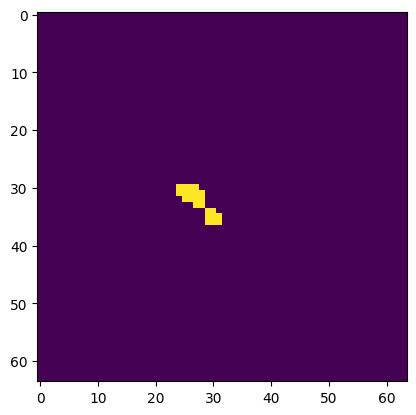

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0091.weights.h5


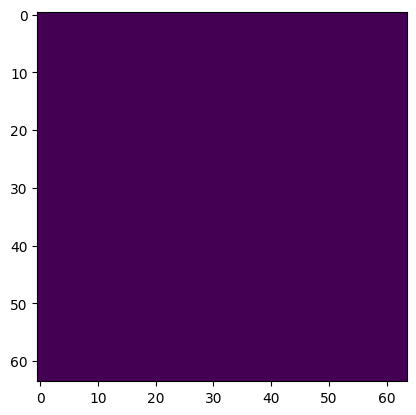

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0107.weights.h5


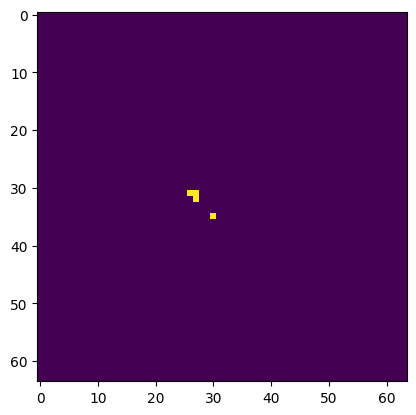

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0029.weights.h5


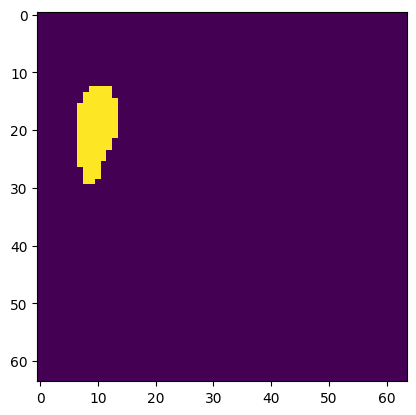

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0111.weights.h5


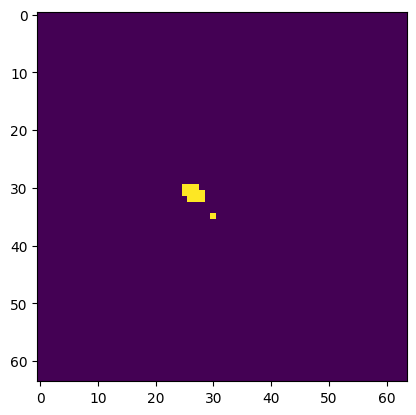

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0164.weights.h5


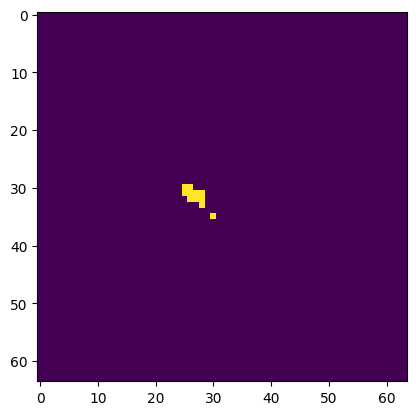

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0136.weights.h5


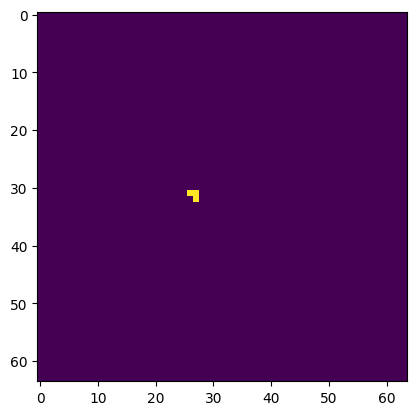

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0192.weights.h5


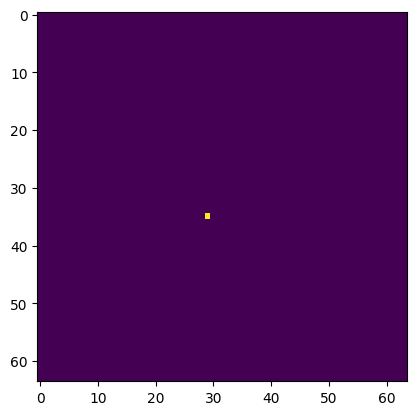

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0123.weights.h5


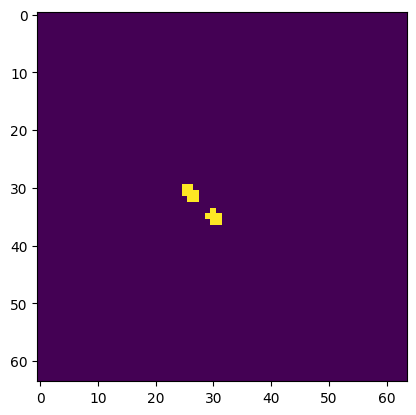

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0070.weights.h5


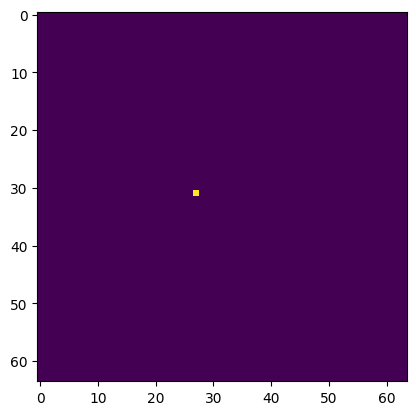

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0026.weights.h5


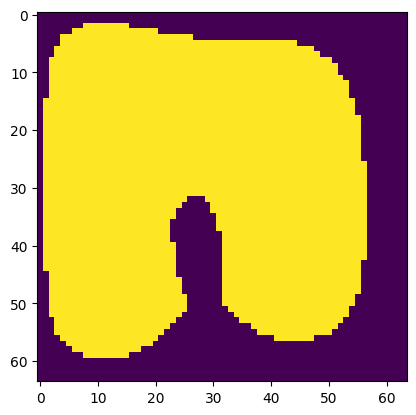

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0140.weights.h5


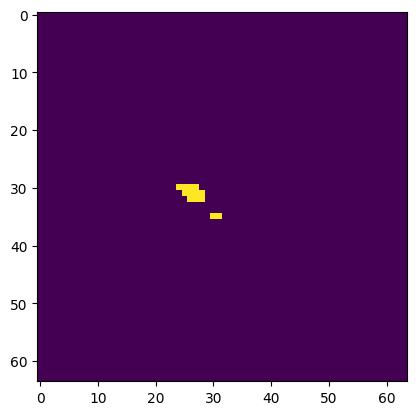

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0077.weights.h5


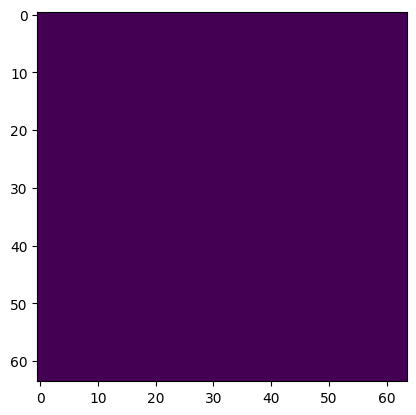

error with: cp-0360.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
error with: cp-0260.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0160.weights.h5


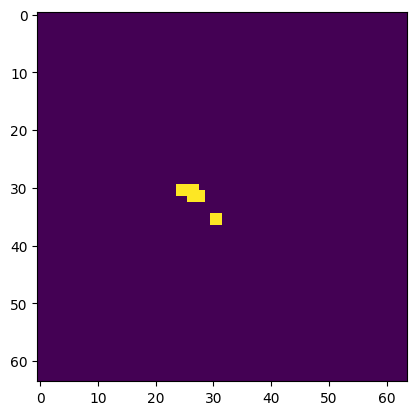

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0108.weights.h5


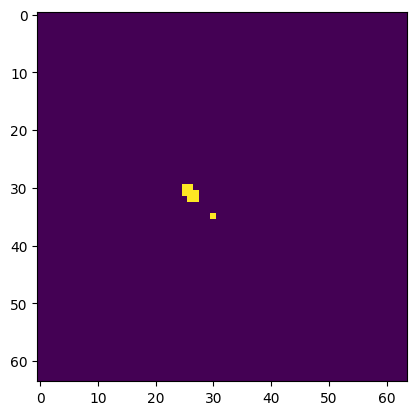

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
cp-0150.weights.h5


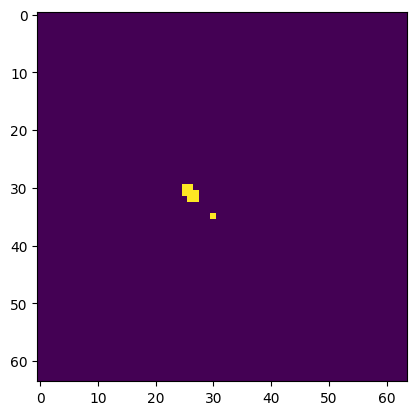

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0074.weights.h5


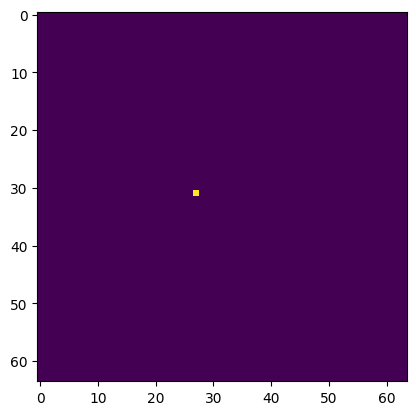

error with: cp-0230.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0090.weights.h5


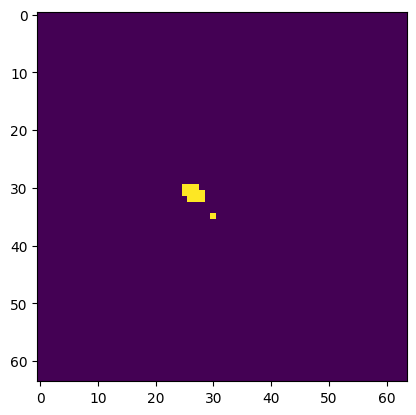

error with: cp-0300.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0185.weights.h5


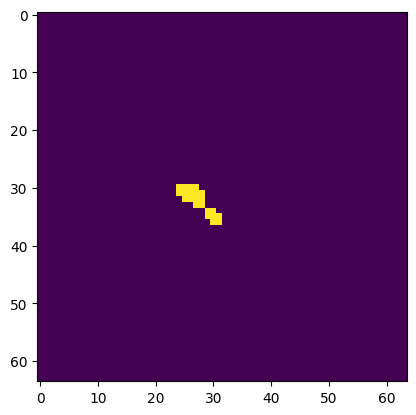

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
cp-0121.weights.h5


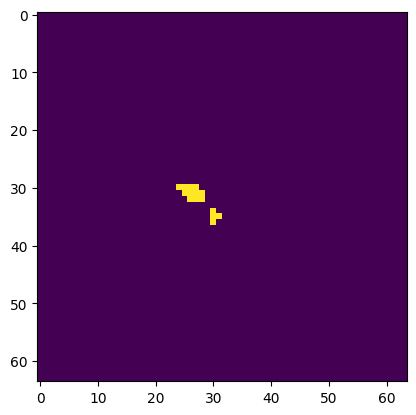

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0103.weights.h5


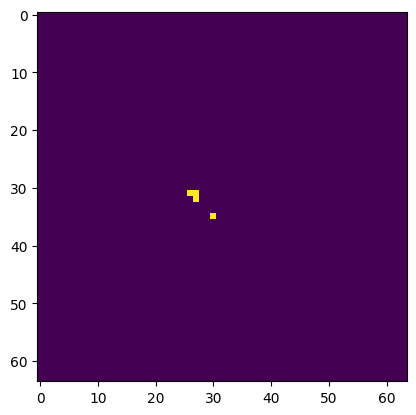

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0133.weights.h5


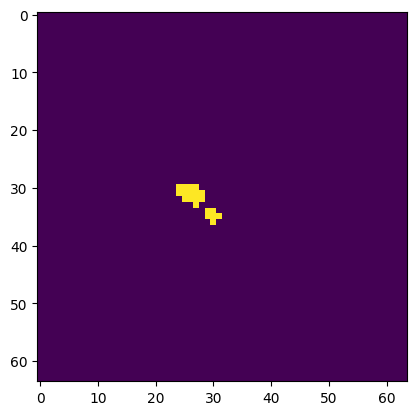

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
cp-0071.weights.h5


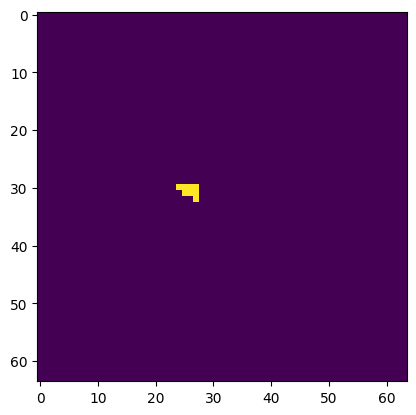

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0110.weights.h5


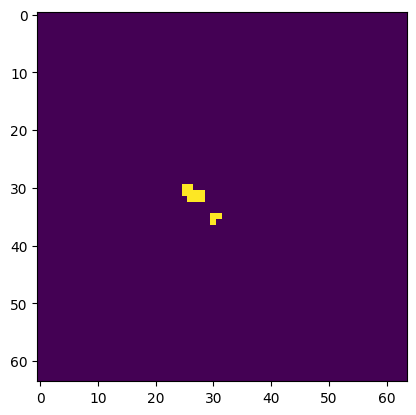

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0198.weights.h5


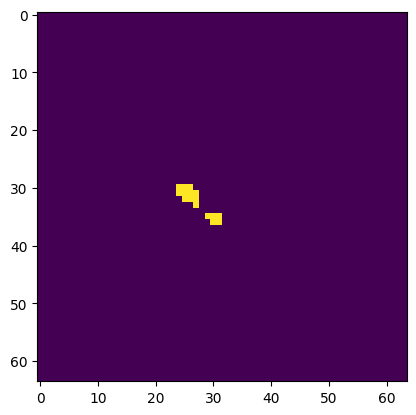

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0132.weights.h5


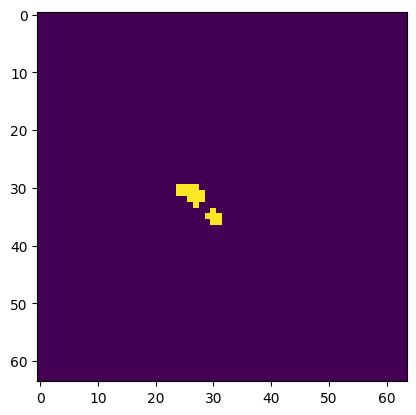

error with: cp-0330.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
cp-0149.weights.h5


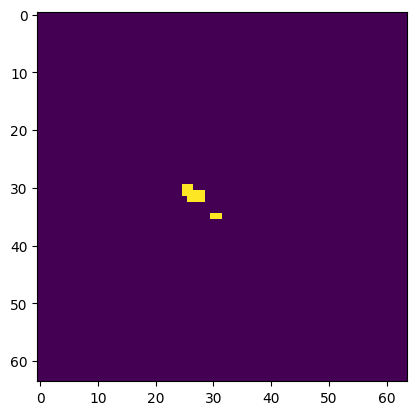

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0183.weights.h5


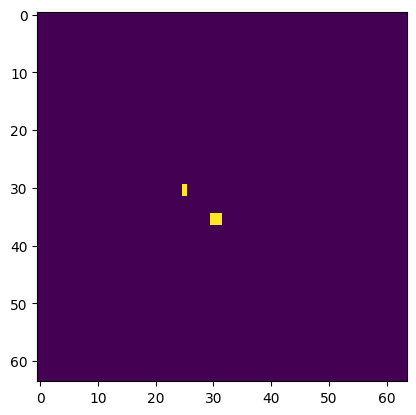

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0147.weights.h5


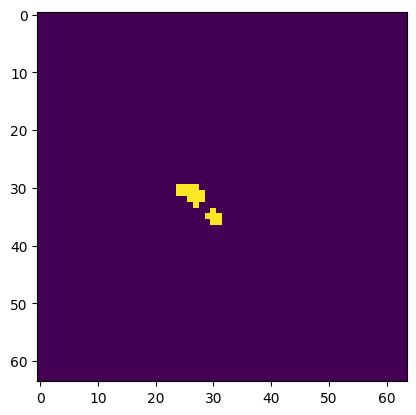

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0181.weights.h5


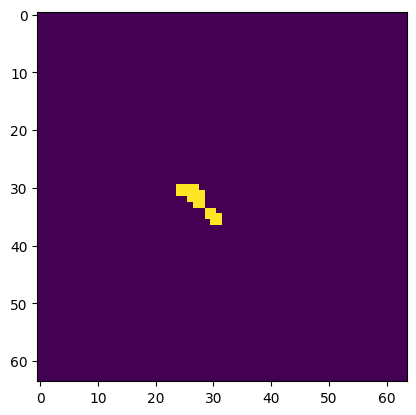

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0125.weights.h5


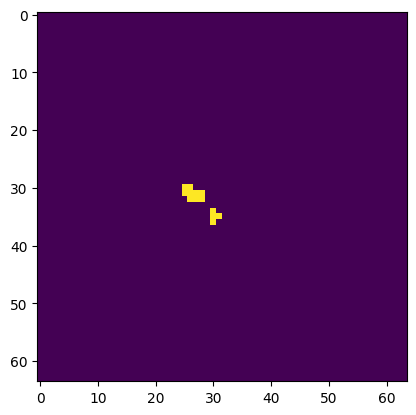

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0102.weights.h5


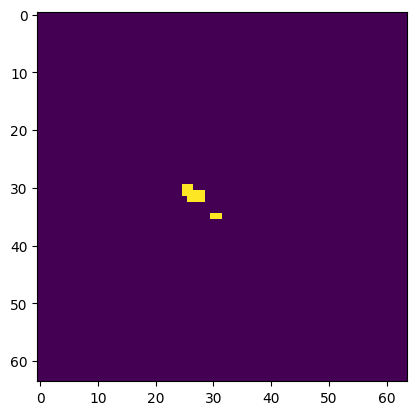

error with: cp-0220.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0130.weights.h5


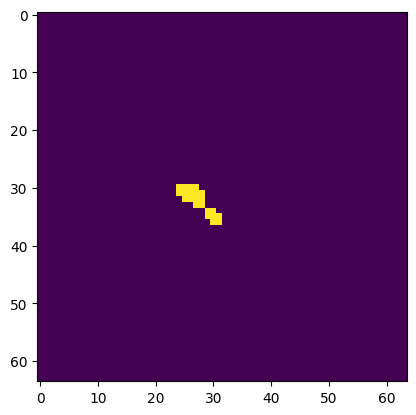

error with: cp-0380.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0031.weights.h5


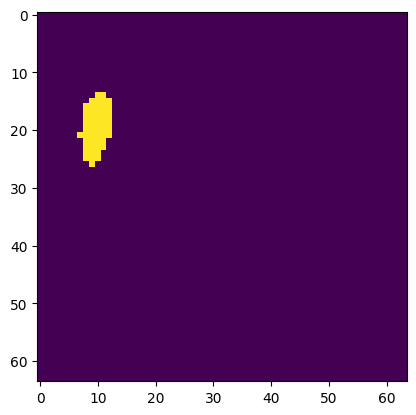

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0158.weights.h5


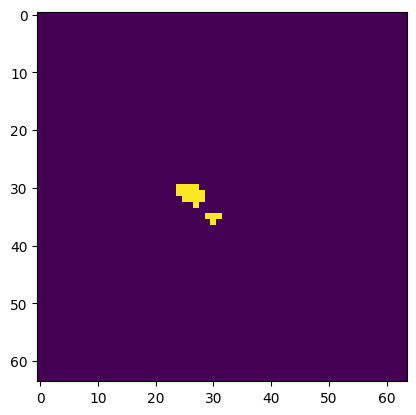

error with: cp-0280.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0169.weights.h5


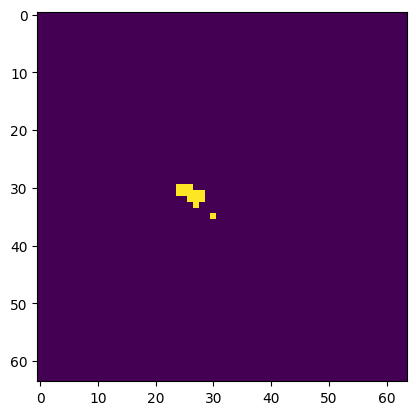

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0120.weights.h5


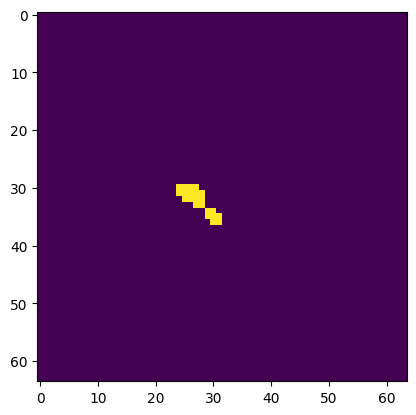

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0167.weights.h5


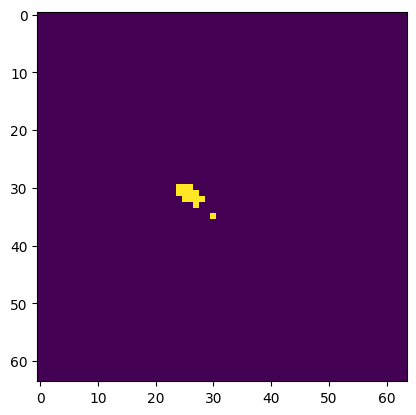

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0135.weights.h5


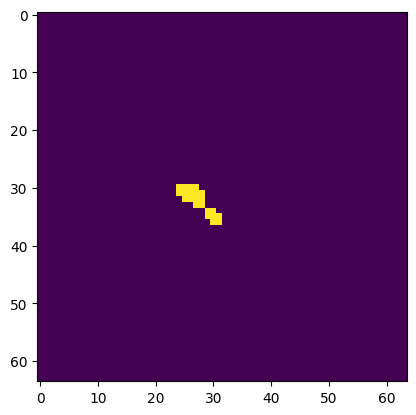

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
cp-0126.weights.h5


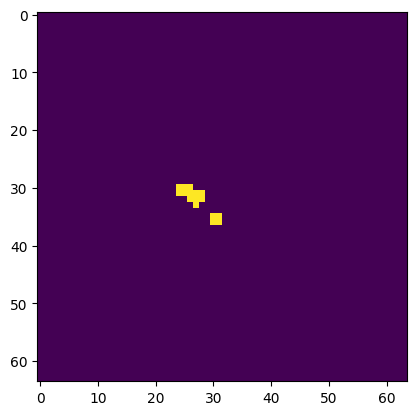

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0152.weights.h5


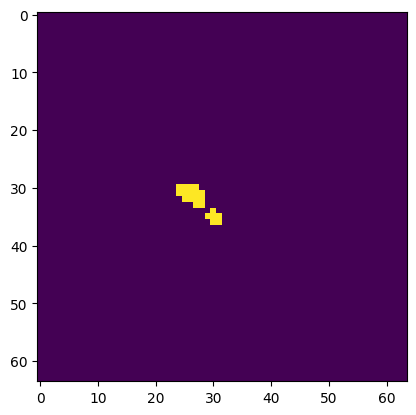

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0128.weights.h5


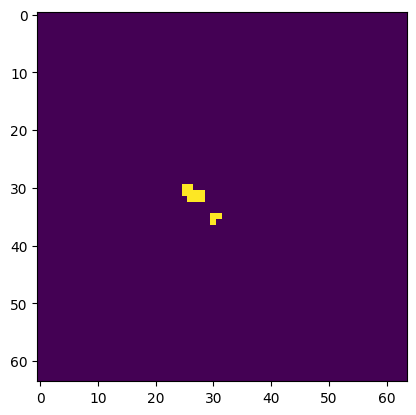

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0106.weights.h5


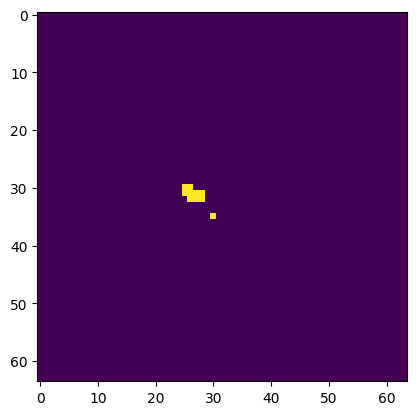

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0088.weights.h5


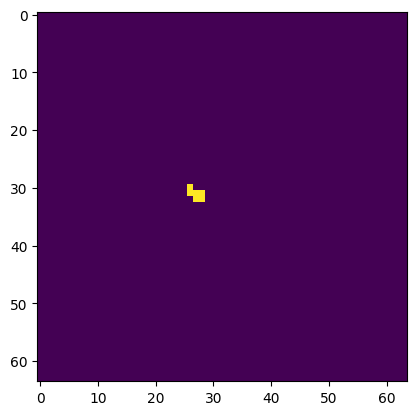

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0190.weights.h5


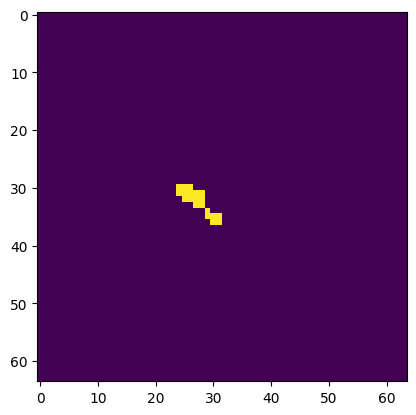

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
error with: cp-0250.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0118.weights.h5


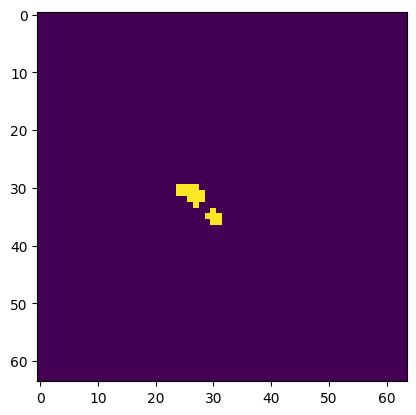

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0069.weights.h5


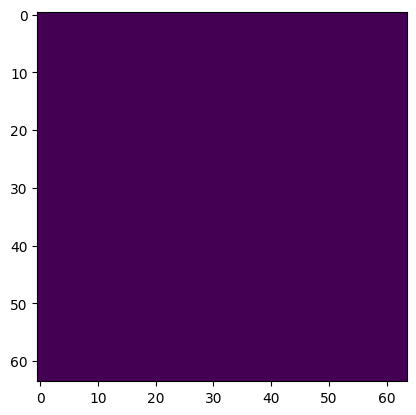

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0163.weights.h5


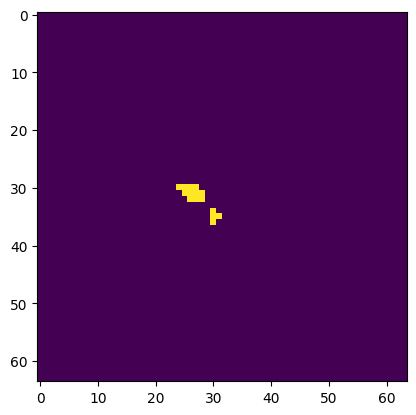

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0141.weights.h5


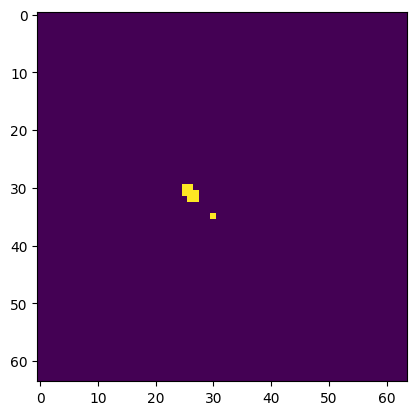

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0086.weights.h5


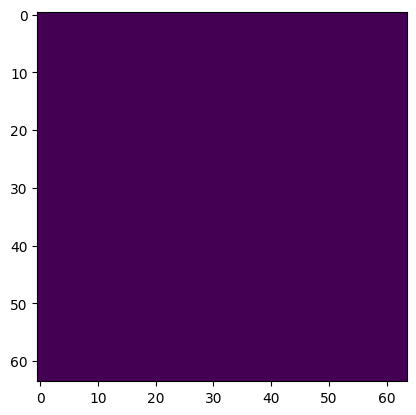

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0180.weights.h5


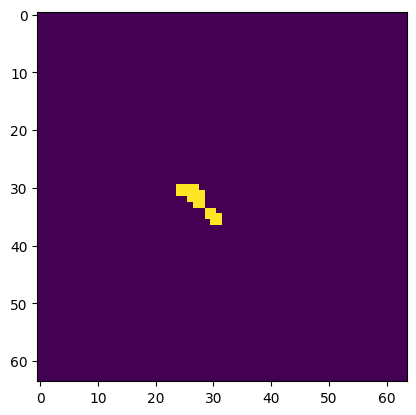

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
error with: cp-0370.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0119.weights.h5


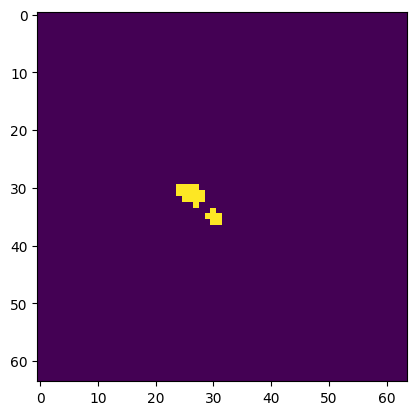

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
cp-0109.weights.h5


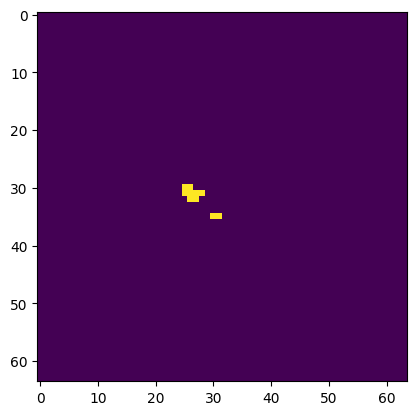

error with: cp-0400.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0171.weights.h5


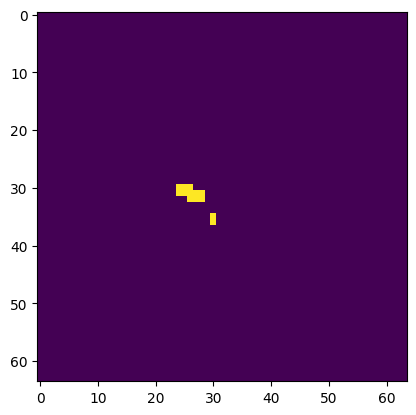

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0196.weights.h5


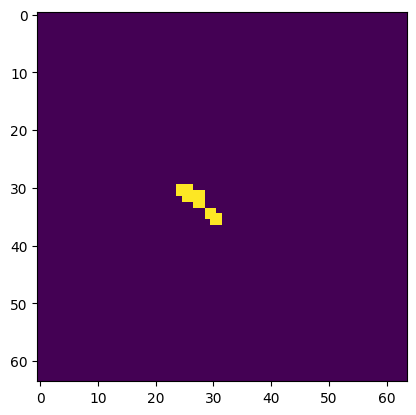

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0182.weights.h5


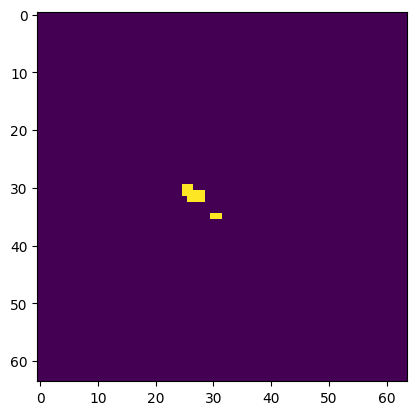

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0175.weights.h5


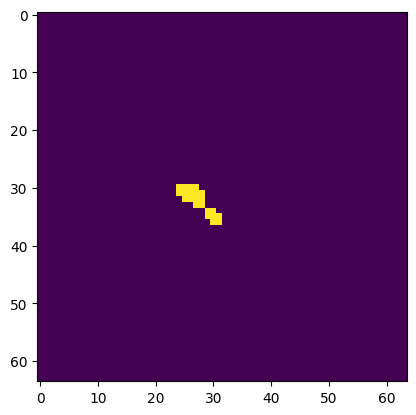

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0105.weights.h5


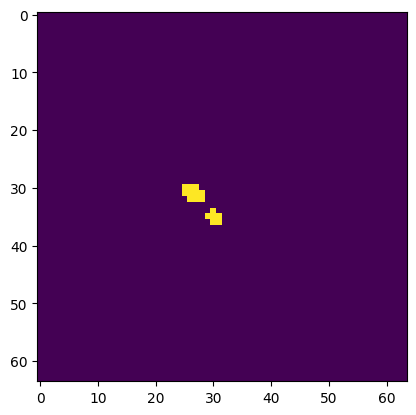

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0129.weights.h5


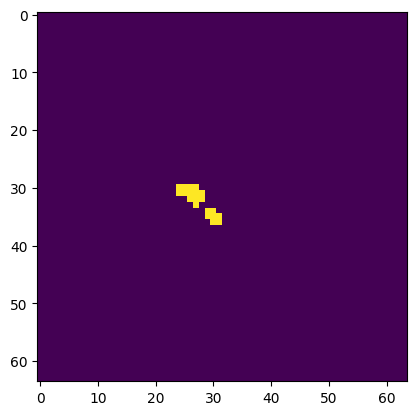

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0131.weights.h5


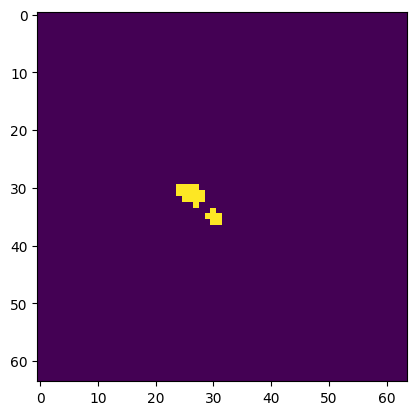

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0138.weights.h5


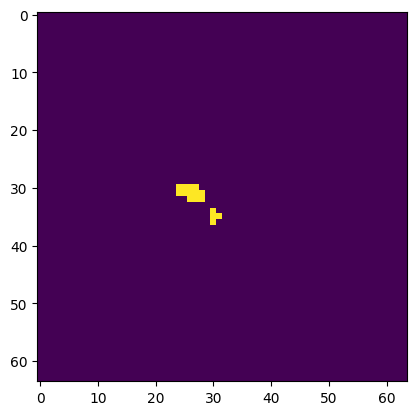

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0146.weights.h5


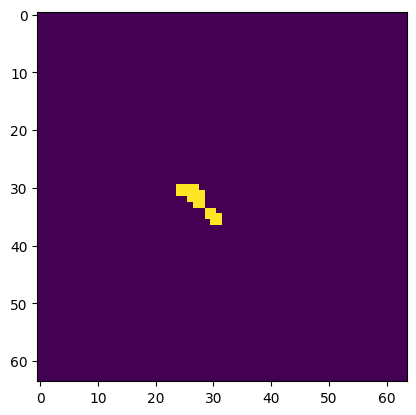

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0145.weights.h5


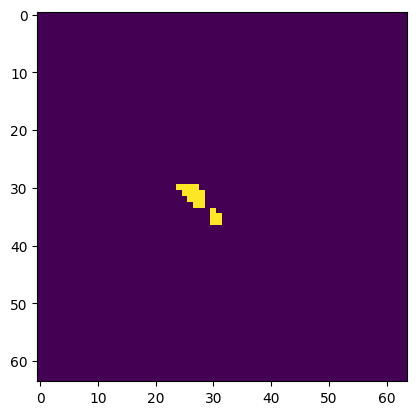

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0127.weights.h5


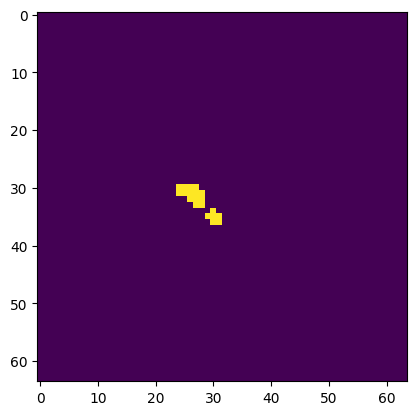

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0113.weights.h5


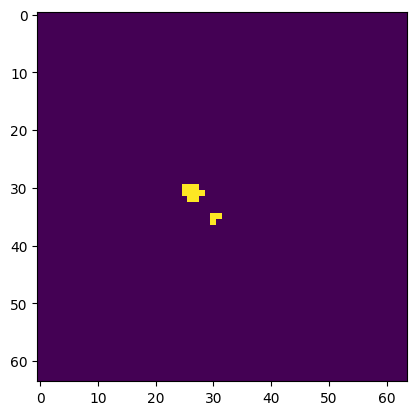

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0096.weights.h5


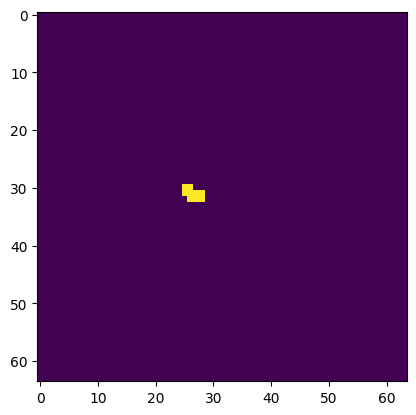

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0139.weights.h5


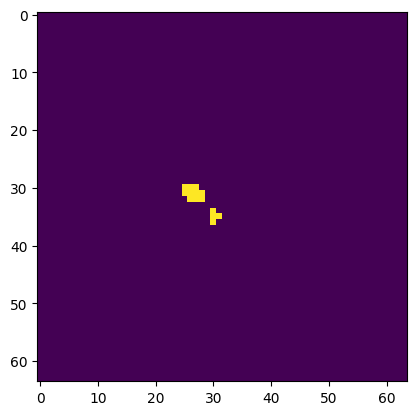

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0089.weights.h5


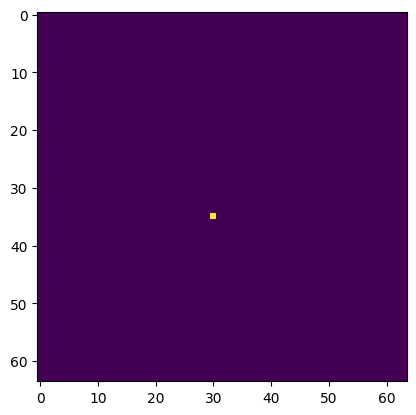

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0082.weights.h5


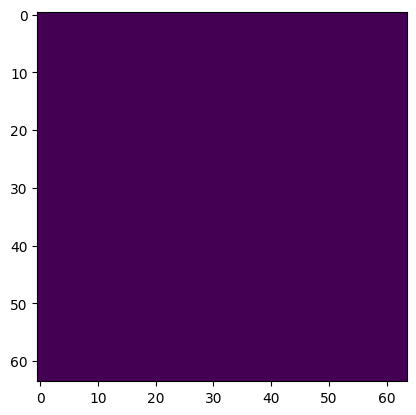

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0174.weights.h5


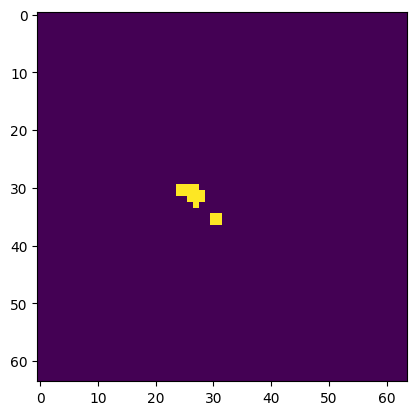

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
cp-0191.weights.h5


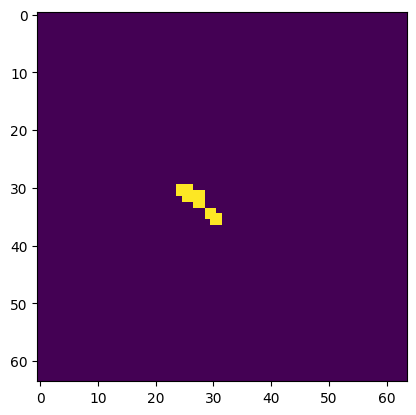

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0092.weights.h5


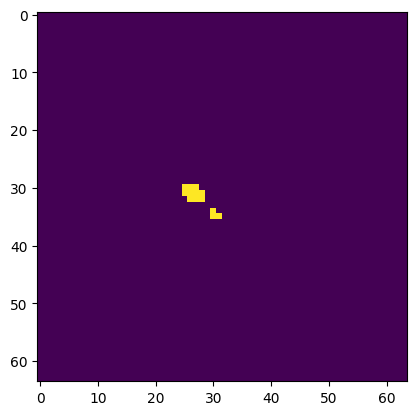

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0112.weights.h5


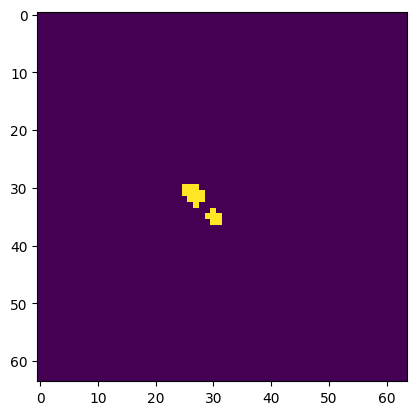

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0187.weights.h5


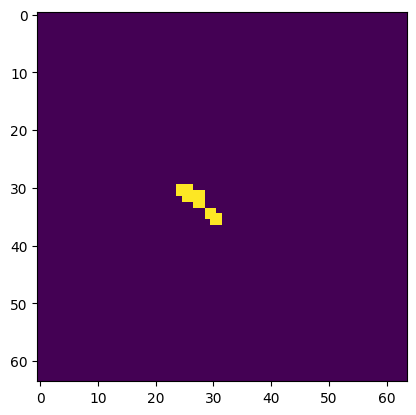

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0155.weights.h5


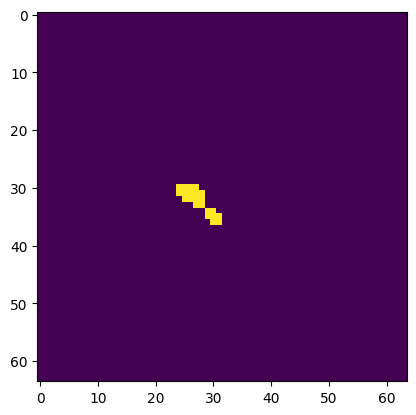

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
cp-0072.weights.h5


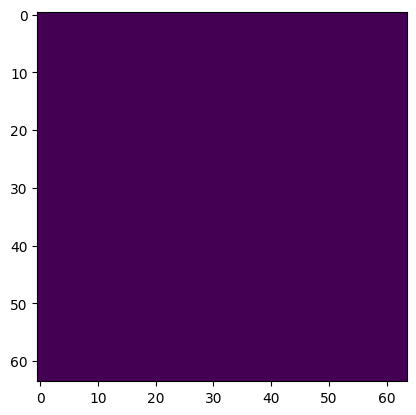

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0194.weights.h5


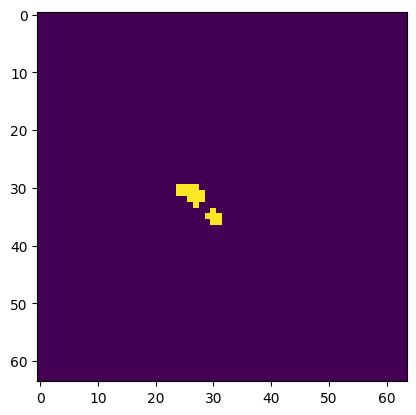

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0166.weights.h5


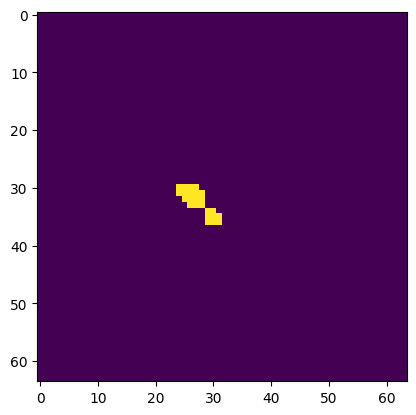

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
cp-0009.weights.h5


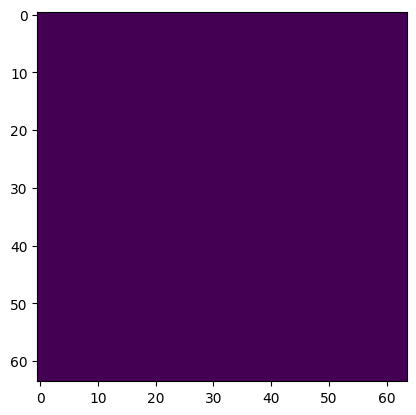

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
cp-0162.weights.h5


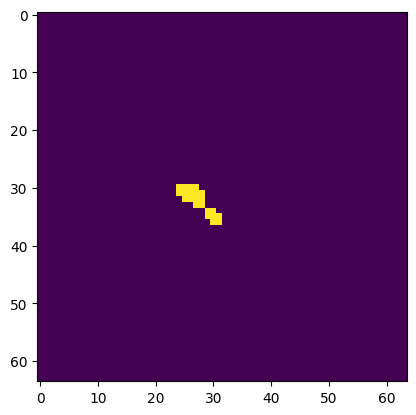

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0157.weights.h5


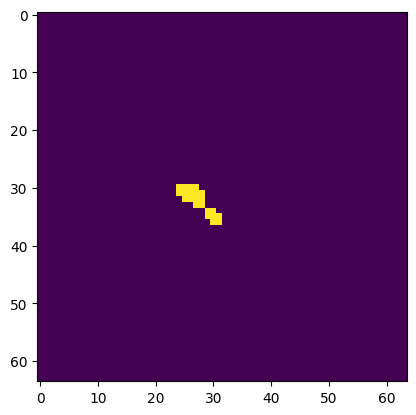

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0154.weights.h5


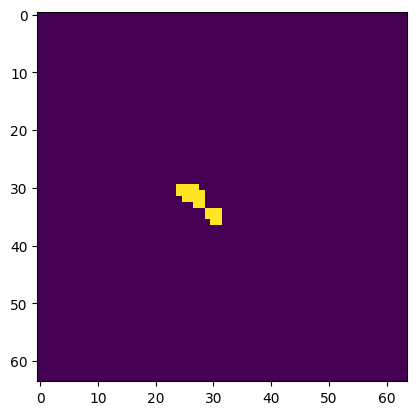

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0134.weights.h5


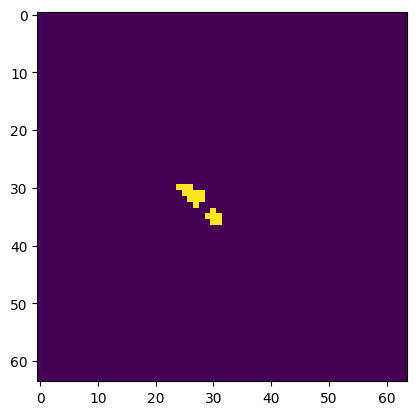

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0178.weights.h5


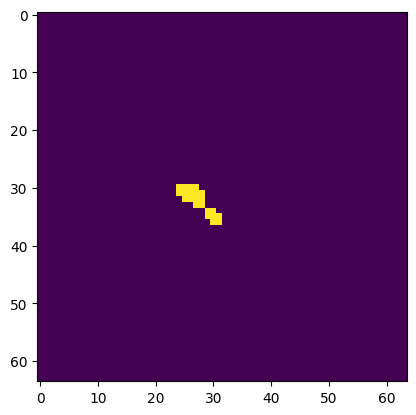

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0062.weights.h5


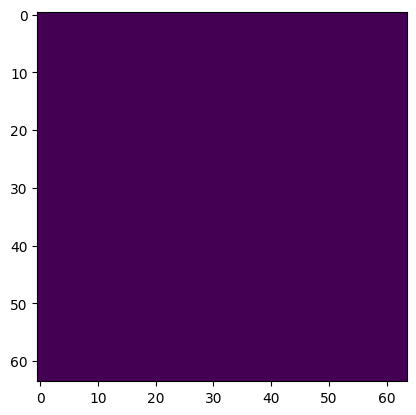

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
error with: cp-0350.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0184.weights.h5


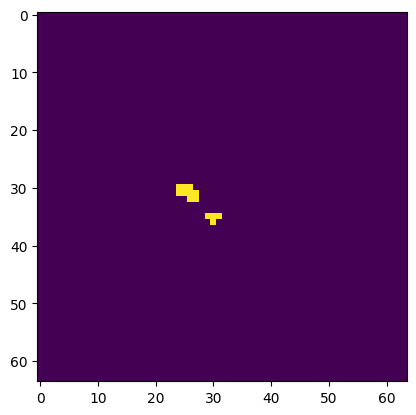

error with: cp-0310.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0189.weights.h5


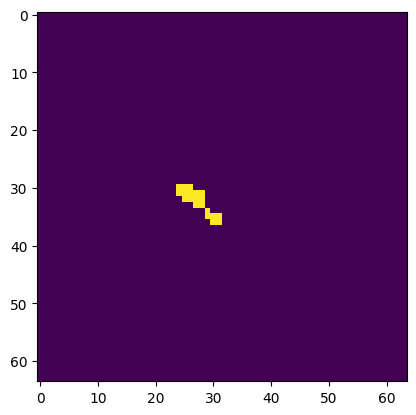

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0193.weights.h5


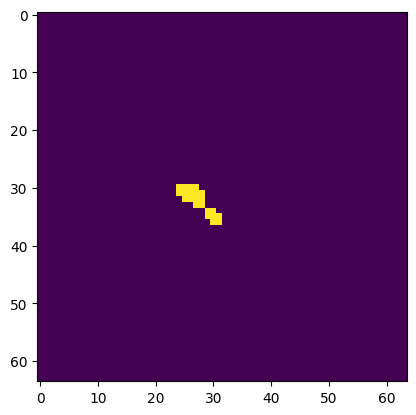

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0116.weights.h5


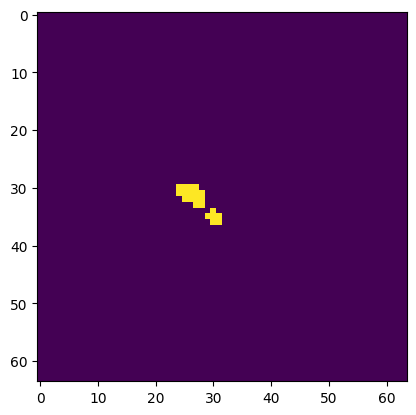

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0137.weights.h5


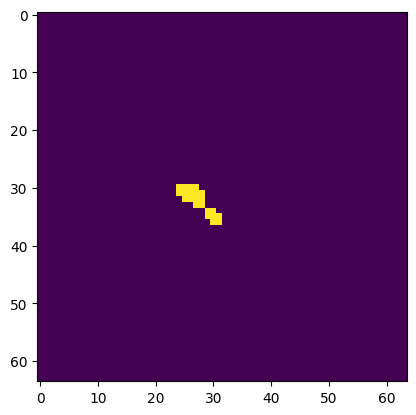

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0030.weights.h5


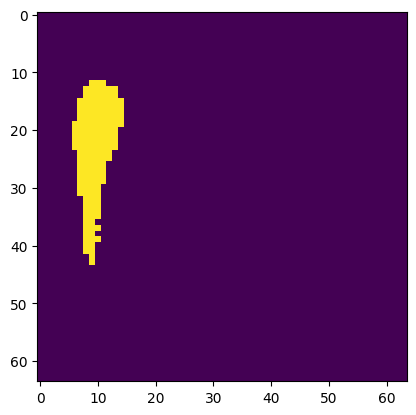

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
cp-0188.weights.h5


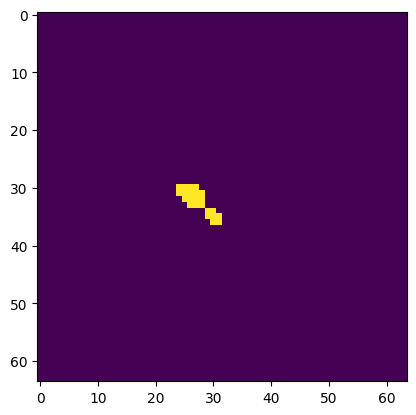

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0165.weights.h5


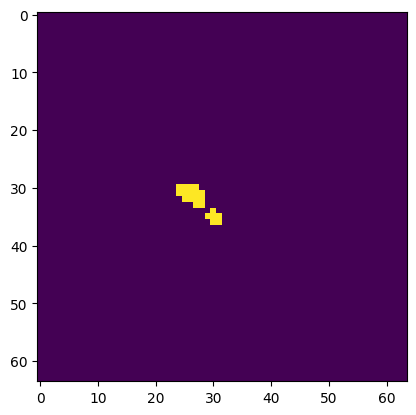

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0161.weights.h5


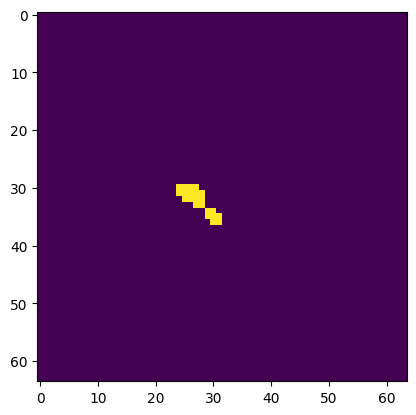

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
error with: cp-0210.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0035.weights.h5


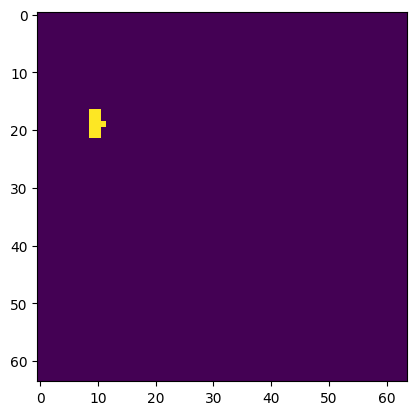

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0094.weights.h5


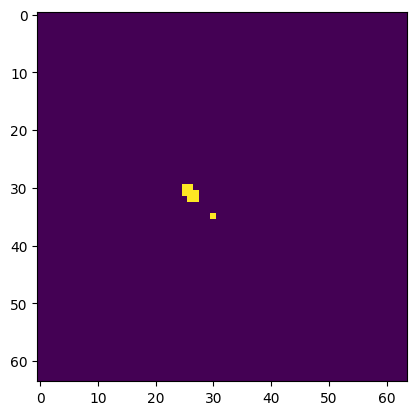

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0168.weights.h5


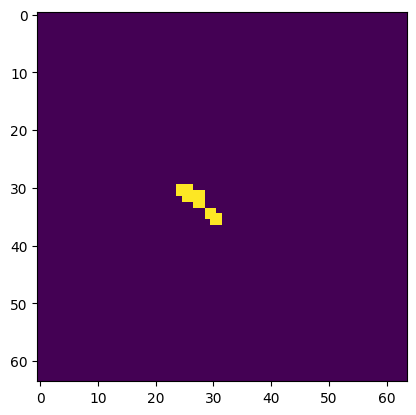

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0099.weights.h5


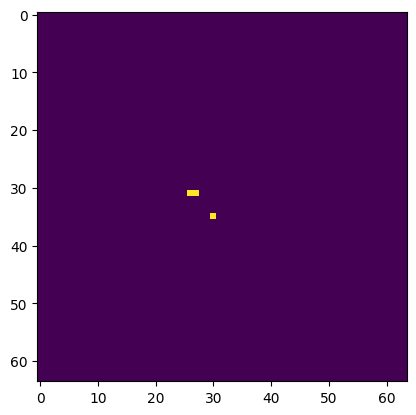

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0114.weights.h5


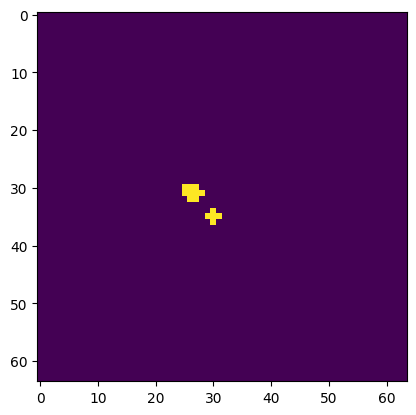

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0115.weights.h5


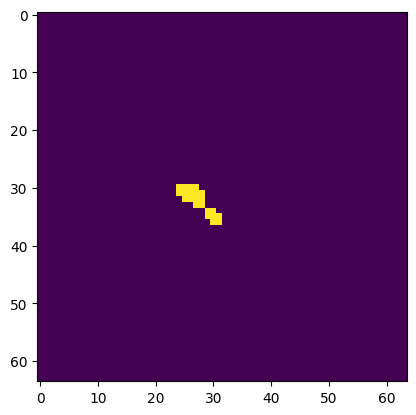

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0084.weights.h5


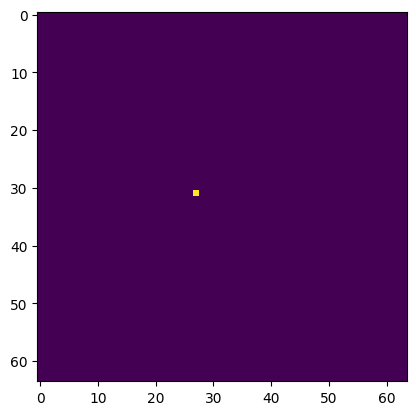

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
cp-0156.weights.h5


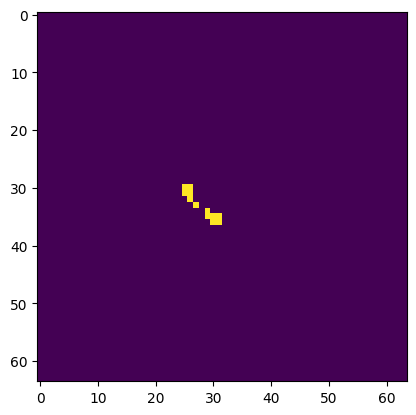

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0028.weights.h5


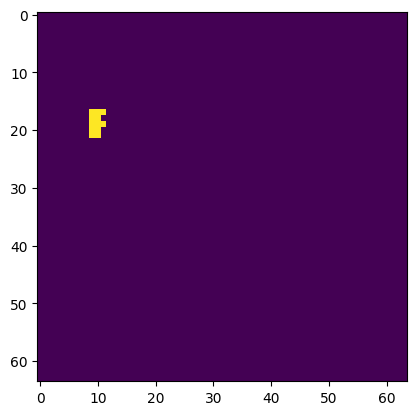

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0143.weights.h5


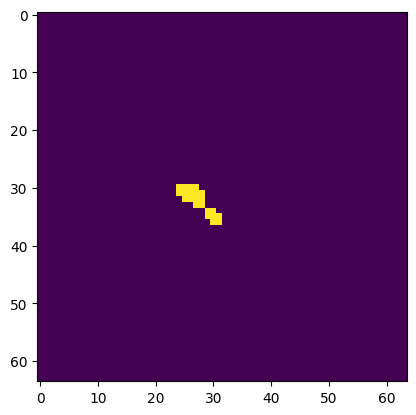

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0195.weights.h5


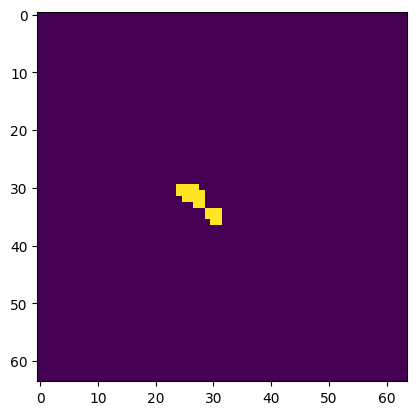

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0124.weights.h5


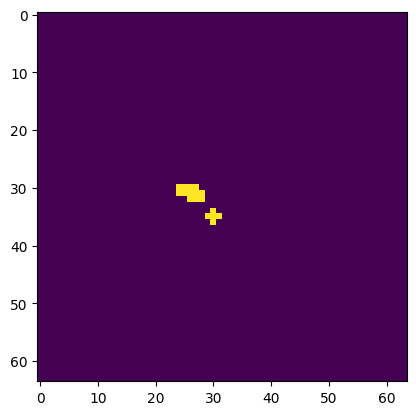

error with: cp-0240.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0117.weights.h5


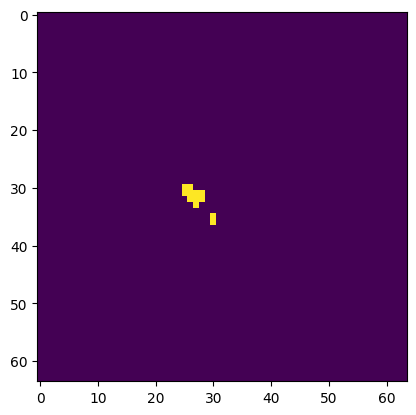

error with: cp-0390.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0172.weights.h5


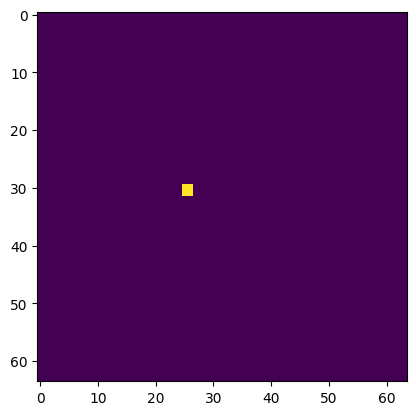

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
error with: cp-0270.weights.h5
error with: cp-0320.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0039.weights.h5


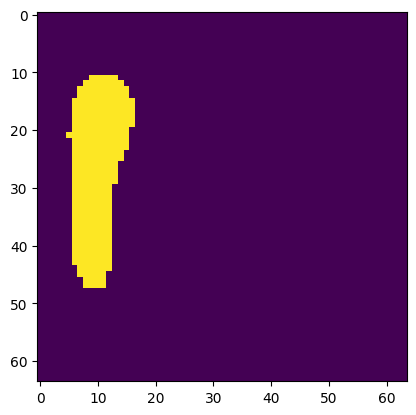

error with: cp-0290.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0153.weights.h5


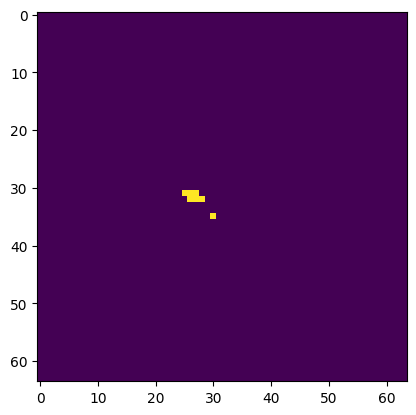

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0176.weights.h5


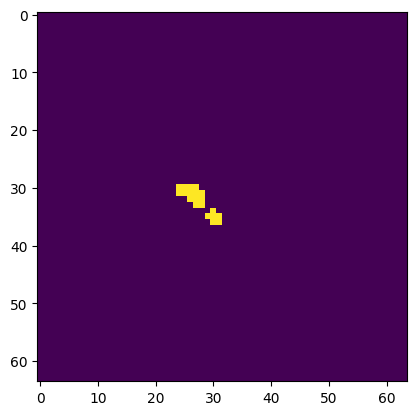

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
cp-0197.weights.h5


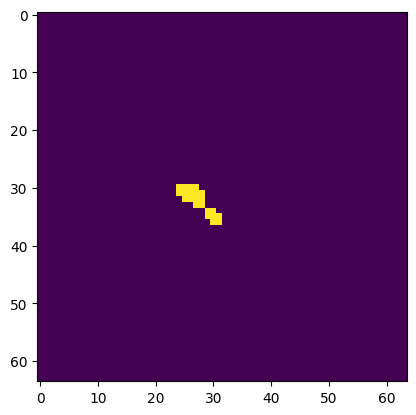

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0170.weights.h5


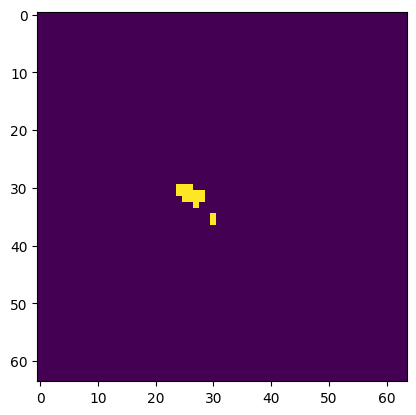

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0100.weights.h5


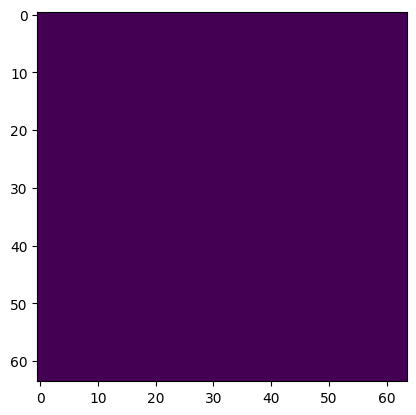

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0200.weights.h5


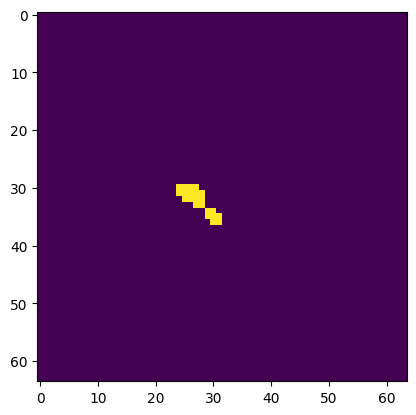

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
error with: cp-0340.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0073.weights.h5


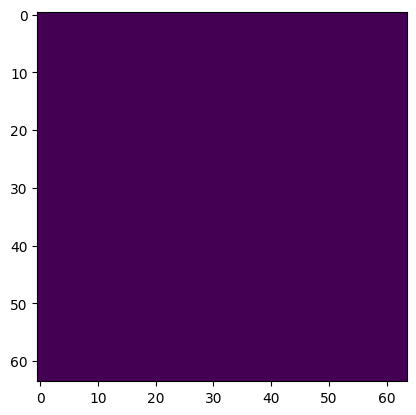

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0148.weights.h5


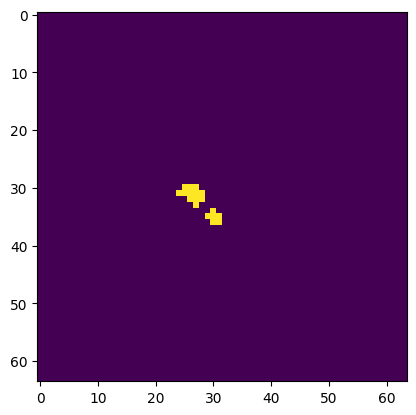

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0159.weights.h5


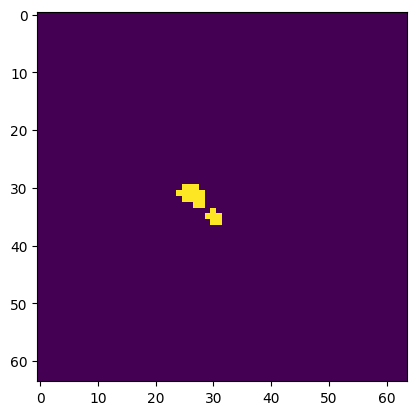

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0186.weights.h5


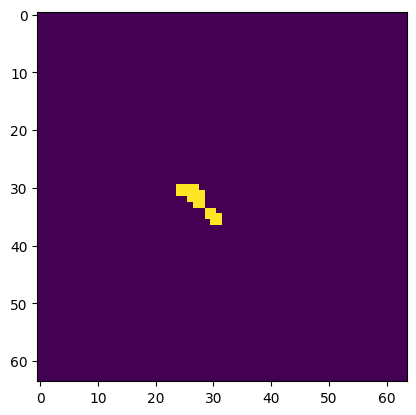

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0179.weights.h5


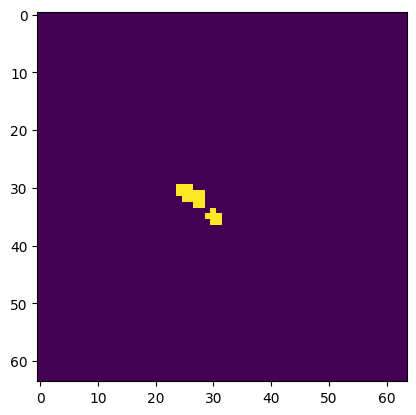

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0104.weights.h5


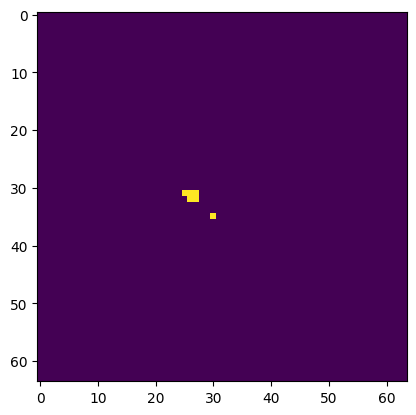

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0027.weights.h5


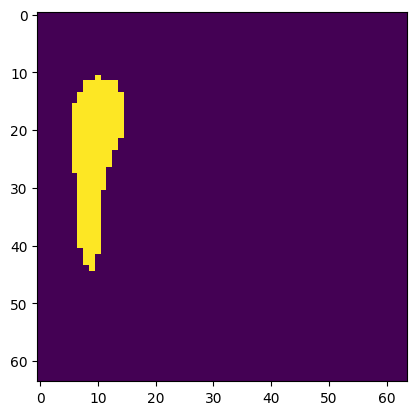

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0122.weights.h5


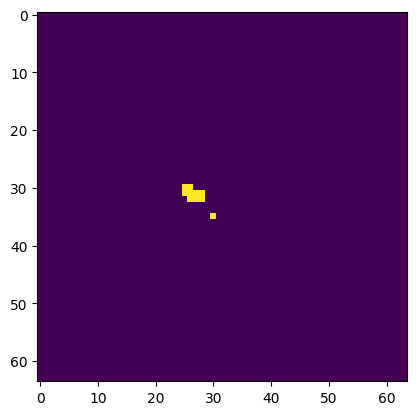

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [6]:


X, _ = nrrd.read("./inputs/2_volume_5.nrrd")
X = np.array([X]).astype(np.float32)
X = np.expand_dims(X, -1)

for checkpoint in os.listdir("./checkpoints"):
    try:
        model.load_weights("./checkpoints/"+checkpoint)
    
        
        y = model.predict(X)
        y = y[0]
        # y = np.argmax(y, axis=1)
        y[y>=0.5]=1
        y[y<0.5]=0
        if len(np.unique(y)) > 1:
            # output = np.reshape(y, (64, 64, 64)).astype(np.uint8)
            print(checkpoint)
            plt.imshow(y[:,:,23]), plt.show()
    except:
        print("error with: " + checkpoint)

In [69]:

gt, _ = nrrd.read("./test_data/gt/18_volume_5.nrrd")
X, _ = nrrd.read("./test_data/inputs/18_volume_5.nrrd")
X = np.array([X]).astype(np.float32)
X = np.expand_dims(X, -1)

model.load_weights("./checkpoints/cp-0140.weights.h5")


y = model.predict(X)
y = y[0]
y[y>=0.5]=1
y[y<0.5]=0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


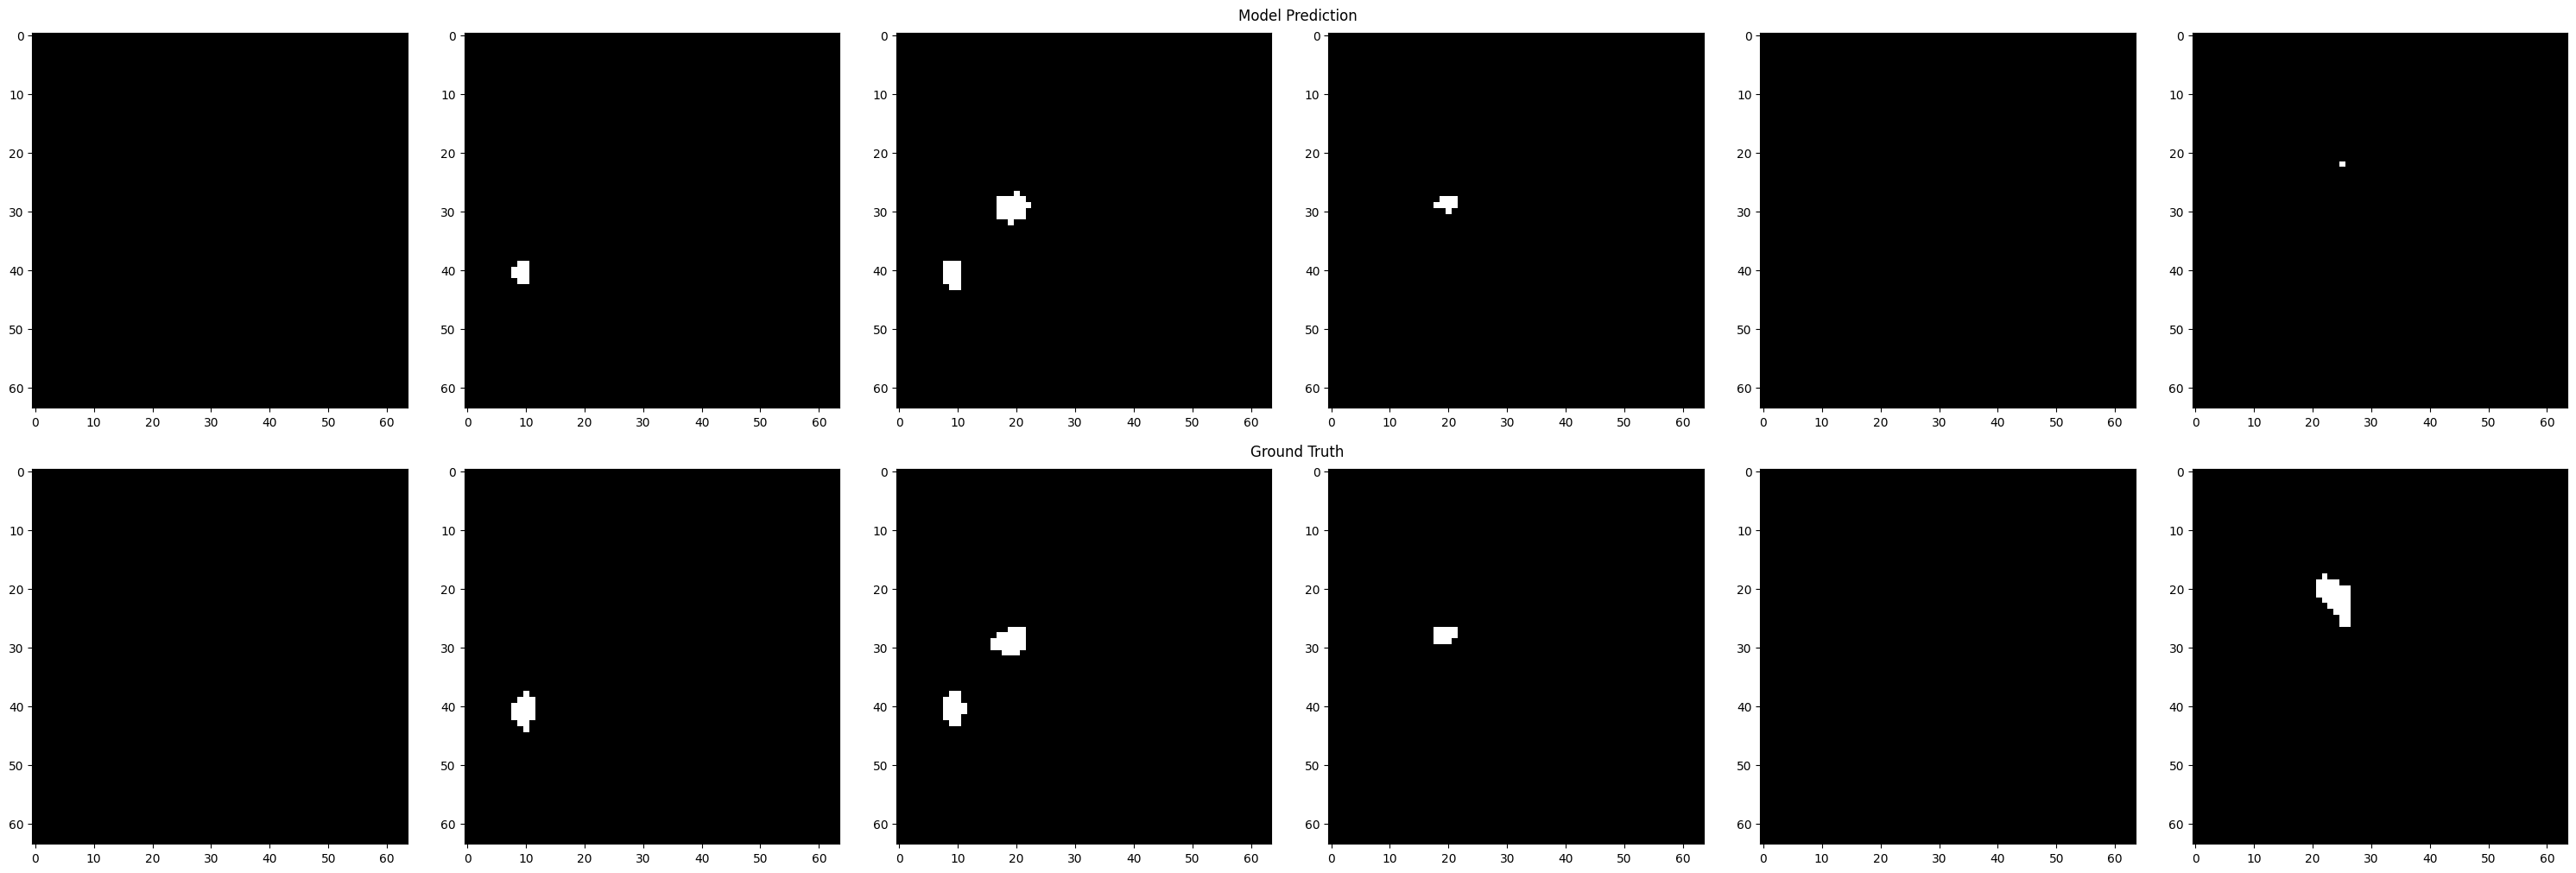

In [70]:
fig = plt.figure(constrained_layout=True, figsize=(30,10))
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)

pred_axs = subfigs[0].subplots(nrows=1, ncols=6)
subfigs[0].suptitle("Model Prediction")
pred_axs[0].imshow(y[:,:,20], cmap='gray')
pred_axs[1].imshow(y[:,:,21], cmap='gray')
pred_axs[2].imshow(y[:,:,22], cmap='gray')
pred_axs[3].imshow(y[:,:,23], cmap='gray')
pred_axs[4].imshow(y[:,:,24], cmap='gray')
pred_axs[5].imshow(y[:,:,25], cmap='gray')

gt_axs = subfigs[1].subplots(nrows=1, ncols=6)
subfigs[1].suptitle("Ground Truth")
gt_axs[0].imshow(gt[:,:,20], cmap='gray')
gt_axs[1].imshow(gt[:,:,21], cmap='gray')
gt_axs[2].imshow(gt[:,:,22], cmap='gray')
gt_axs[3].imshow(gt[:,:,23], cmap='gray')
gt_axs[4].imshow(gt[:,:,24], cmap='gray')
gt_axs[5].imshow(gt[:,:,25], cmap='gray')

fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


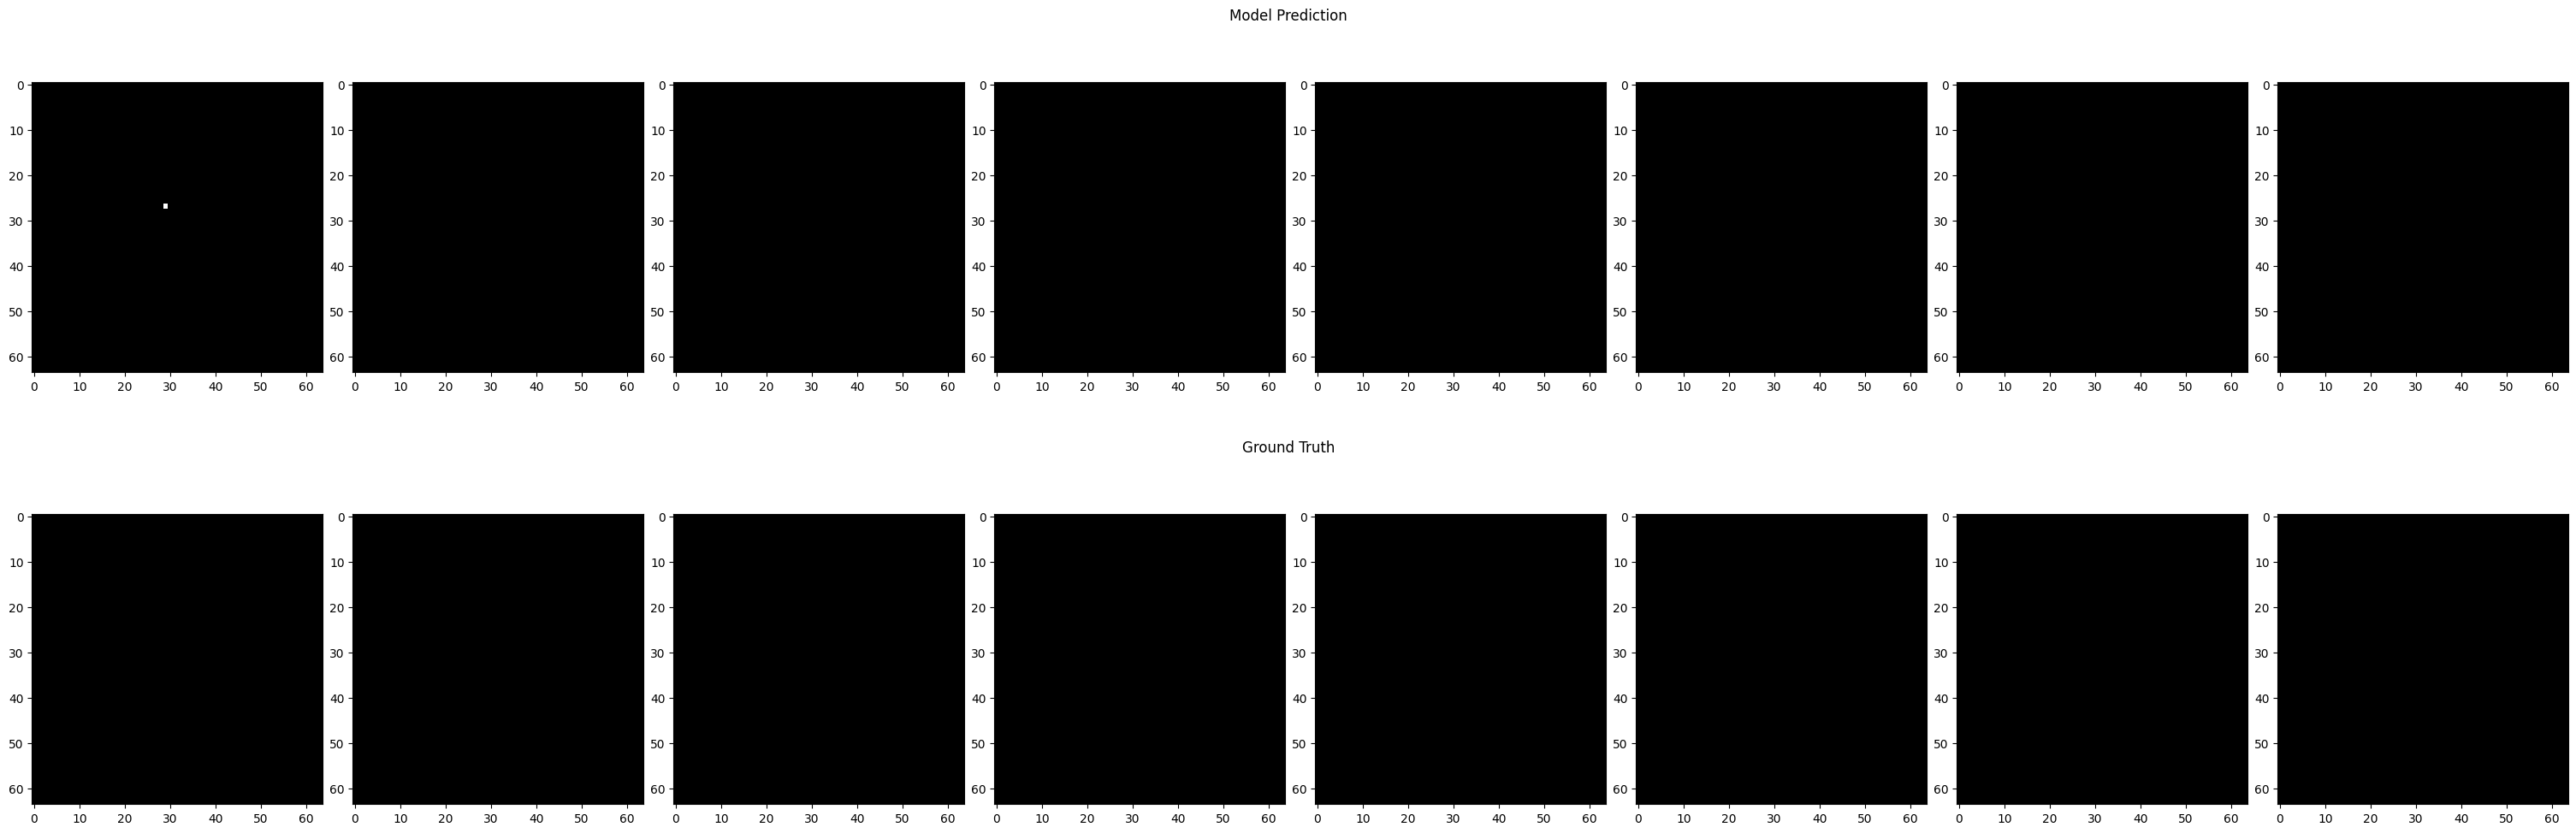

In [10]:
gt, _ = nrrd.read("./test_data/gt/18_volume_1.nrrd")
X, _ = nrrd.read("./test_data/inputs/18_volume_1.nrrd")
X = np.array([X]).astype(np.float32)
X = np.expand_dims(X, -1)

model.load_weights("./checkpoints/cp-0020.weights.h5")


y = model.predict(X)
y = y[0]
y[y>=0.5]=1
y[y<0.5]=0

fig = plt.figure(constrained_layout=True, figsize=(30,10))
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)

pred_axs = subfigs[0].subplots(nrows=1, ncols=8)
subfigs[0].suptitle("Model Prediction")
pred_axs[0].imshow(y[:,:,20], cmap='gray')
pred_axs[1].imshow(y[:,:,21], cmap='gray')
pred_axs[2].imshow(y[:,:,22], cmap='gray')
pred_axs[3].imshow(y[:,:,23], cmap='gray')
pred_axs[4].imshow(y[:,:,24], cmap='gray')
pred_axs[5].imshow(y[:,:,25], cmap='gray')
pred_axs[6].imshow(y[:,:,26], cmap='gray')
pred_axs[7].imshow(y[:,:,27], cmap='gray')

gt_axs = subfigs[1].subplots(nrows=1, ncols=8)
subfigs[1].suptitle("Ground Truth")
gt_axs[0].imshow(gt[:,:,20], cmap='gray')
gt_axs[1].imshow(gt[:,:,21], cmap='gray')
gt_axs[2].imshow(gt[:,:,22], cmap='gray')
gt_axs[3].imshow(gt[:,:,23], cmap='gray')
gt_axs[4].imshow(gt[:,:,24], cmap='gray')
gt_axs[5].imshow(gt[:,:,25], cmap='gray')
gt_axs[6].imshow(gt[:,:,26], cmap='gray')
gt_axs[7].imshow(gt[:,:,27], cmap='gray')
fig.show()

/home/kevin.wang/miniconda3/envs/cactas/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 130 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1718717542.705912 1372103 service.cc:145] XLA service 0x737458016210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718717542.705970 1372103 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-06-18 09:32:22.740652: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-18 09:32:22.852642: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1718717545.512958 1372103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/tmp/ipykernel_1371887/3740365650.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 8, figsize=(8,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

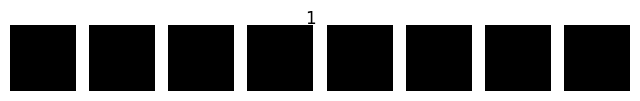

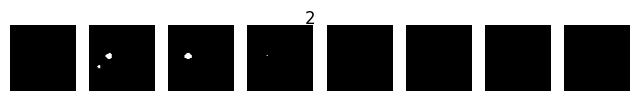

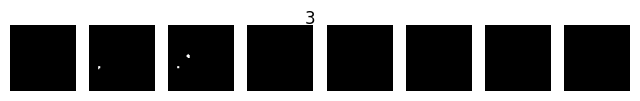

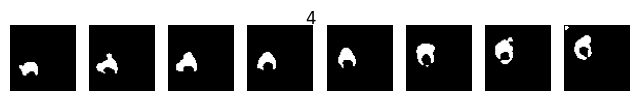

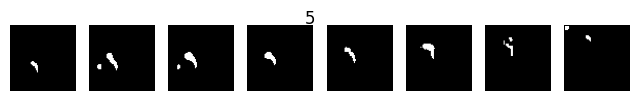

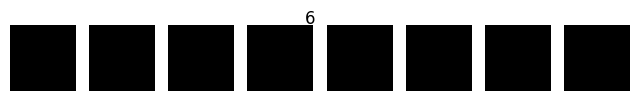

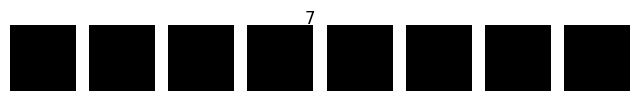

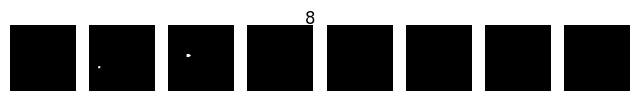

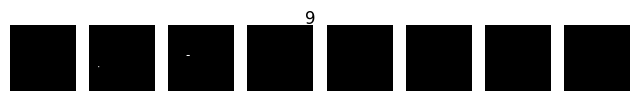

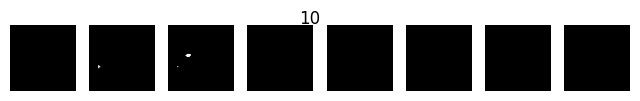

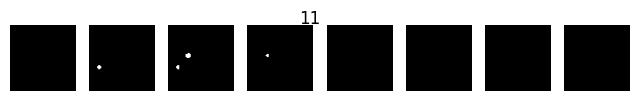

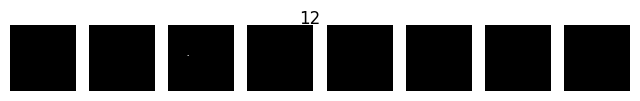

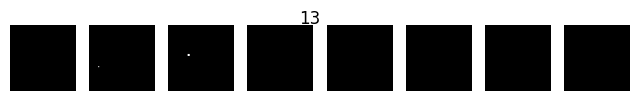

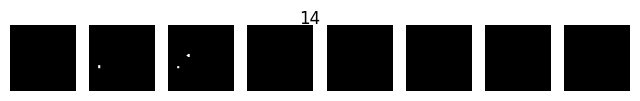

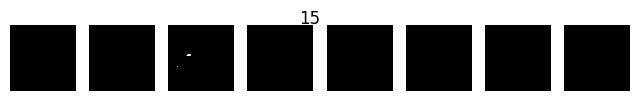

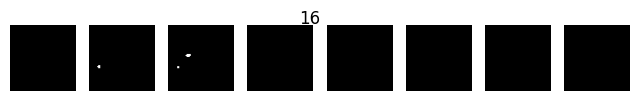

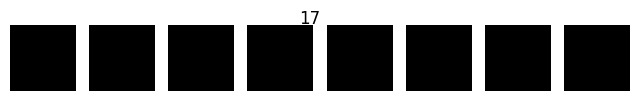

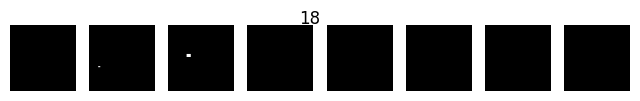

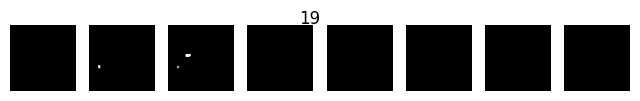

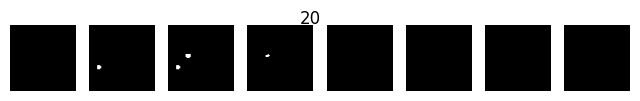

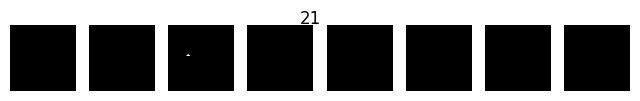

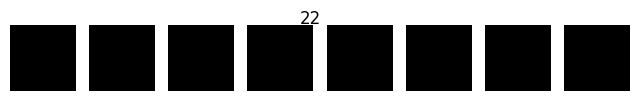

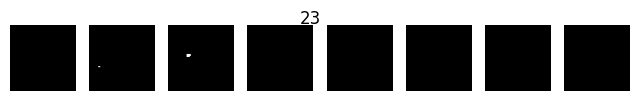

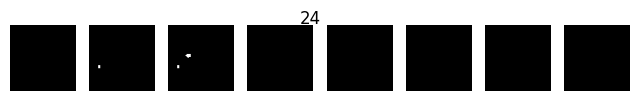

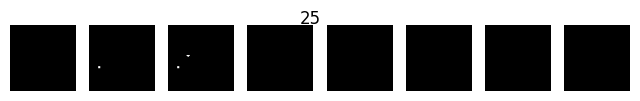

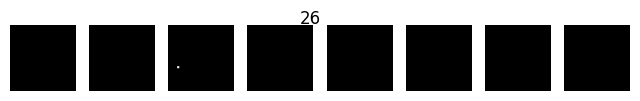

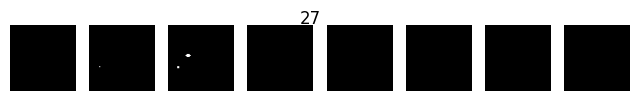

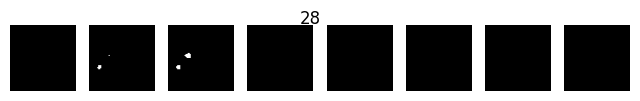

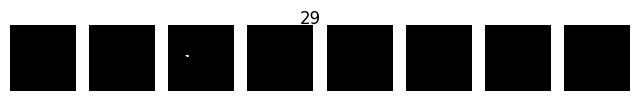

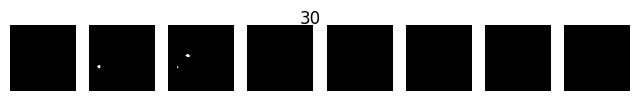

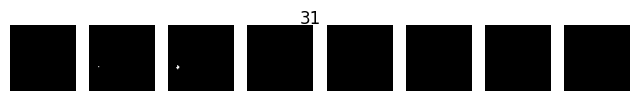

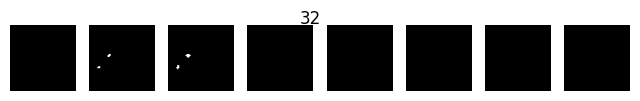

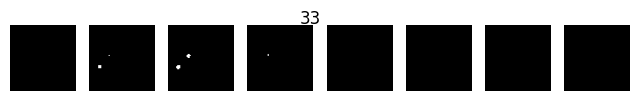

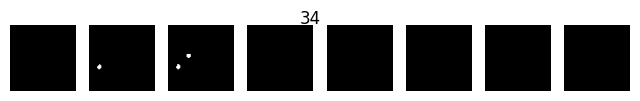

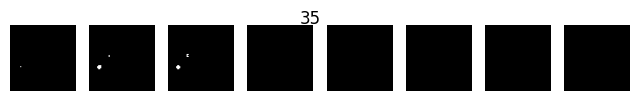

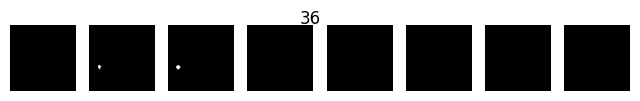

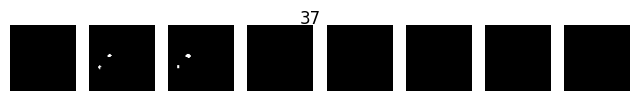

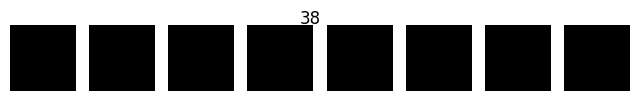

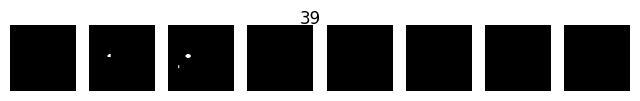

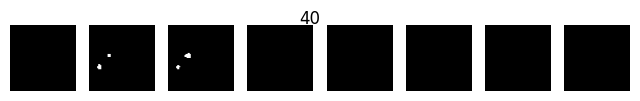

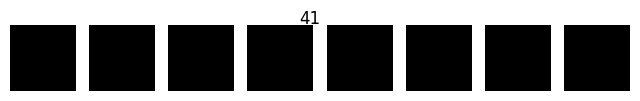

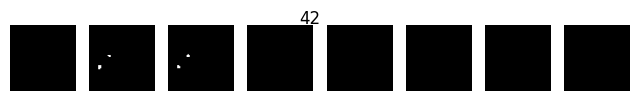

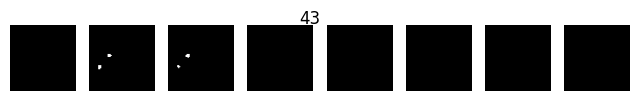

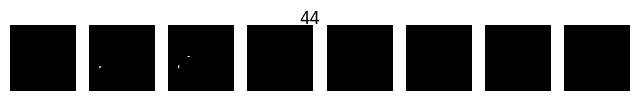

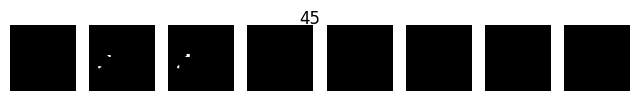

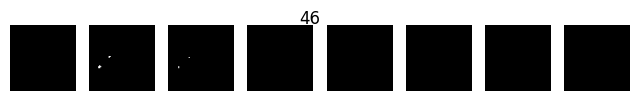

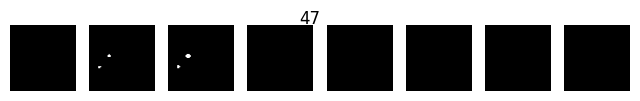

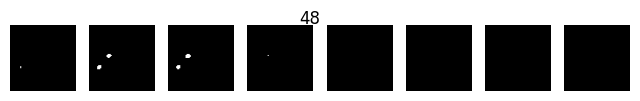

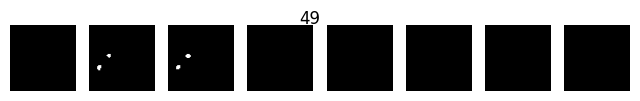

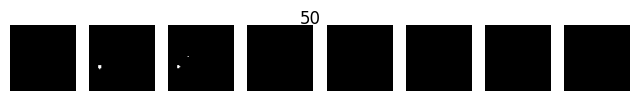

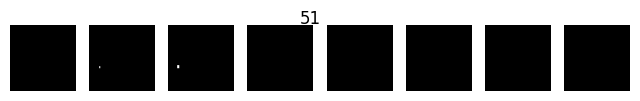

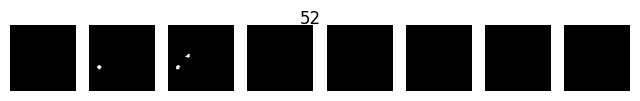

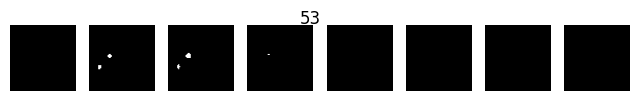

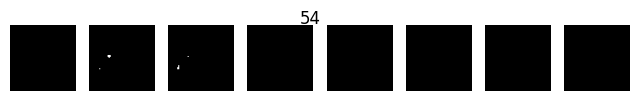

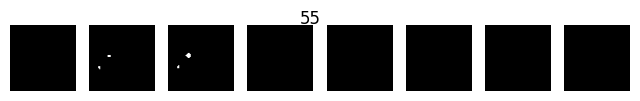

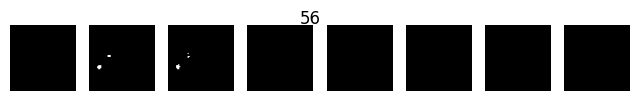

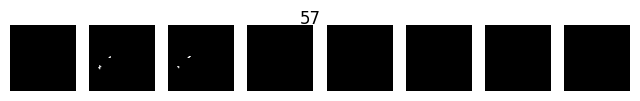

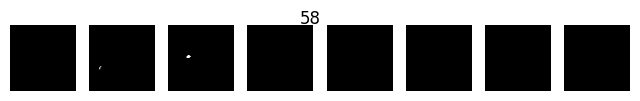

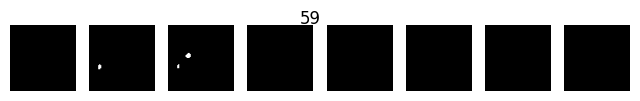

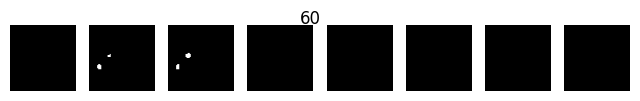

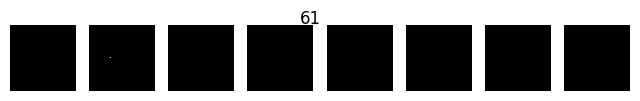

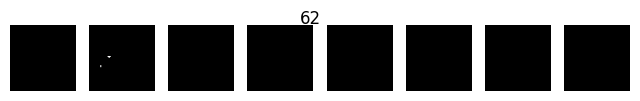

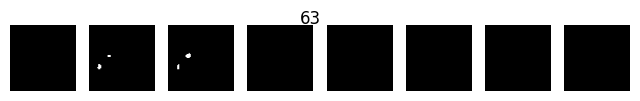

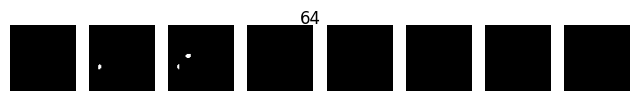

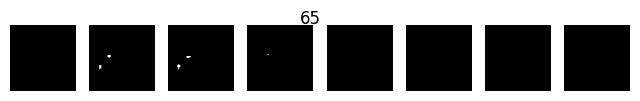

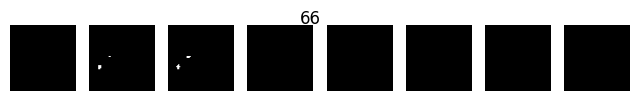

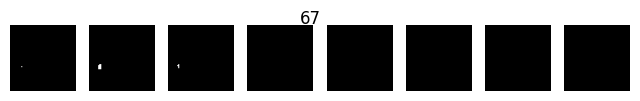

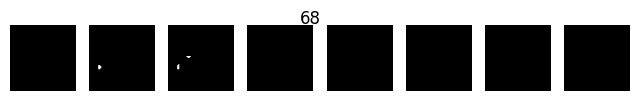

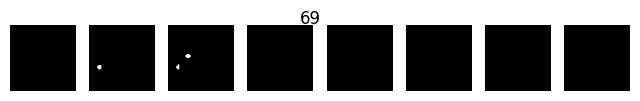

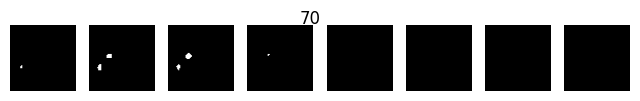

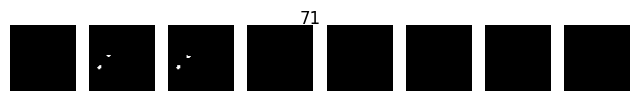

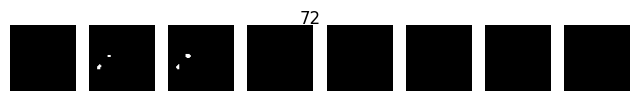

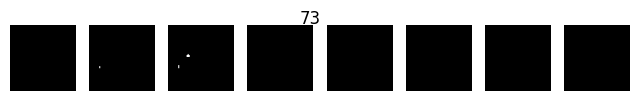

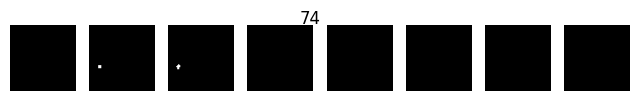

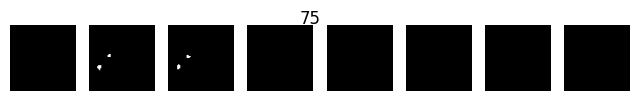

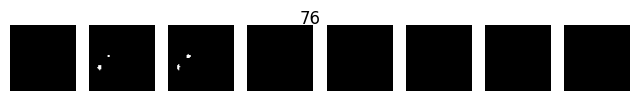

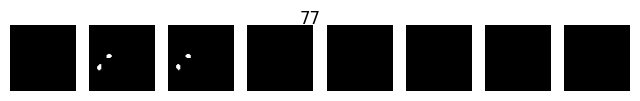

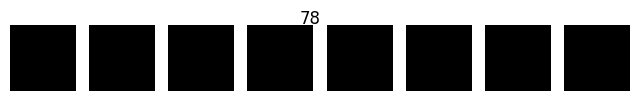

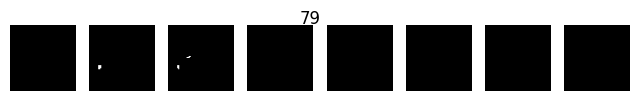

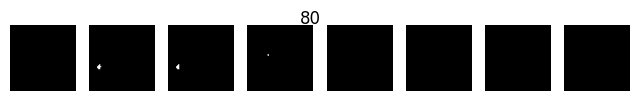

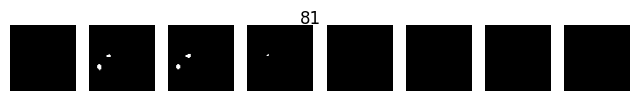

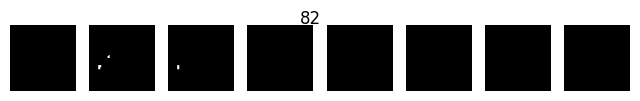

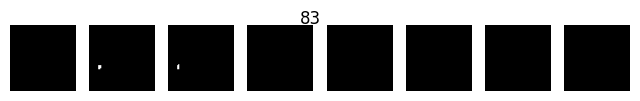

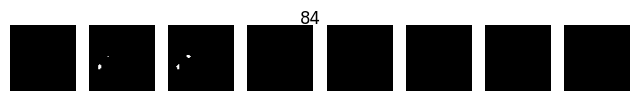

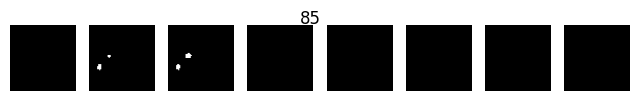

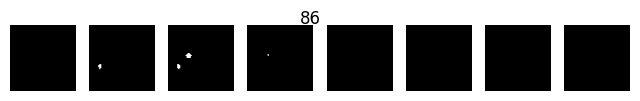

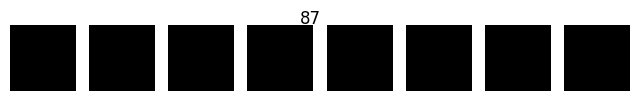

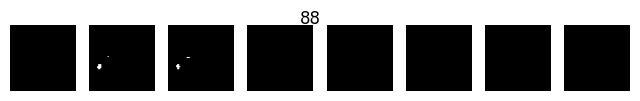

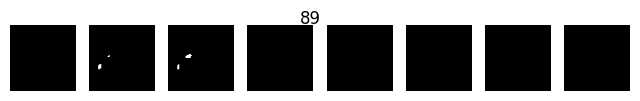

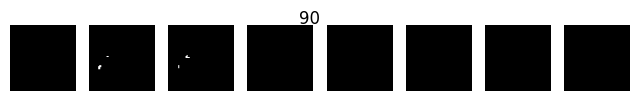

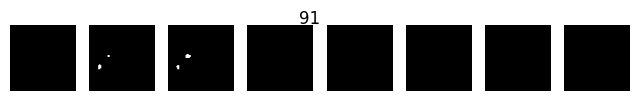

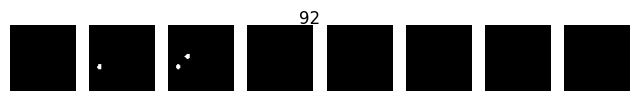

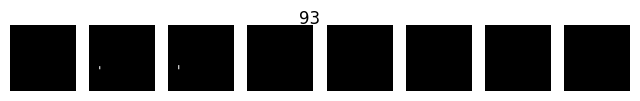

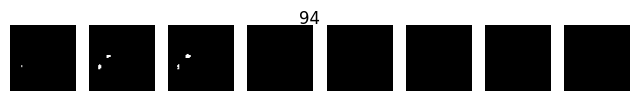

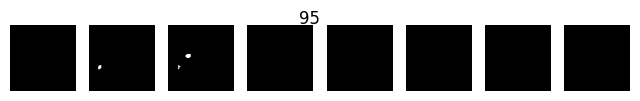

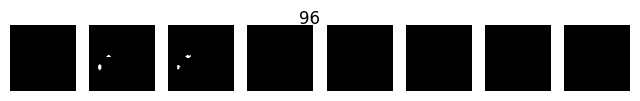

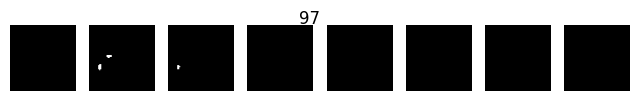

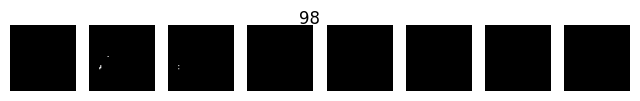

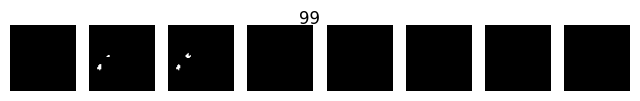

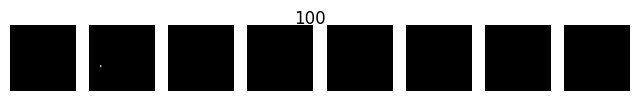

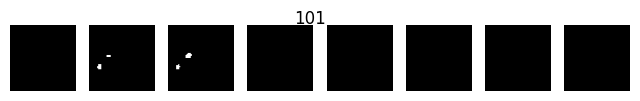

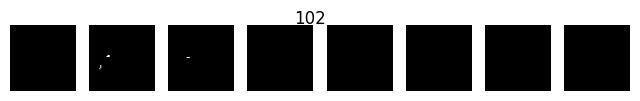

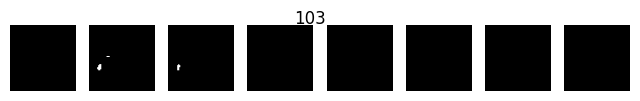

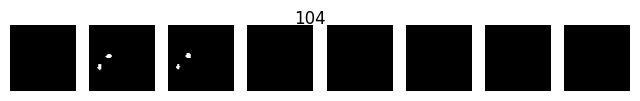

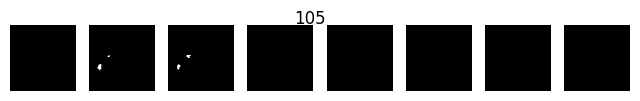

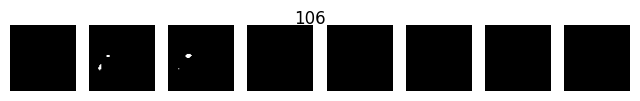

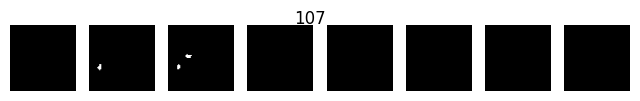

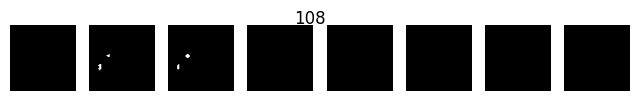

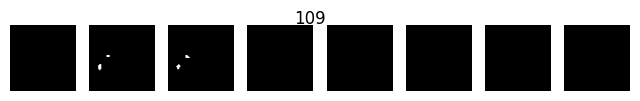

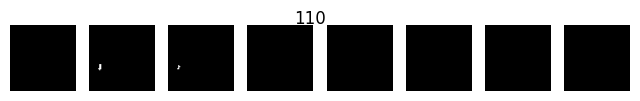

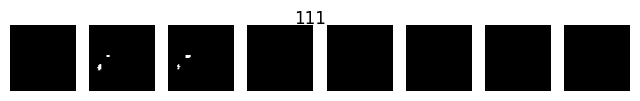

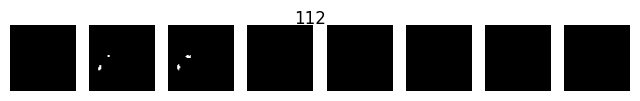

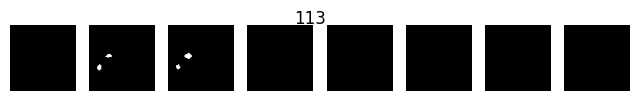

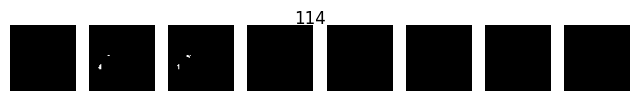

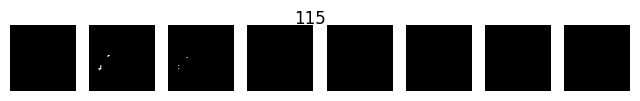

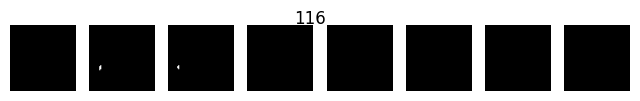

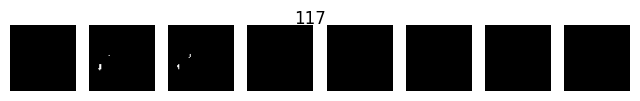

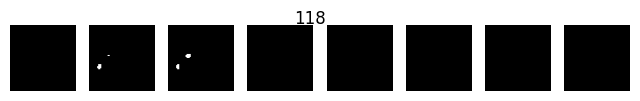

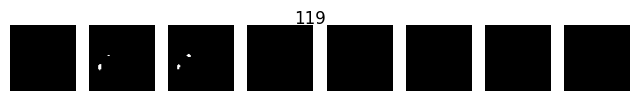

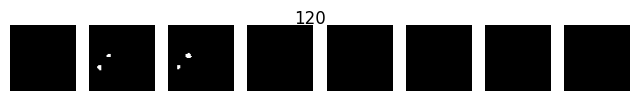

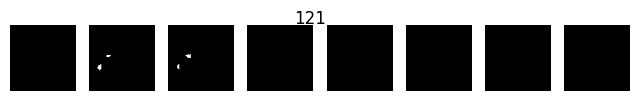

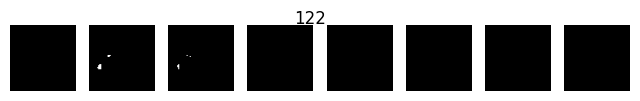

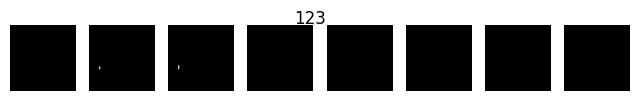

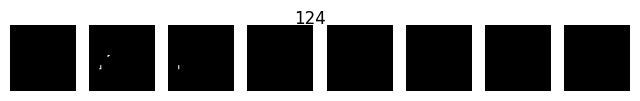

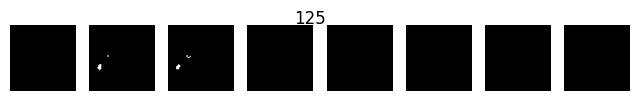

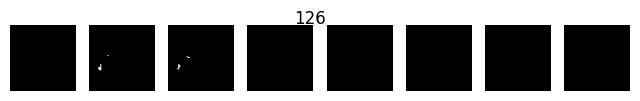

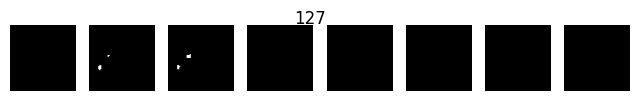

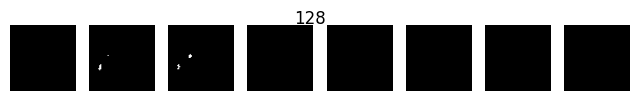

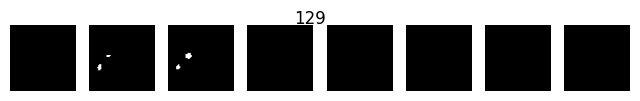

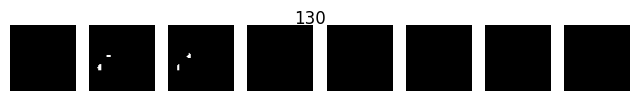

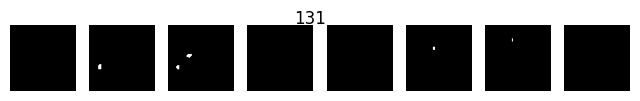

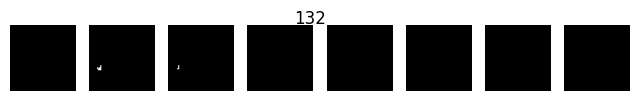

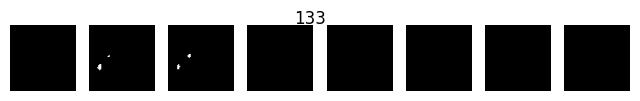

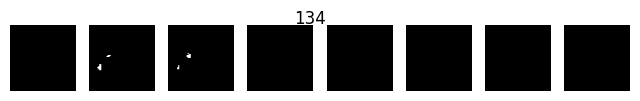

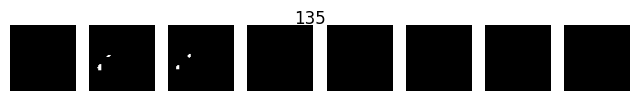

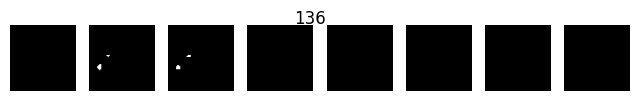

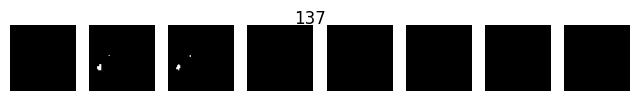

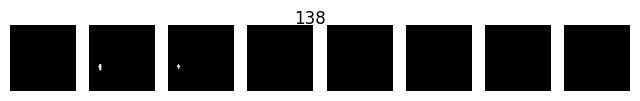

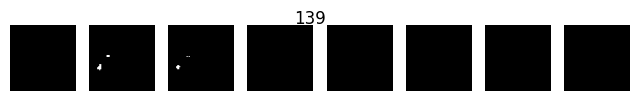

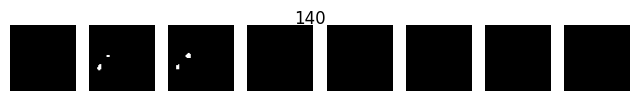

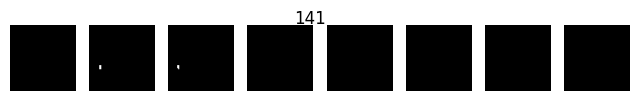

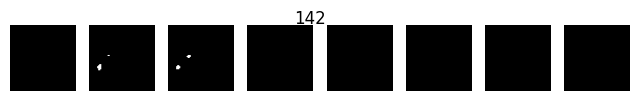

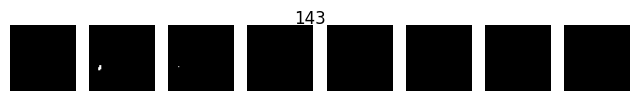

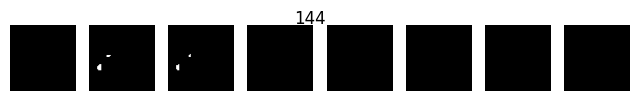

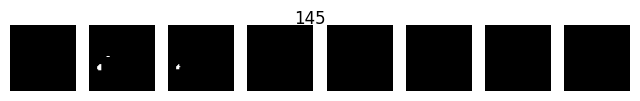

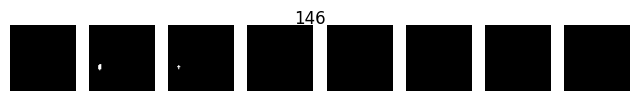

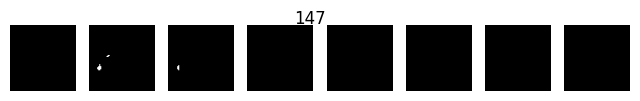

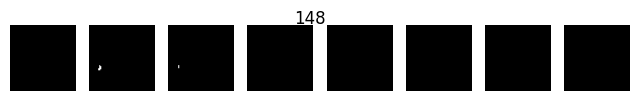

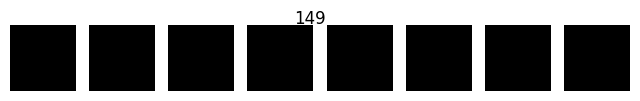

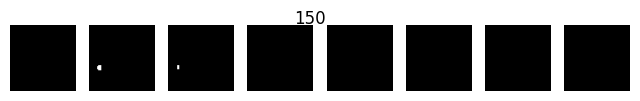

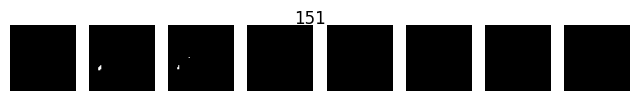

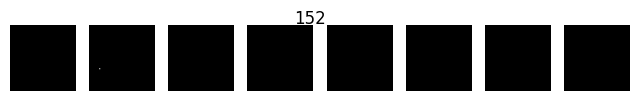

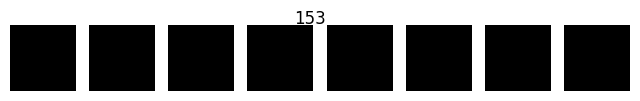

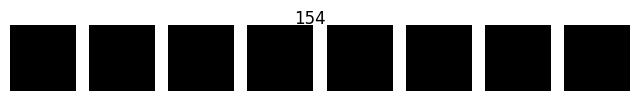

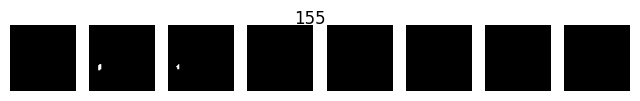

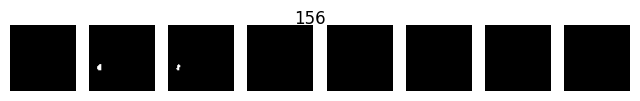

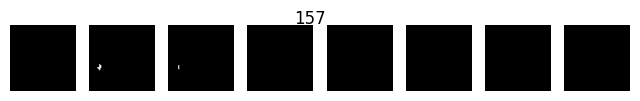

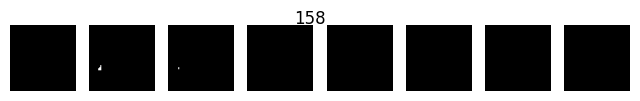

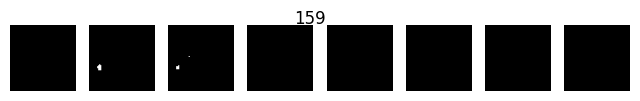

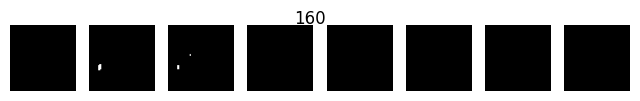

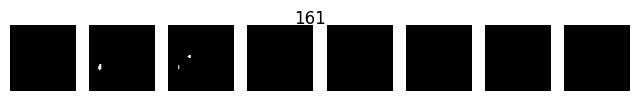

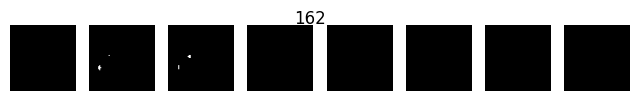

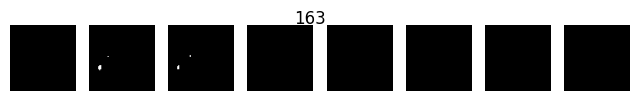

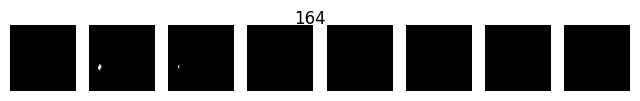

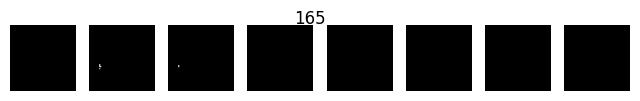

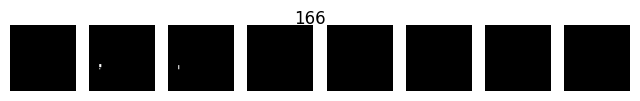

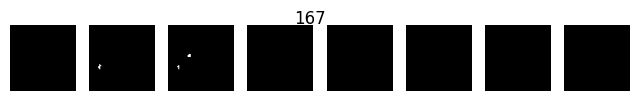

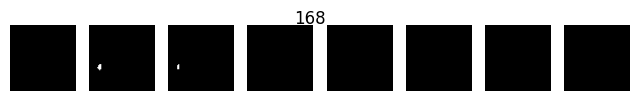

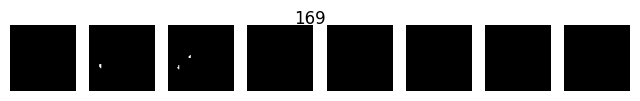

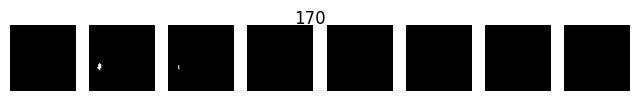

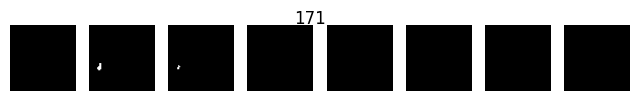

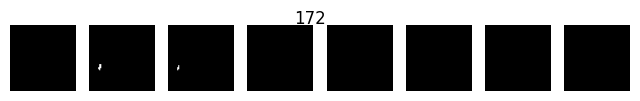

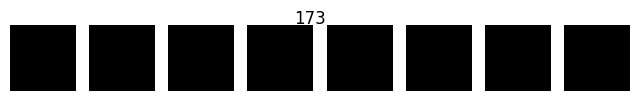

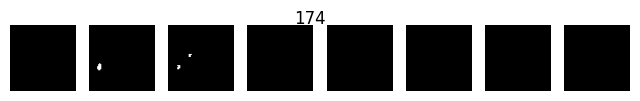

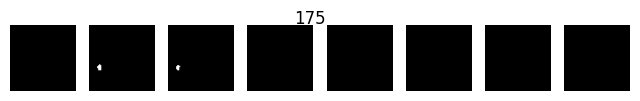

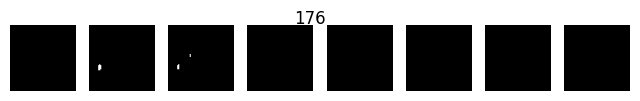

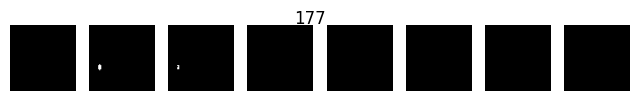

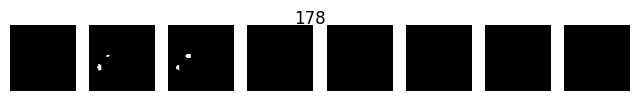

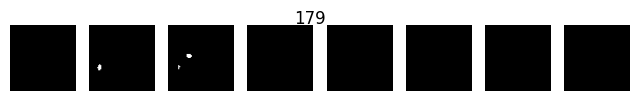

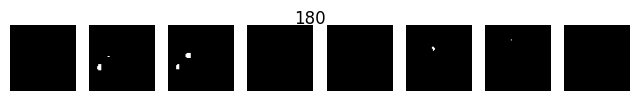

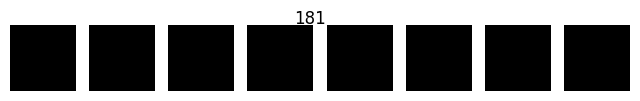

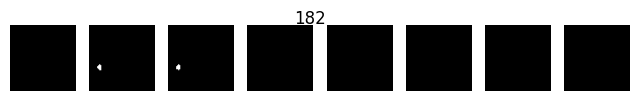

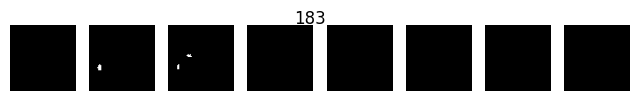

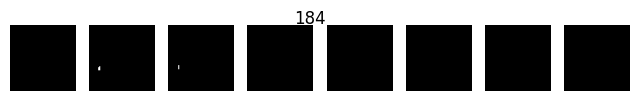

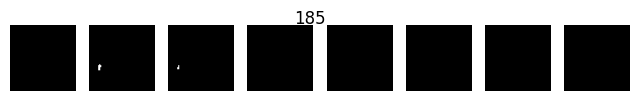

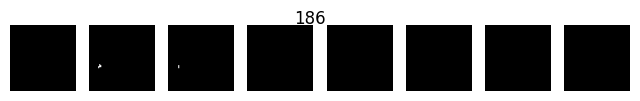

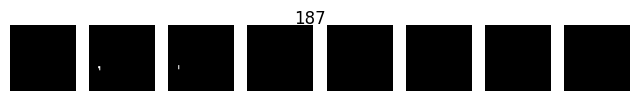

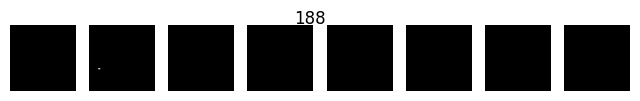

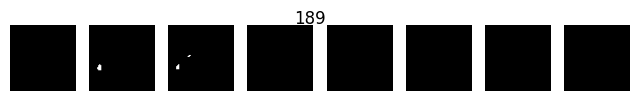

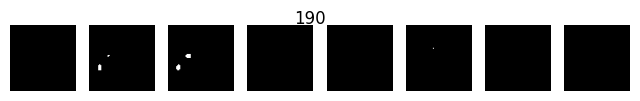

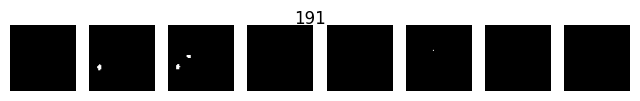

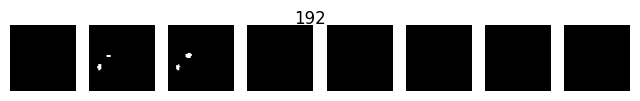

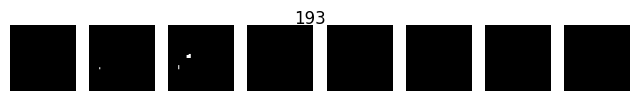

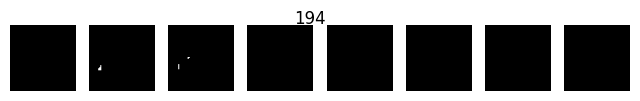

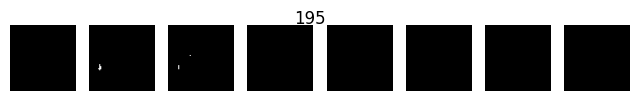

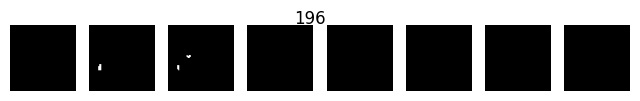

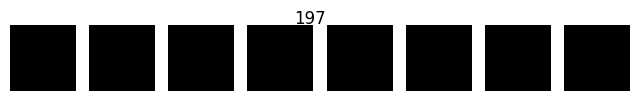

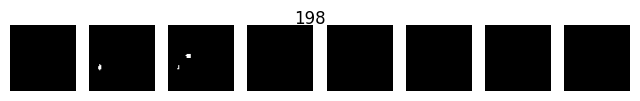

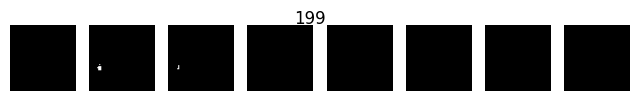

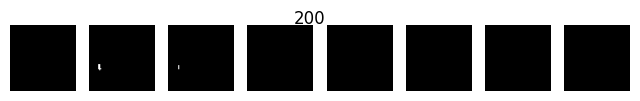

In [6]:
gt, _ = nrrd.read("./test_data/gt/18_volume_5.nrrd")
X, _ = nrrd.read("./test_data/inputs/18_volume_5.nrrd")
X = np.array([X]).astype(np.float32)
X = np.expand_dims(X, -1)

for i in range(1, 201):
    weightpath = "./checkpoints/cp-{:04d}.weights.h5".format(i)
    model.load_weights(weightpath)
    y = model.predict(X)
    y = y[0]
    y[y>=0.5]=1
    y[y<0.5]=0
    fig, axs = plt.subplots(1, 8, figsize=(8,1))
    axs[0].imshow(y[:,:,20], cmap='gray')
    axs[1].imshow(y[:,:,21], cmap='gray')
    axs[2].imshow(y[:,:,22], cmap='gray')
    axs[3].imshow(y[:,:,23], cmap='gray')
    axs[4].imshow(y[:,:,24], cmap='gray')
    axs[5].imshow(y[:,:,25], cmap='gray')
    axs[6].imshow(y[:,:,26], cmap='gray')
    axs[7].imshow(y[:,:,27], cmap='gray')
    axs[0].set_axis_off()
    axs[1].set_axis_off()
    axs[2].set_axis_off()
    axs[3].set_axis_off()
    axs[4].set_axis_off()
    axs[5].set_axis_off()
    axs[6].set_axis_off()
    axs[7].set_axis_off()
    fig.suptitle(i)
    fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


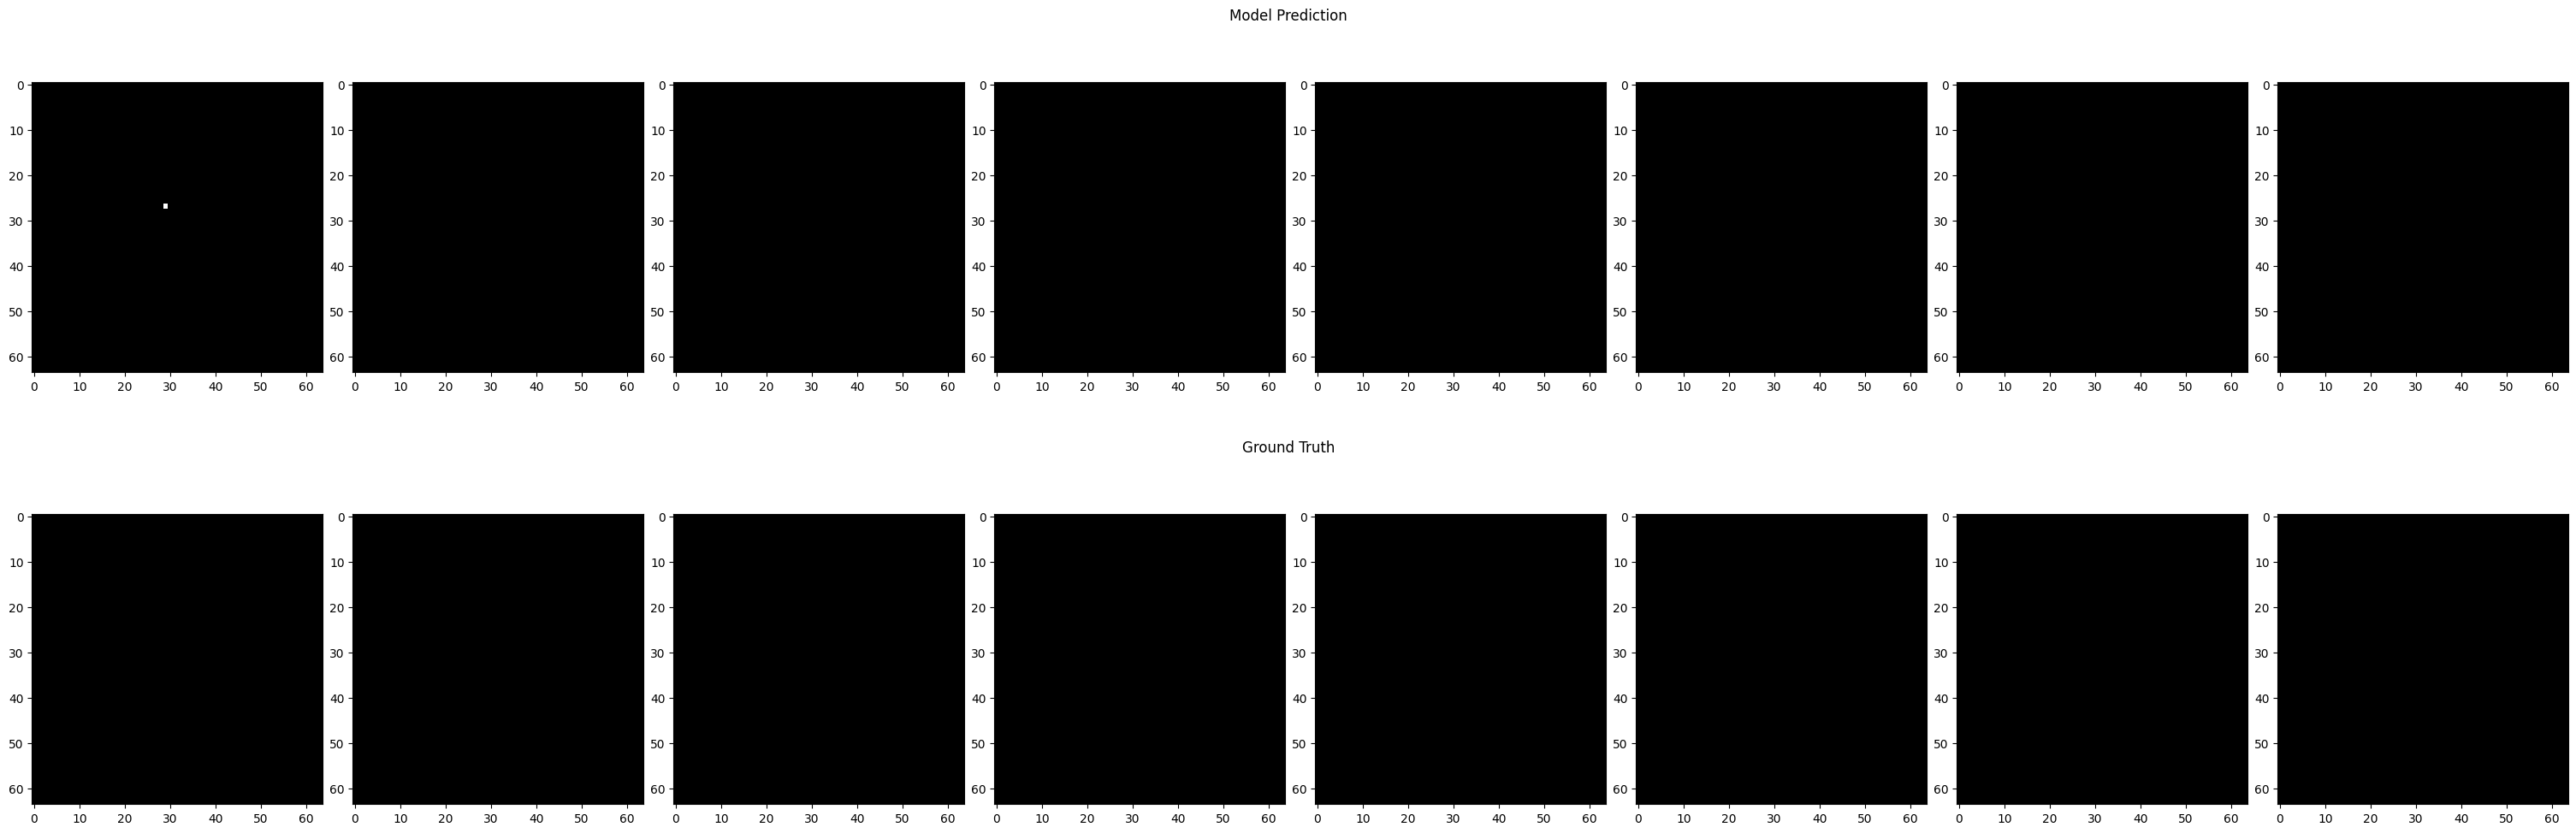

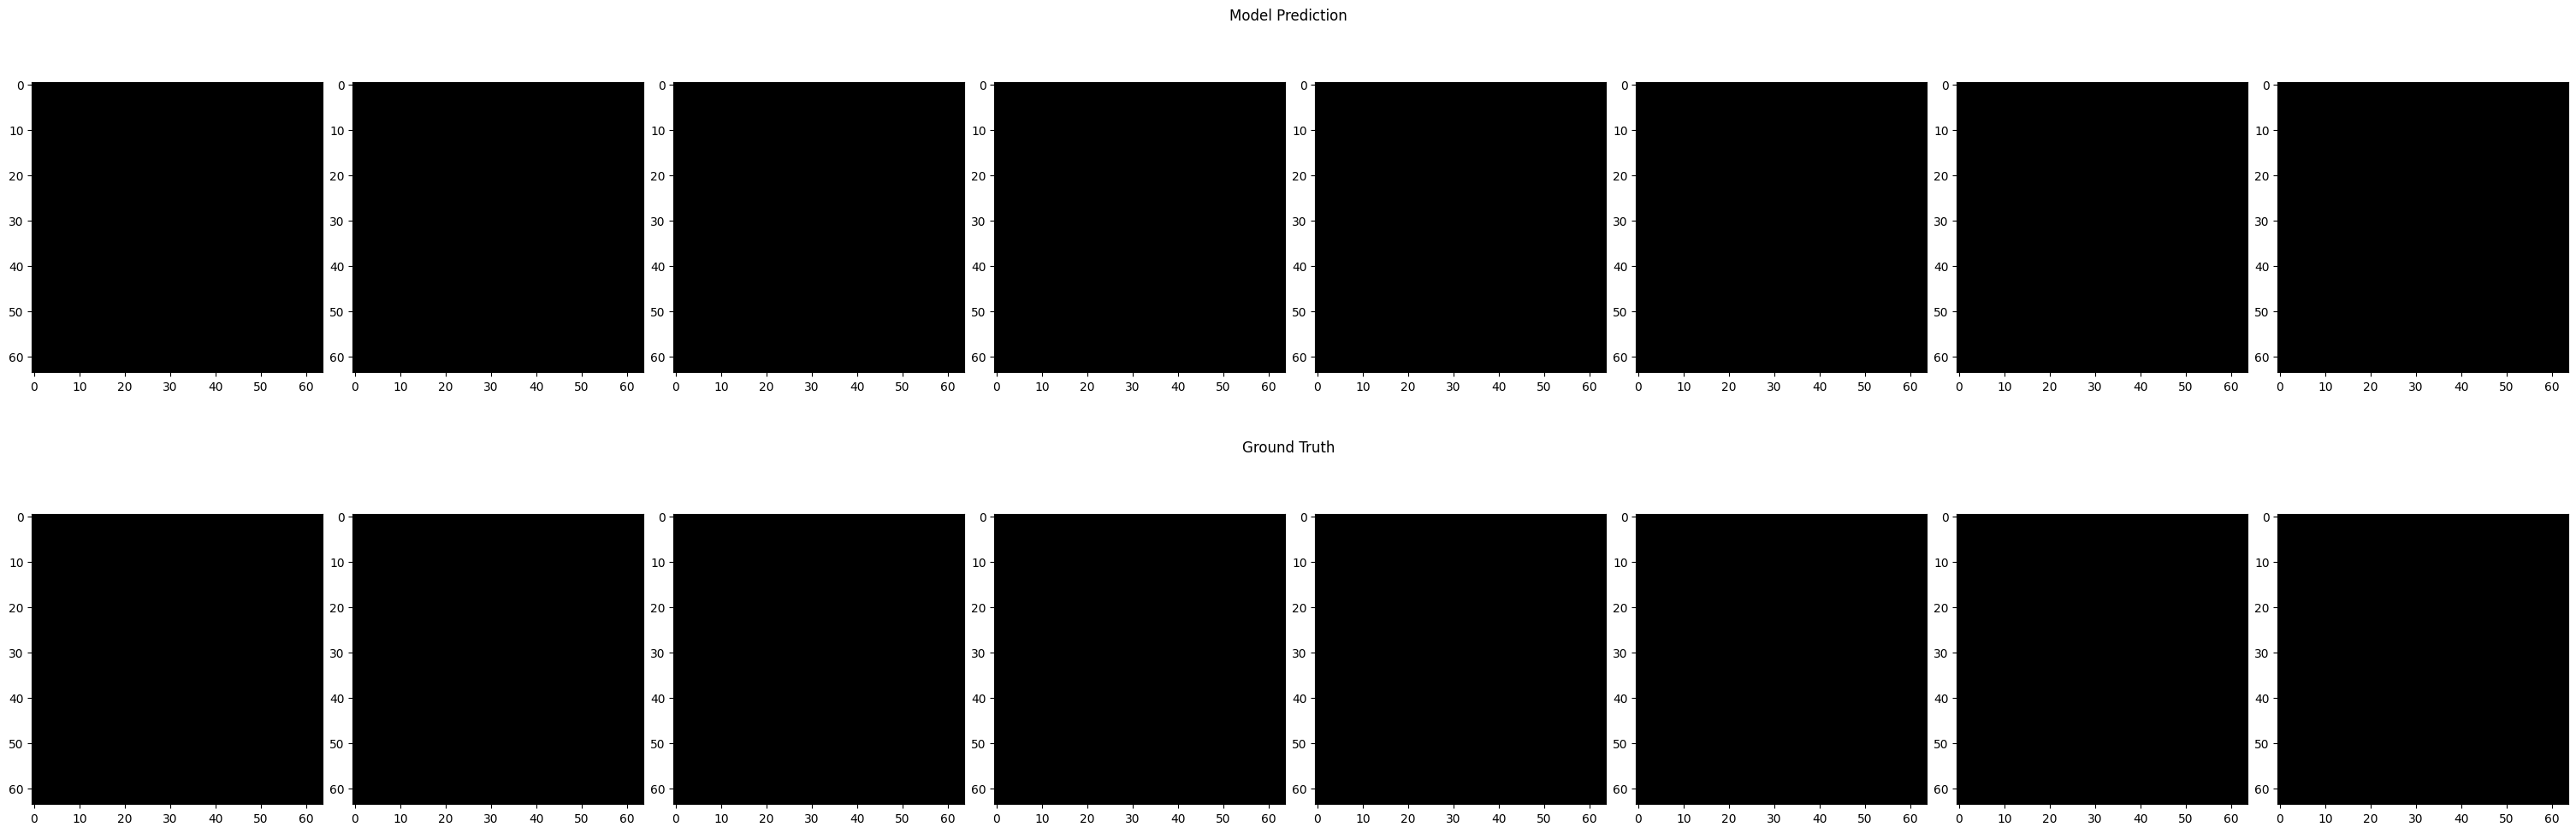

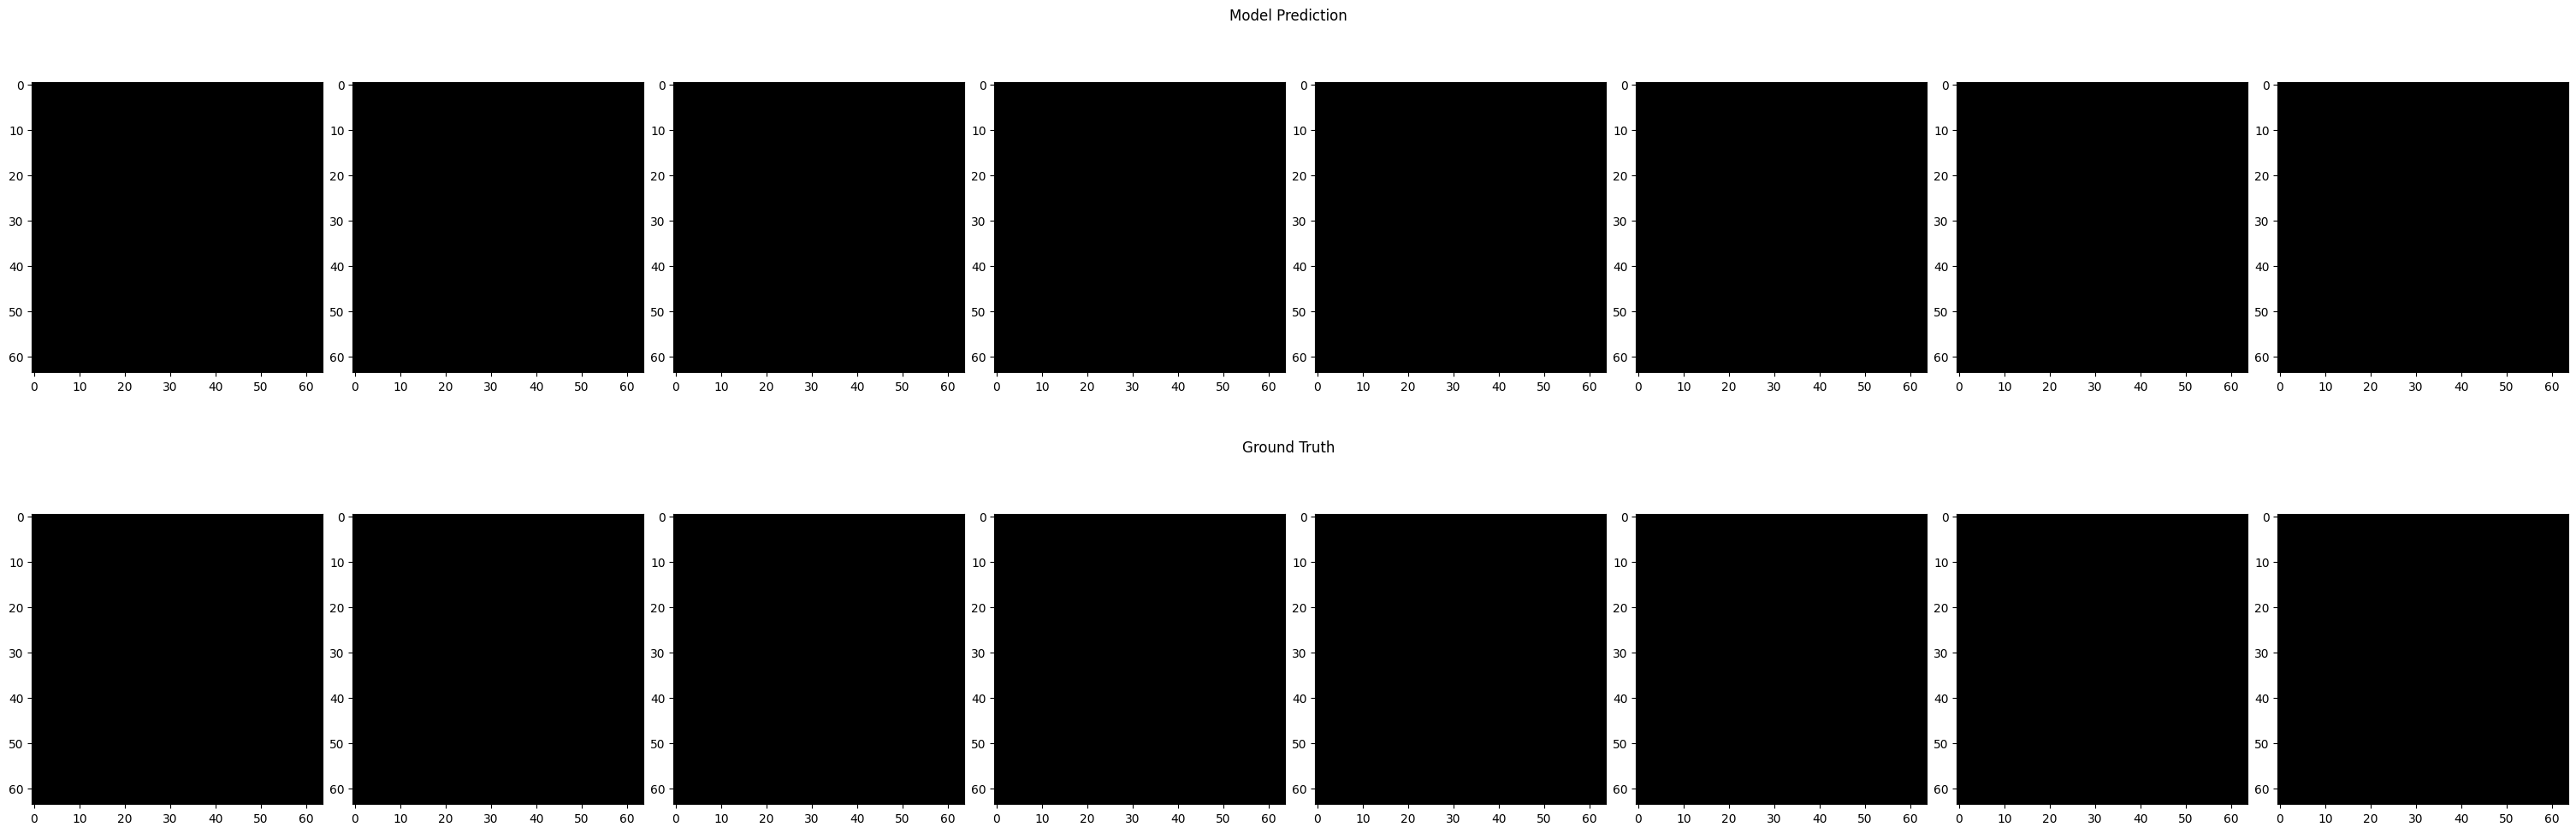

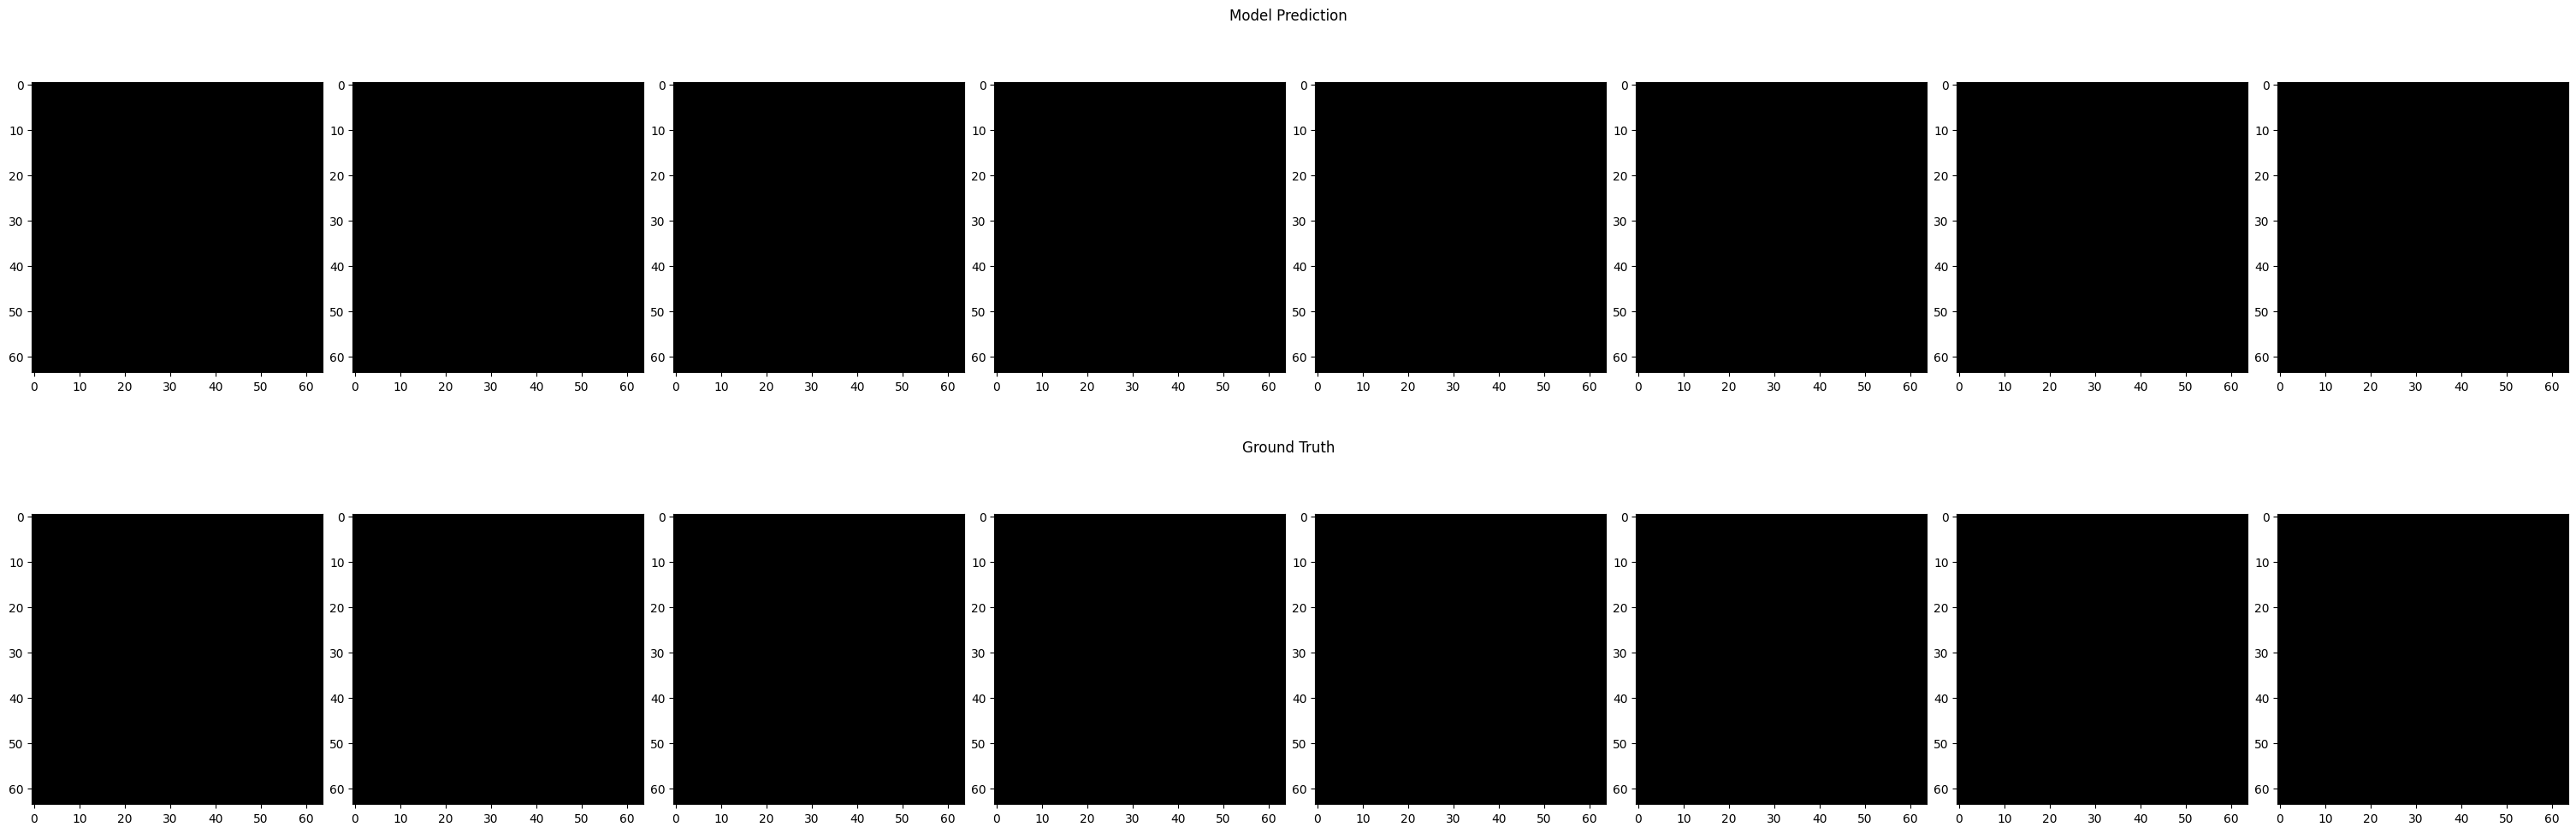

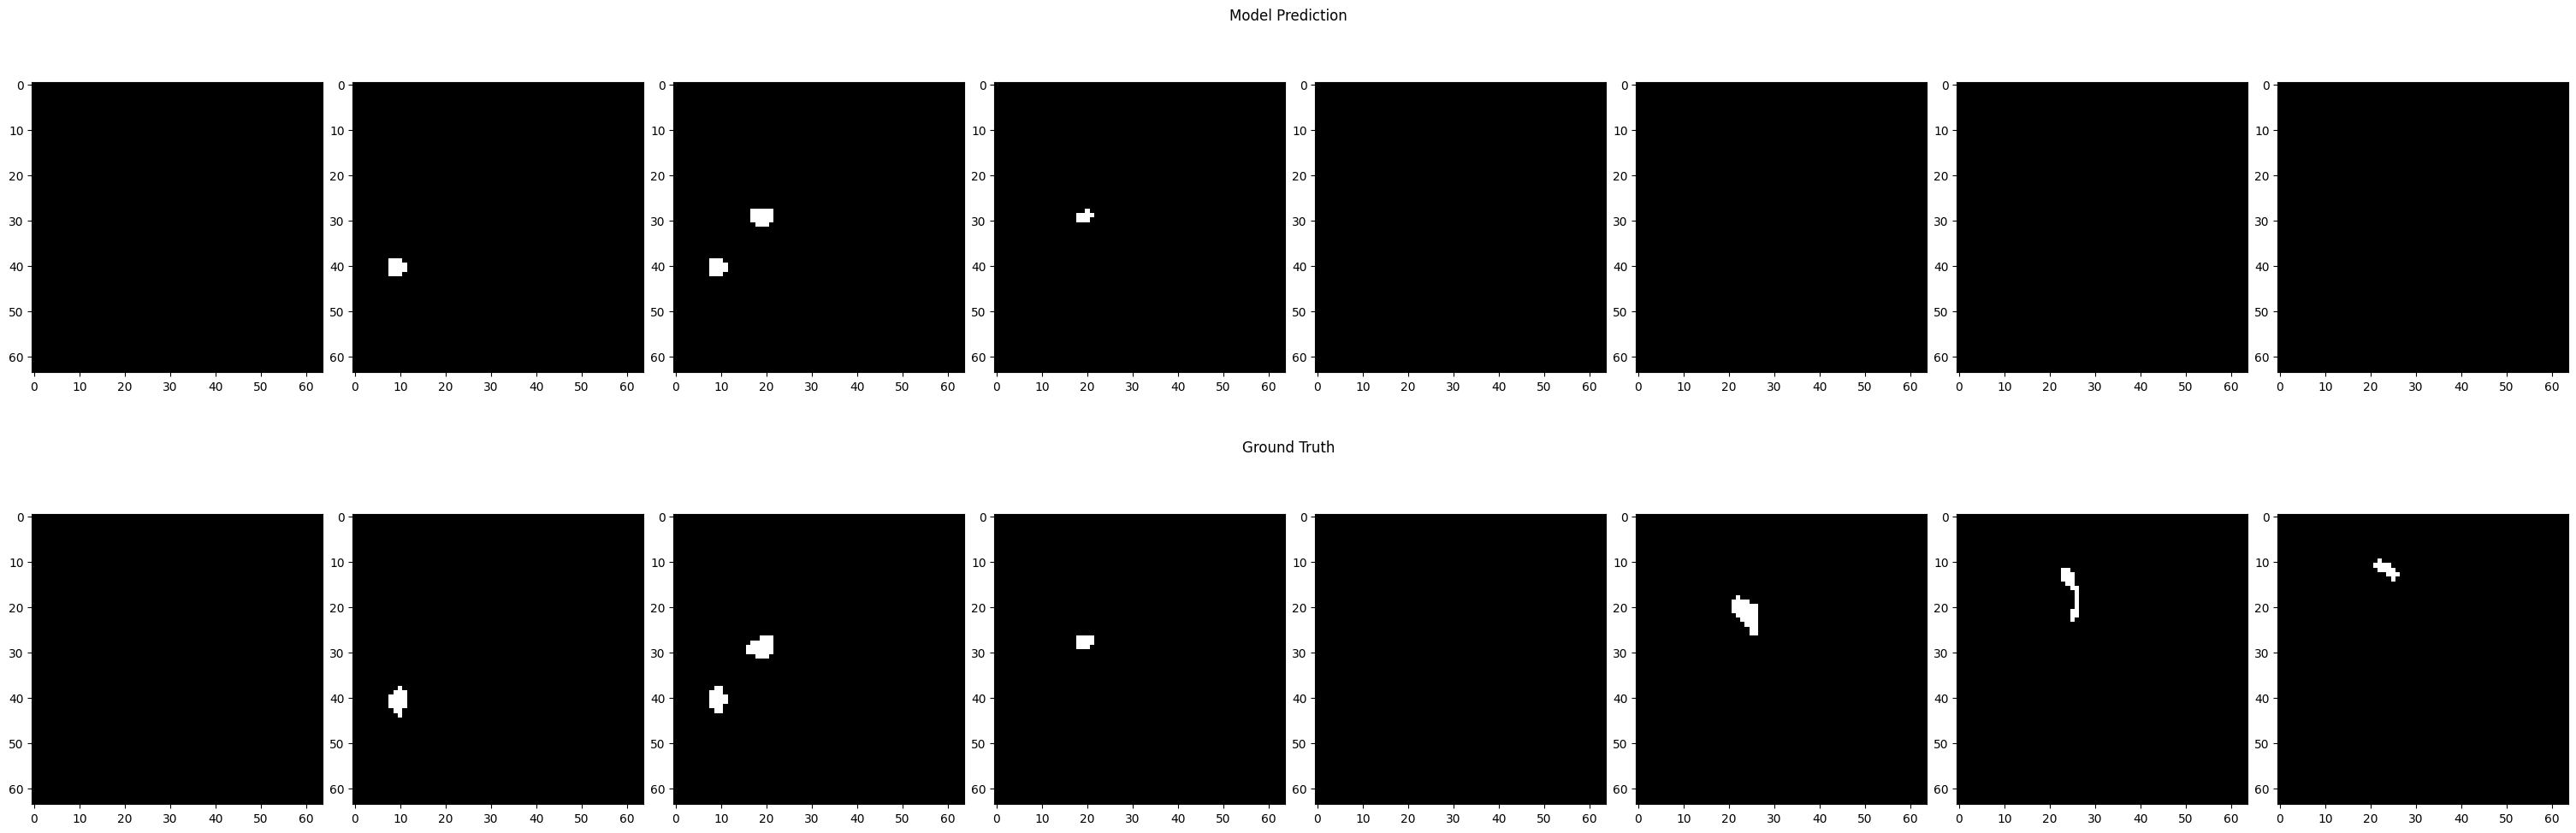

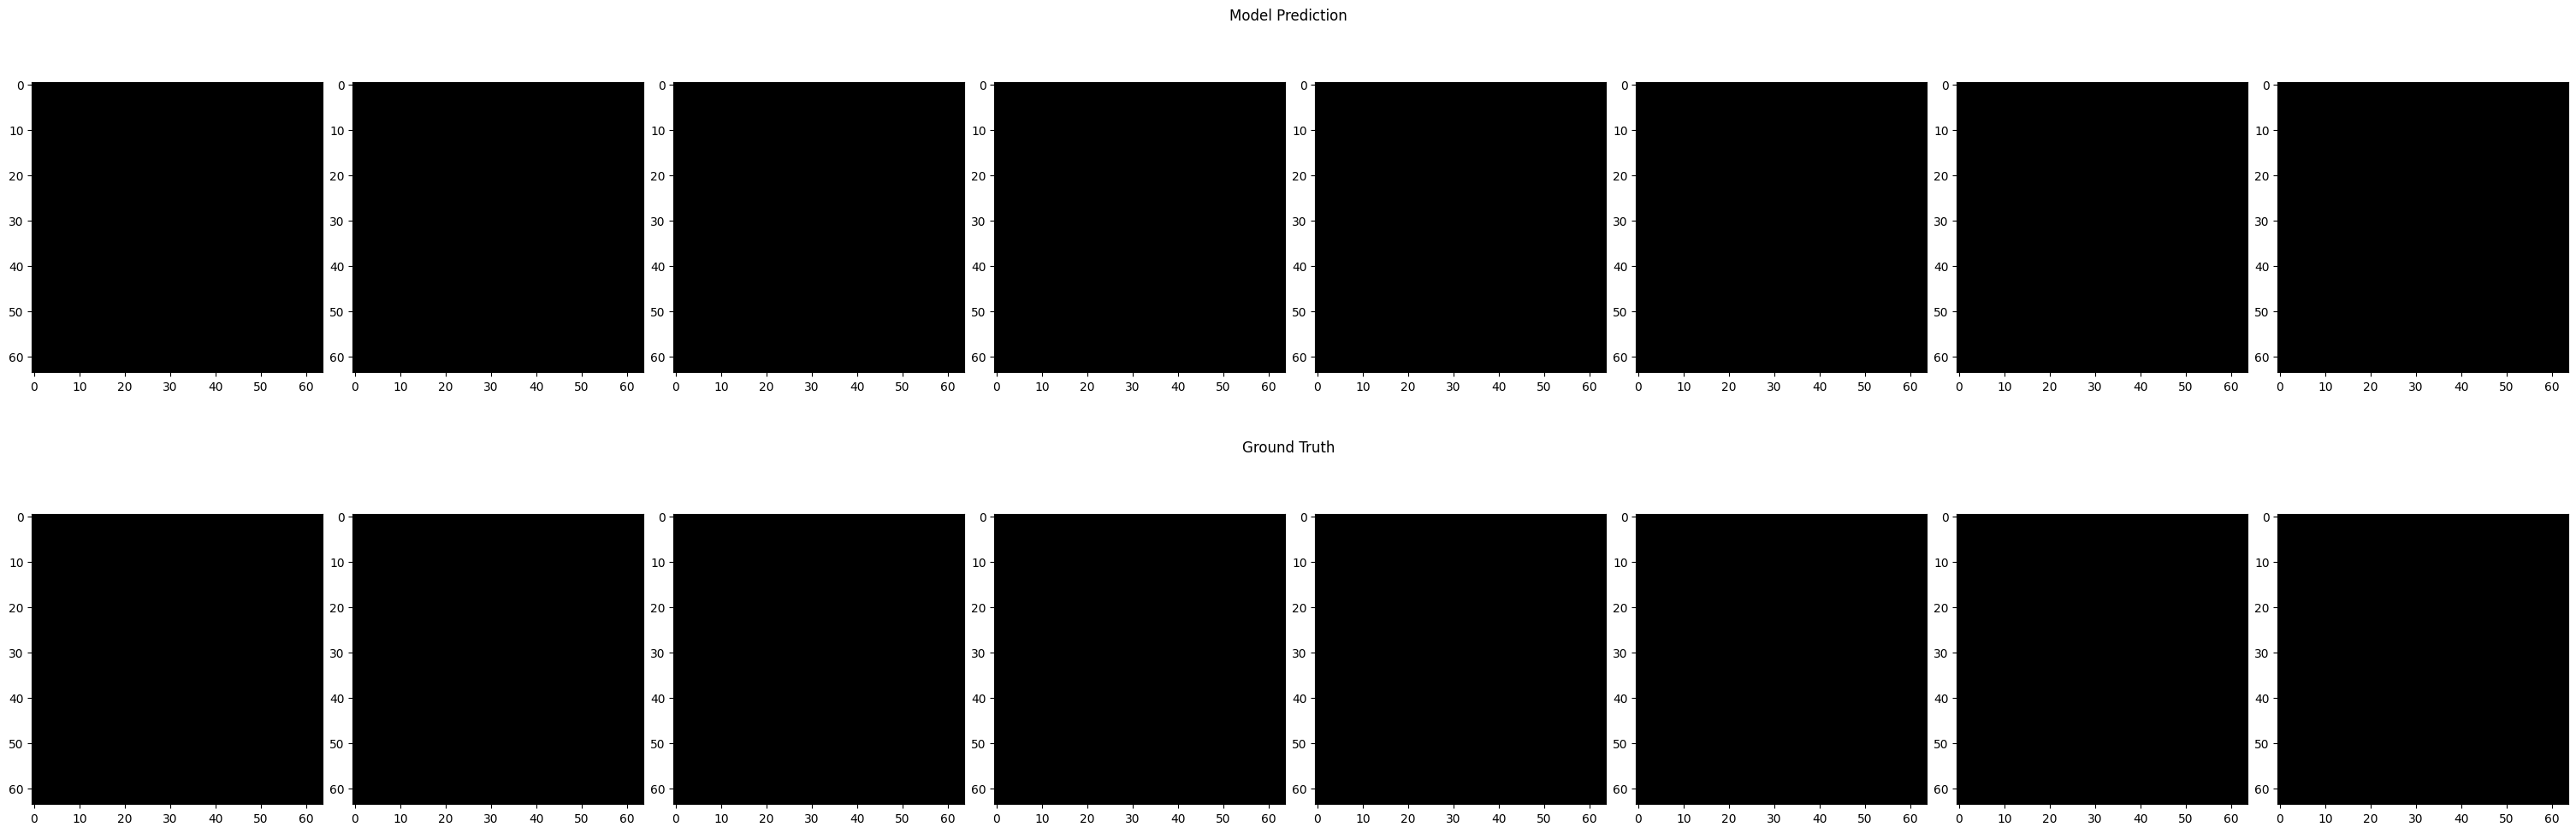

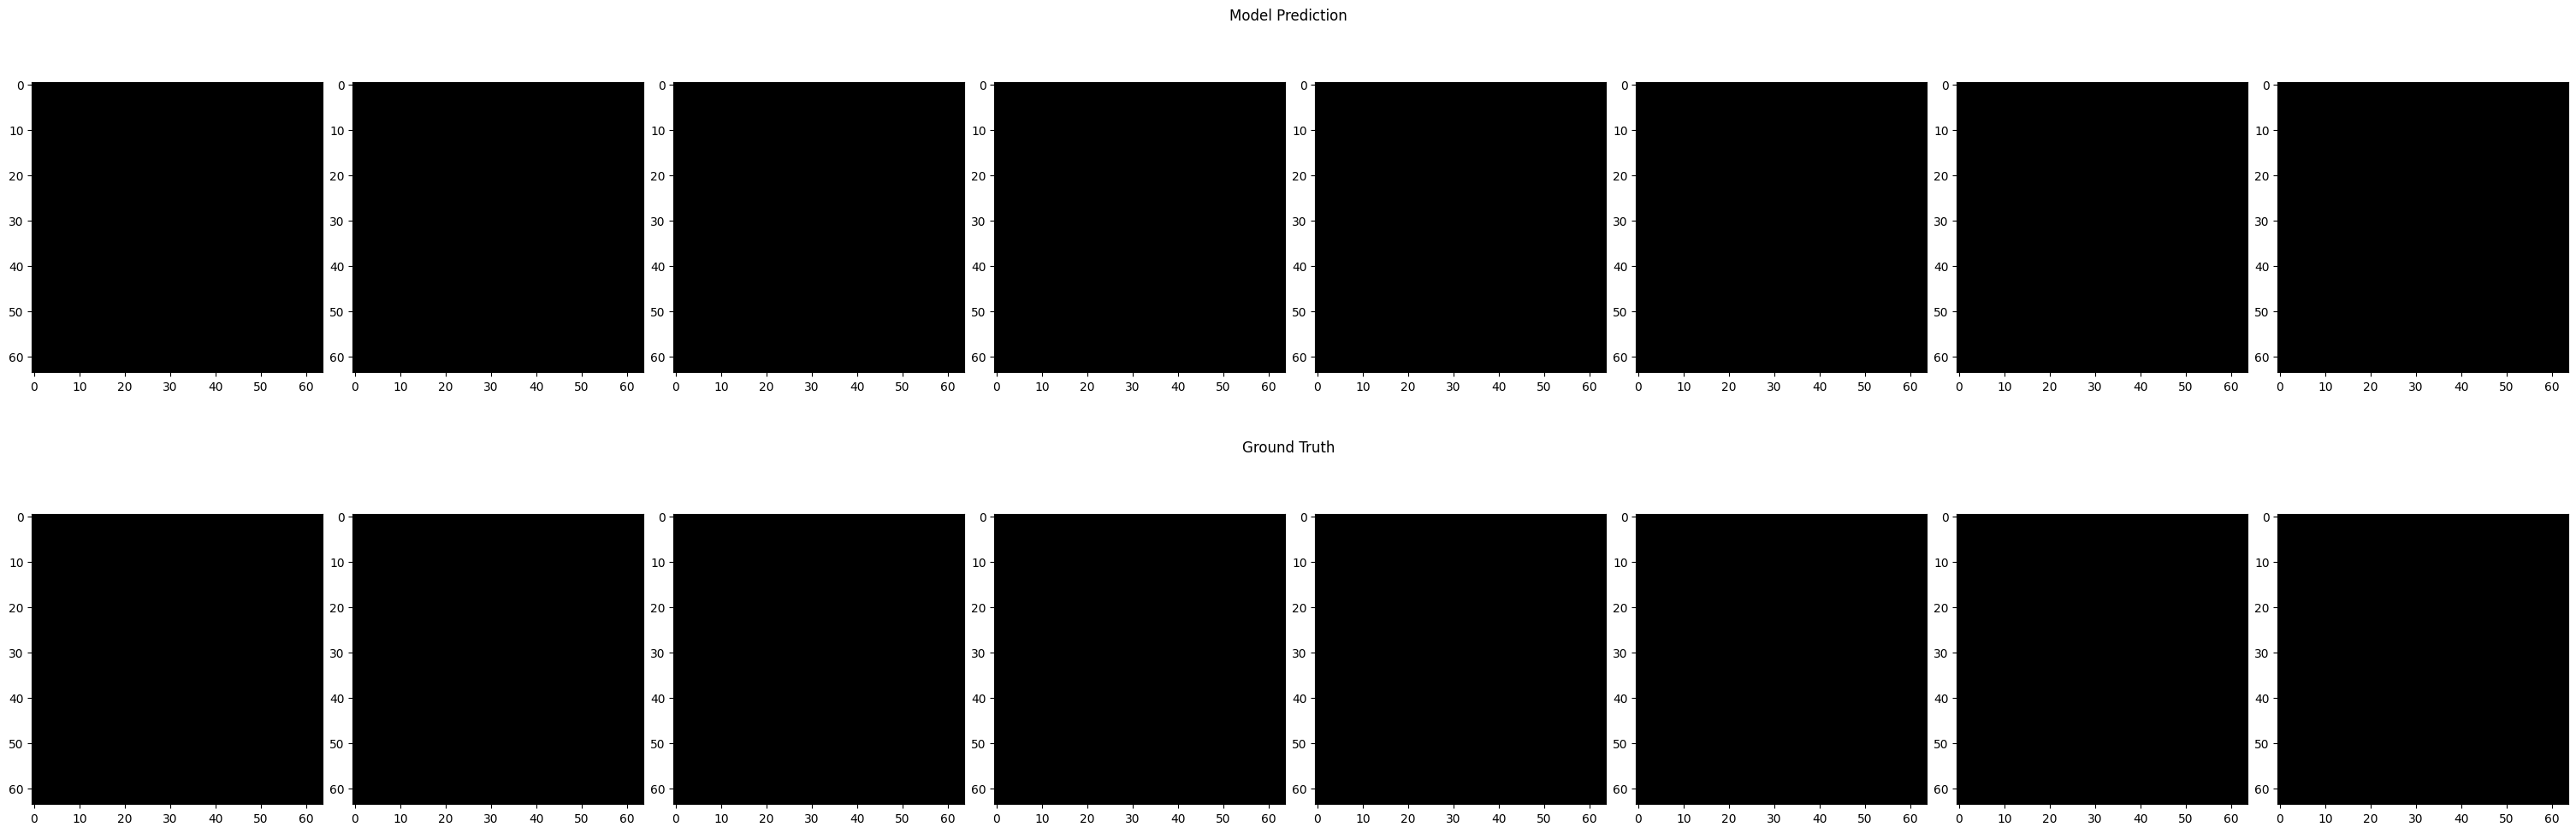

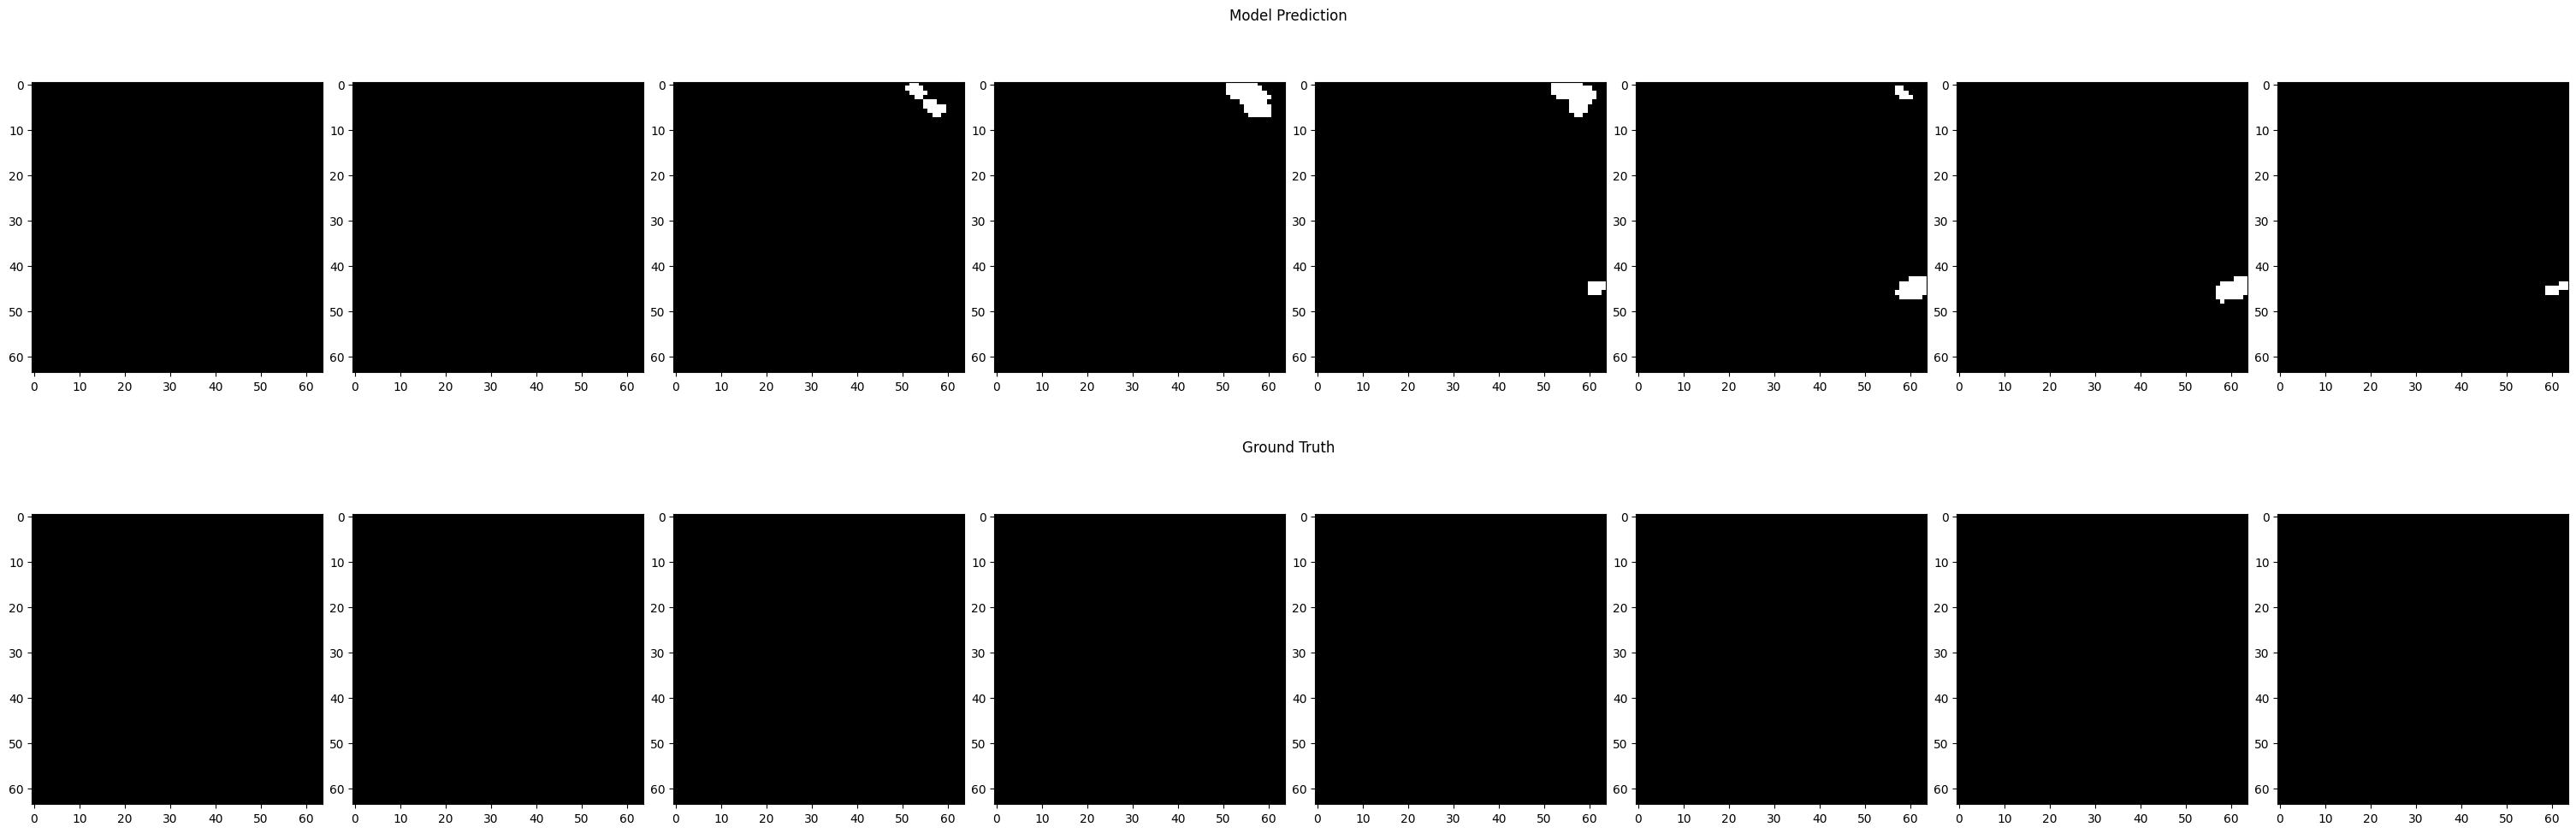

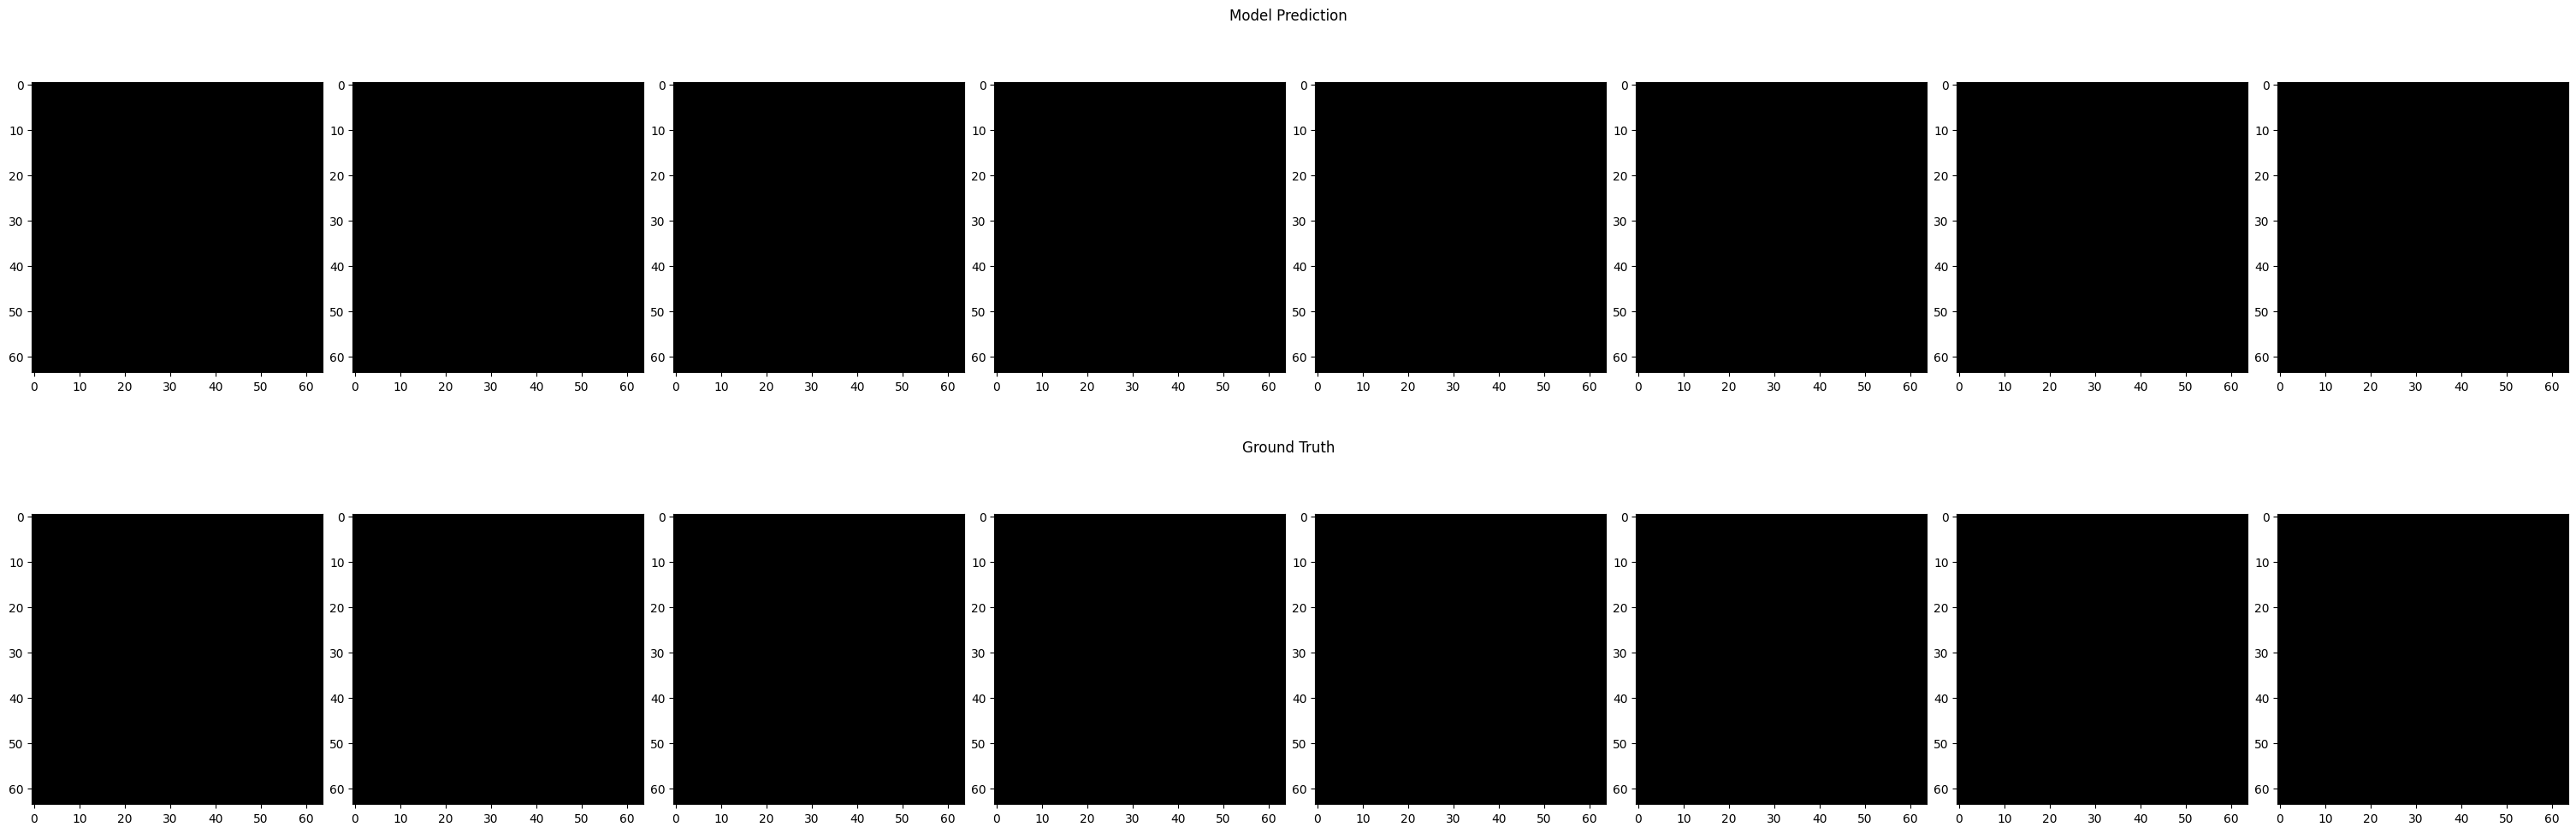

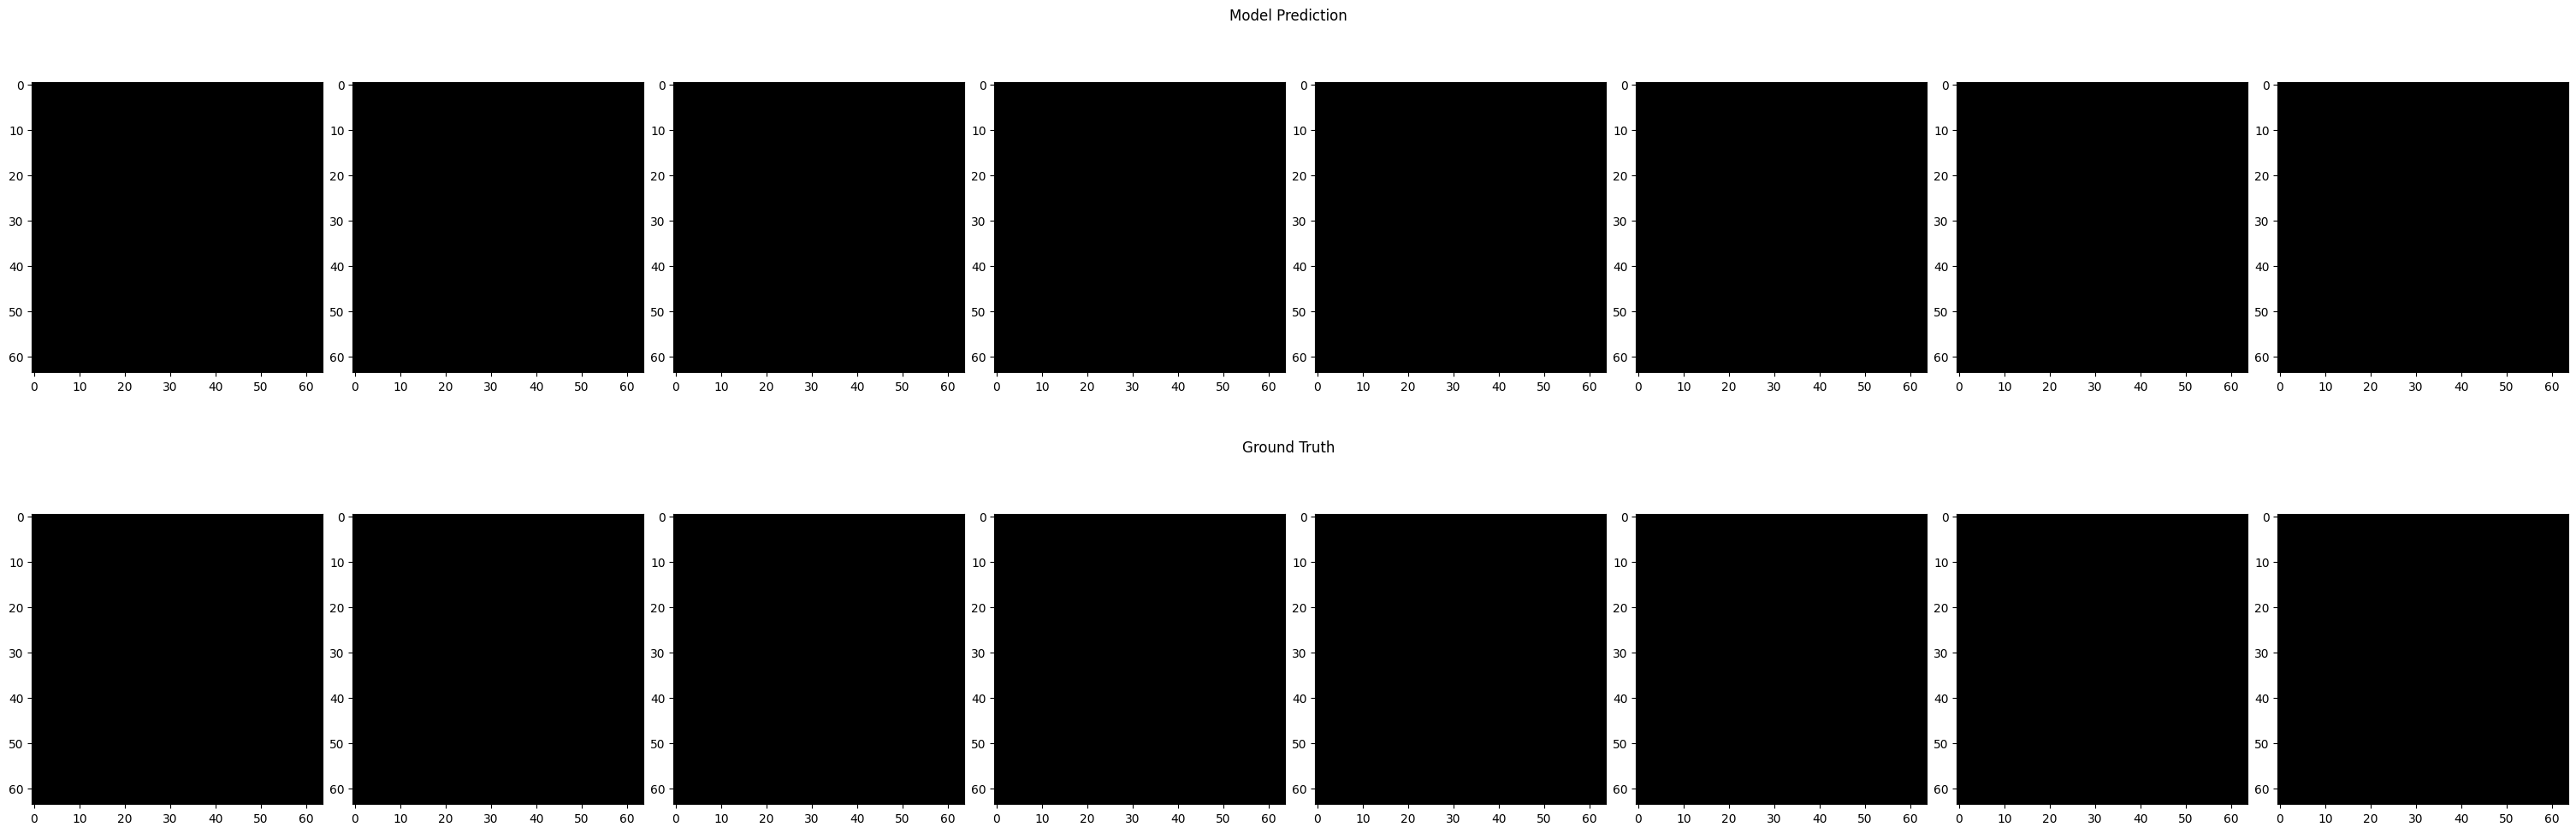

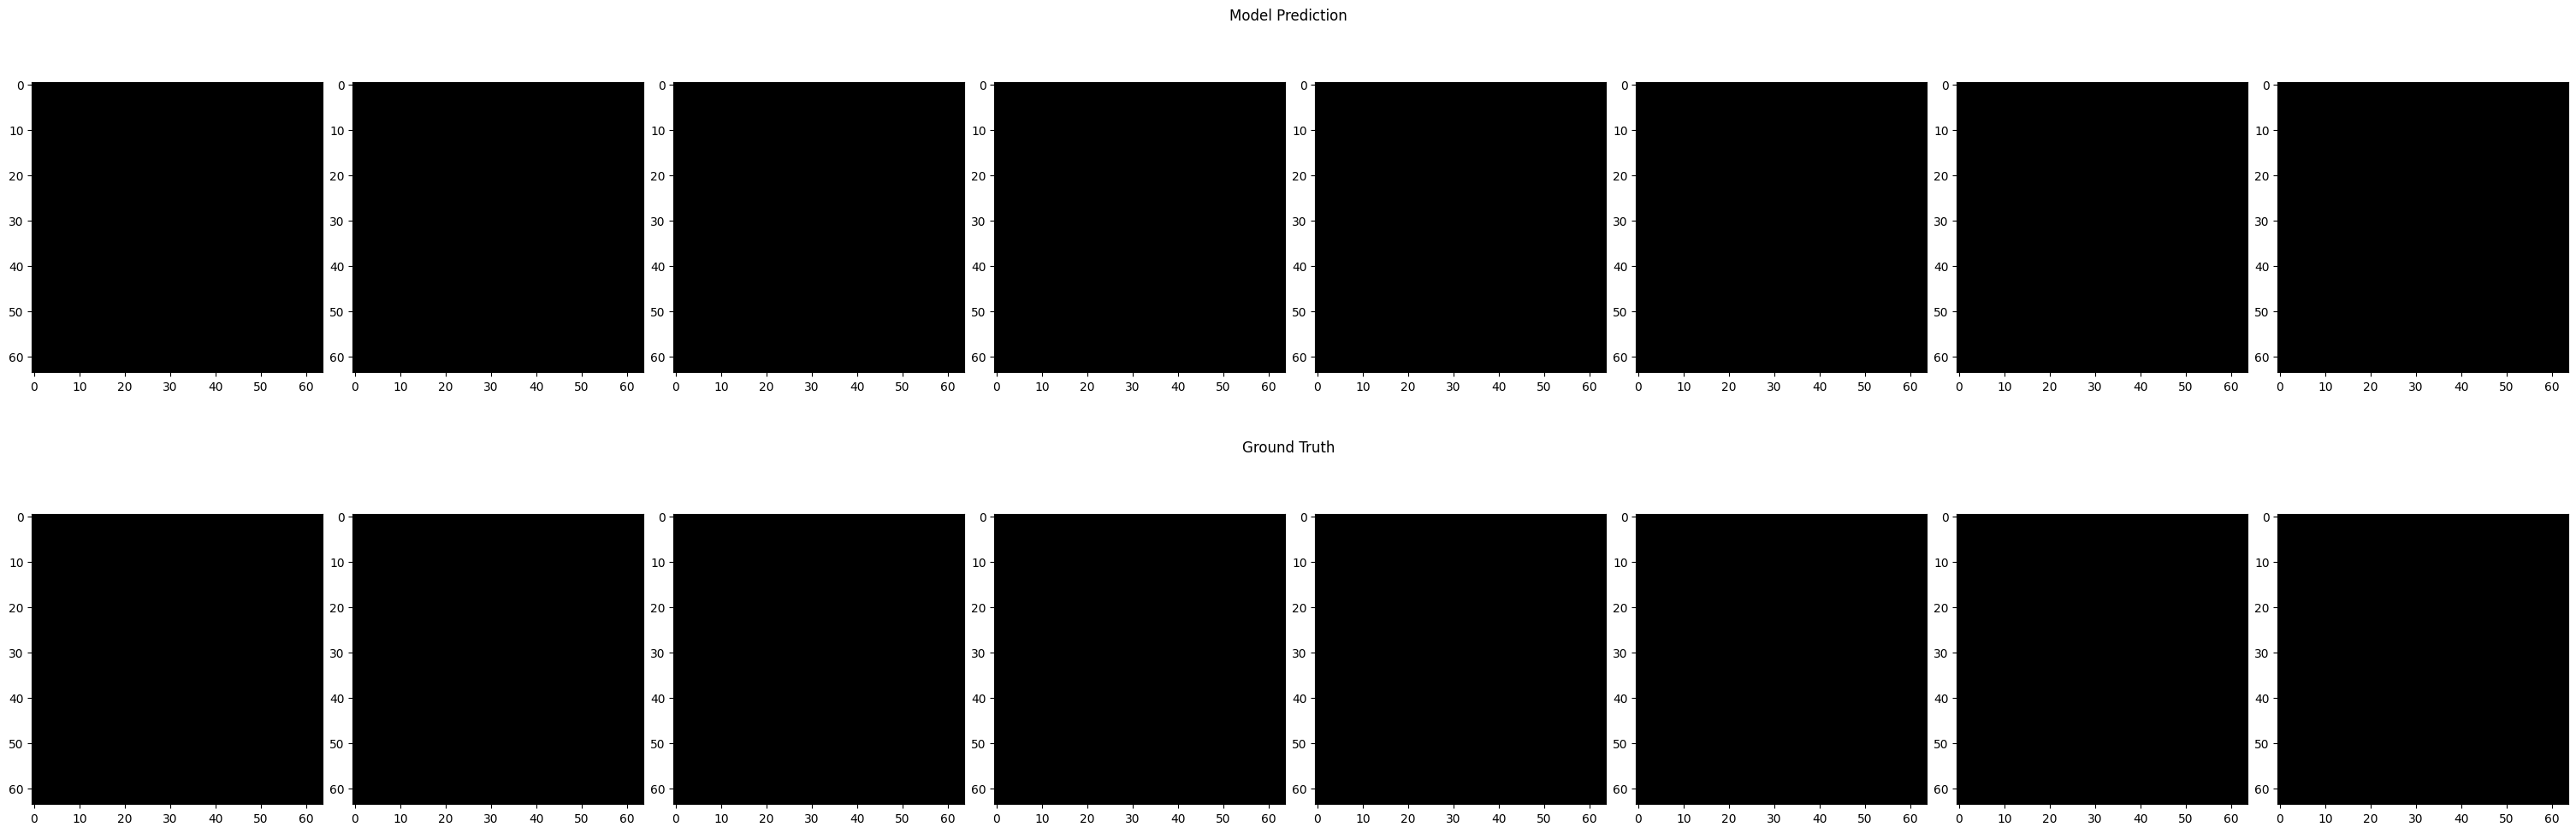

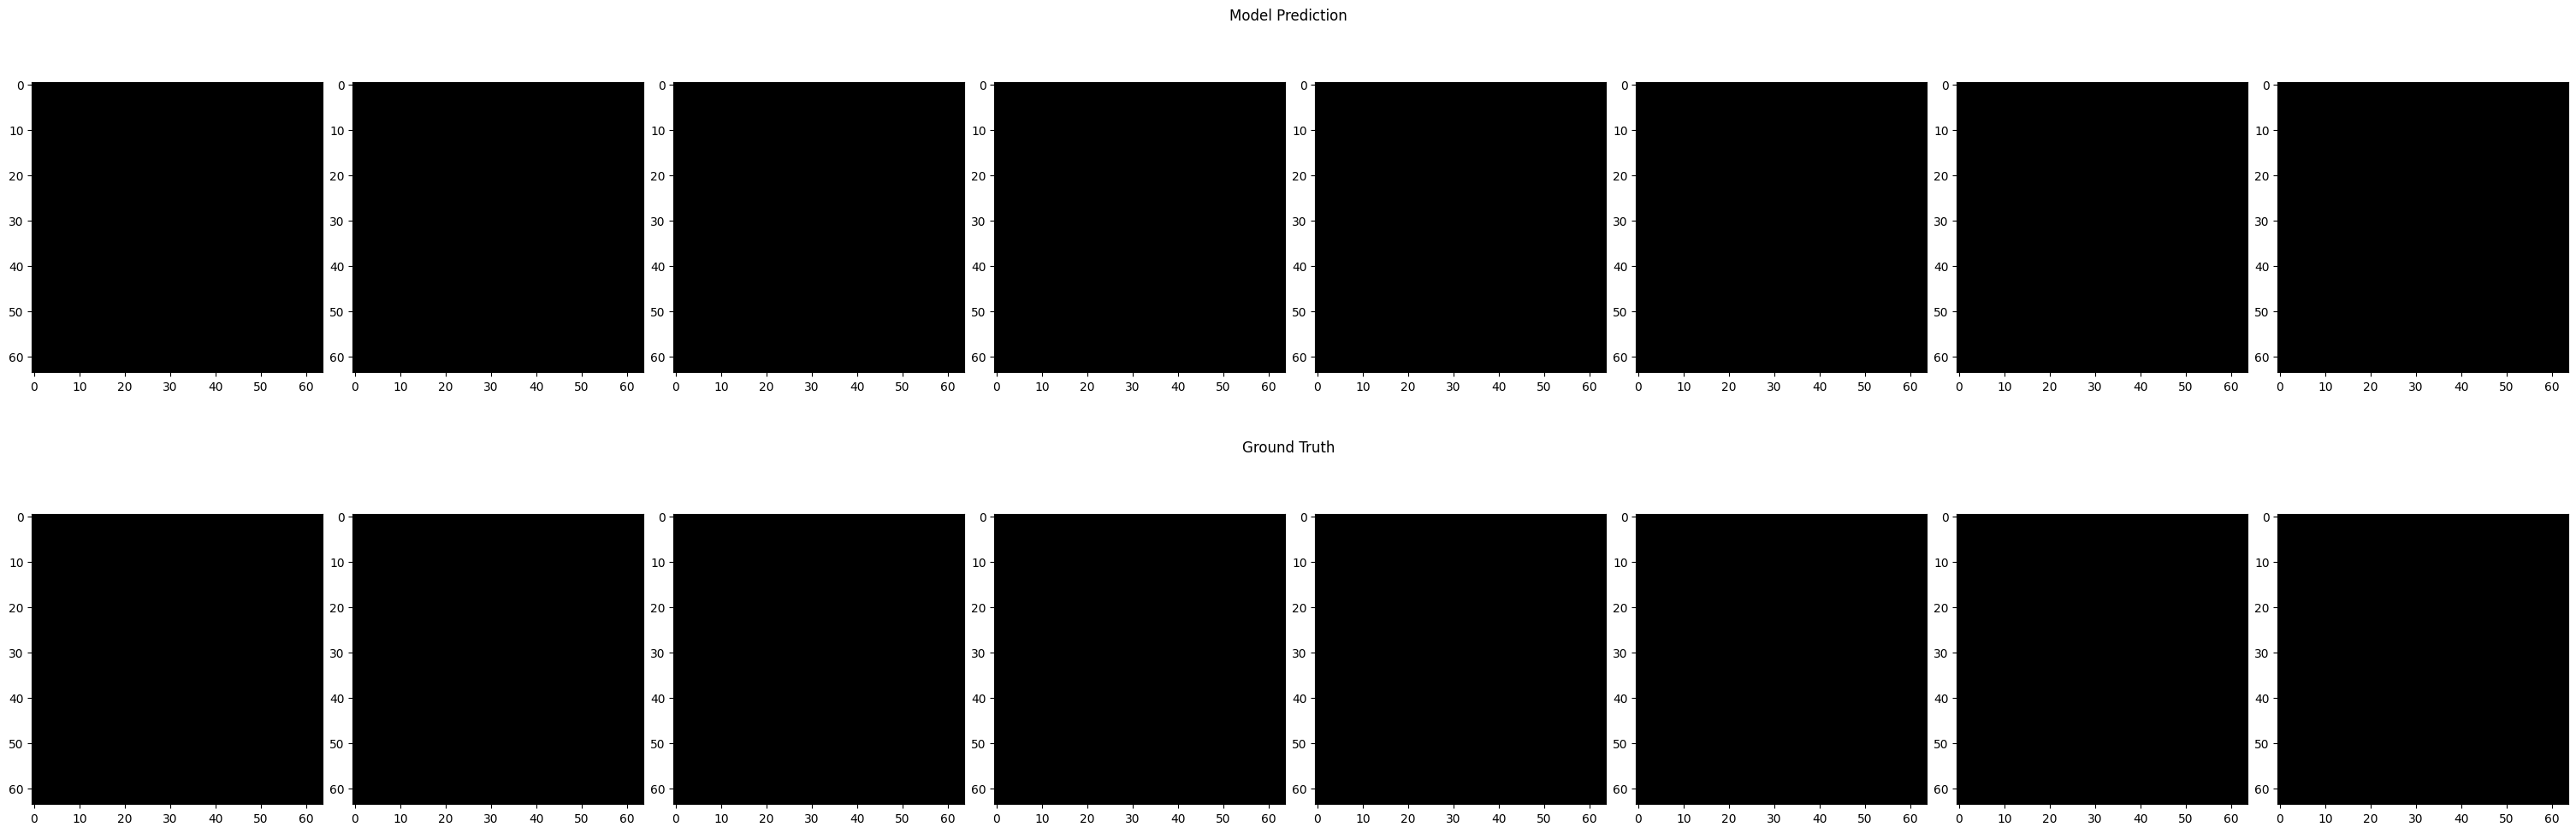

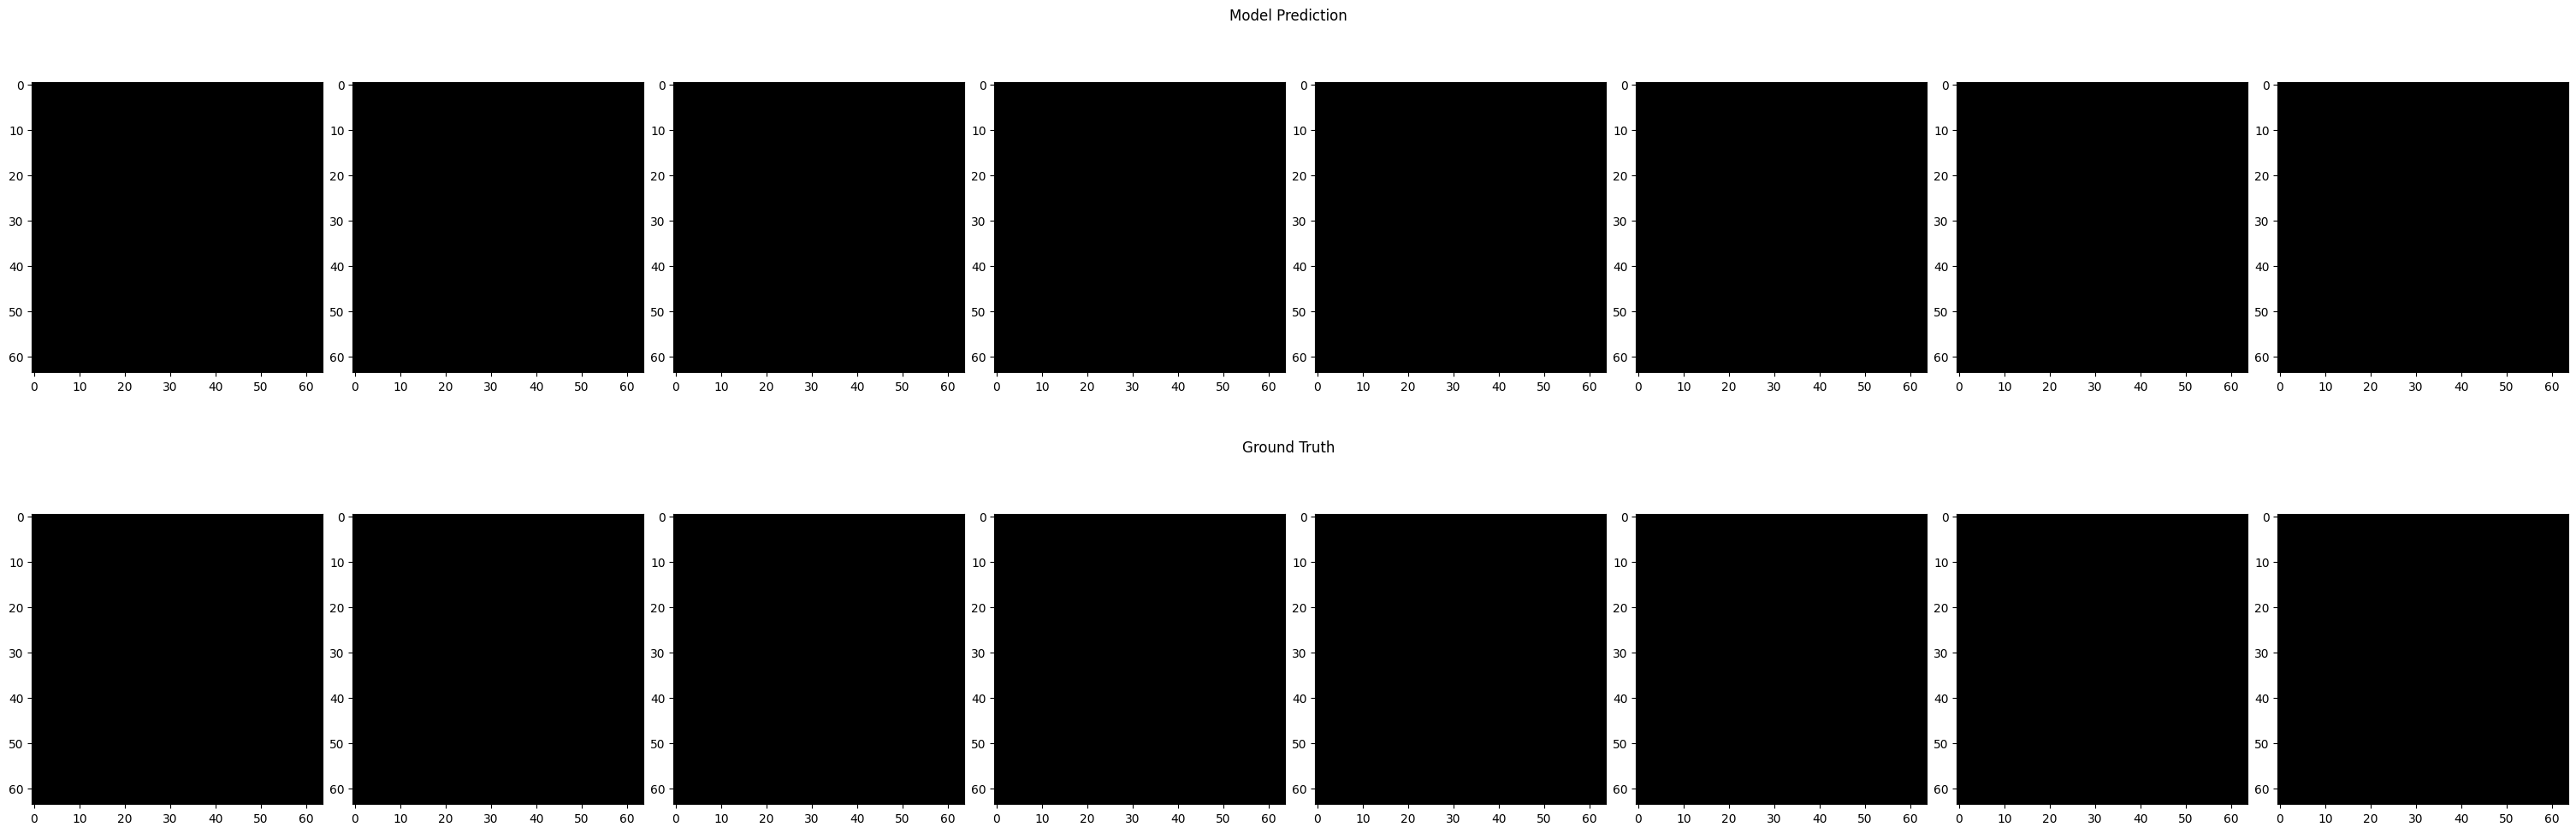

In [11]:
model.load_weights("./checkpoints/cp-0020.weights.h5")

gt_plaqueslices = [
    [57, 58, 59, 60, 61, 62, 63, 64],
    [52, 53, 54, 55, 56, 57, 58, 59],
    [48, ]
    
]

for i in range(1, 14):
    gt, _ = nrrd.read("./test_data/gt/18_volume_"+str(i)+".nrrd")
    X, _ = nrrd.read("./test_data/inputs/18_volume_" + str(i)+".nrrd")
    X = np.array([X]).astype(np.float32)
    X = np.expand_dims(X, -1)
        
    y = model.predict(X)
    y = y[0]
    y[y>=0.5]=1
    y[y<0.5]=0
    
    fig = plt.figure(constrained_layout=True, figsize=(30,10))
    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=2, ncols=1)
    
    pred_axs = subfigs[0].subplots(nrows=1, ncols=8)
    subfigs[0].suptitle("Model Prediction")
    pred_axs[0].imshow(y[:,:,20], cmap='gray')
    pred_axs[1].imshow(y[:,:,21], cmap='gray')
    pred_axs[2].imshow(y[:,:,22], cmap='gray')
    pred_axs[3].imshow(y[:,:,23], cmap='gray')
    pred_axs[4].imshow(y[:,:,24], cmap='gray')
    pred_axs[5].imshow(y[:,:,25], cmap='gray')
    pred_axs[6].imshow(y[:,:,26], cmap='gray')
    pred_axs[7].imshow(y[:,:,27], cmap='gray')
    
    gt_axs = subfigs[1].subplots(nrows=1, ncols=8)
    subfigs[1].suptitle("Ground Truth")
    gt_axs[0].imshow(gt[:,:,20], cmap='gray')
    gt_axs[1].imshow(gt[:,:,21], cmap='gray')
    gt_axs[2].imshow(gt[:,:,22], cmap='gray')
    gt_axs[3].imshow(gt[:,:,23], cmap='gray')
    gt_axs[4].imshow(gt[:,:,24], cmap='gray')
    gt_axs[5].imshow(gt[:,:,25], cmap='gray')
    gt_axs[6].imshow(gt[:,:,26], cmap='gray')
    gt_axs[7].imshow(gt[:,:,27], cmap='gray')
    fig.show()